<div class="alert alert-block alert-success">

## <center> Tracking Issues created for Repos on GitHub </center>
## <center> Plot and Forecast Issues </center>
    

</div>

<div class="alert alert-block alert-danger">
    
### Deliverables: 
- Submit a single ZIP file  that has the folowing items:
    1. Your PDF document for the analysis report. 
    2. Your IPYNB script with the name GitHub_Repos_Issues_Forecasting.ipynb that has your source code and output for the requirements listed 
    2. Your HTML/PDF document that has your source code and output for the requirements listed 

<br>
    
</div>

<hr style="border:2px solid black"> </hr>
<div class="alert alert-info">



        
## REQUIREMENT 1

Use Python/GitHub API to retrieve Issues/Repos information of the **past 2 months** for the following  repositories:
- https://github.com/meta-llama/llama3
- https://github.com/ollama/ollama
- https://github.com/langchain-ai/langchain
- https://github.com/langchain-ai/langgraph
- https://github.com/microsoft/autogen
- https://github.com/openai/openai-cookbook 
- https://github.com/elastic/elasticsearch 
- https://github.com/milvus-io/pymilvus 


## Important: Data Retrieval Timeframe

 - For **chart visualizations below**, retrieve **past 2 years** of data.
 - For **semantic search and vector embeddings**, use **past 2 months** of data from the above repositories.

    
</div>



In [200]:
!pip install tensorflow
!pip install prophet
!pip install statsmodels

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
import requests
from datetime import datetime, timedelta, timezone
import time
import re

In [203]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [204]:
import logging
# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)  # or DEBUG, WARNING, ERROR, etc.

# Create a file handler
file_handler = logging.FileHandler('forecasting_notebook.log')
file_handler.setLevel(logging.INFO)

# Create a logging format
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(file_handler)

# Optional: also log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

logger.info("Starting the forecasting notebook.")

2025-04-25 03:31:01,925 - __main__ - INFO - Starting the forecasting notebook.
2025-04-25 03:31:01,925 - __main__ - INFO - Starting the forecasting notebook.
2025-04-25 03:31:01,925 - INFO - Starting the forecasting notebook.


In [205]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)

GITHUB_TOKEN = os.environ["GITHUB_TOKEN"]

headers = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

repos = [
    "meta-llama/llama3",
    "ollama/ollama",
    "langchain-ai/langchain",
    "langchain-ai/langgraph",
    "microsoft/autogen",
    "openai/openai-cookbook",
    "elastic/elasticsearch",
    "milvus-io/pymilvus"
]

now = datetime.today()
since_2_months = (now - timedelta(days=60)).isoformat() + "Z"
since_2_years = (now - timedelta(days=730)).isoformat() + "Z"


In [206]:
import asyncio
import aiohttp
from aiohttp import ClientSession
import time

from functools import wraps

def timing_async(fn):
    @wraps(fn)
    async def wrapper(*args, **kwargs):
        start = time.time()
        result = await fn(*args, **kwargs)
        end = time.time()
        
        (f"{fn.__name__} took {end - start:.2f} seconds")
        return result
    return wrapper


MAX_RETRIES = 3
MAX_PAGES = 100  # max number of pages to attempt
CONCURRENT_BATCH_SIZE = 20  # number of pages to fetch concurrently

async def fetch_page(session, repo, since, label, page):
    url = f"https://api.github.com/repos/{repo}/issues"
    params = {
        "state": "all",
        "since": since,
        "per_page": 100,
        "page": page
    }

    for attempt in range(MAX_RETRIES):
        try:
            async with session.get(url, headers=headers, params=params) as response:
                if response.status != 200:
                    logger.debug(f"[{label}] Attempt {attempt+1}: Error {response.status} on page {page} -- url {url}")
                    await asyncio.sleep(attempt)
                    continue
                data = await response.json()
                return page, data
        except Exception as e:
            logger.debug(f"[{label}] Attempt {attempt+1}: Exception {e} on page {page}")
            await asyncio.sleep(attempt)
    return page, []

@timing_async
async def async_fetch_issues(repo, since, label):
    logger.info(f"Fetching {label} issues from: {repo}")
    all_issues = []
    seen_empty = False
    page = 1

    async with aiohttp.ClientSession() as session:
        while not seen_empty:
            tasks = [
                fetch_page(session, repo, since, label, p)
                for p in range(page, page + CONCURRENT_BATCH_SIZE)
            ]
            results = await asyncio.gather(*tasks)

            for pg, data in results:
                if not data:
                    seen_empty = True
                    continue
                for issue in data:
                    is_pr = "pull_request" in issue
                    all_issues.append({
                        "repo": repo,
                        "id": issue["id"],
                        "number": issue["number"],
                        "title": issue["title"],
                        "state": issue["state"],
                        "created_at": issue["created_at"],
                        "closed_at": issue["closed_at"],
                        "pull_request": is_pr
                    })
            page += CONCURRENT_BATCH_SIZE

    return all_issues

In [207]:
# result = await async_fetch_issues("milvus-io/pymilvus", since_2_years, "2-years")
# len(result)

In [208]:
from itertools import chain

issues_2_years = []

tasks = [
  async_fetch_issues(
    repo, 
    since_2_years,
    "2-years"
  )
  for repo in repos]

results = await asyncio.gather(*tasks)
issues_2_years = list(chain.from_iterable(results))

logger.info(f"len(issues_2_years) {len(issues_2_years)}")

df_2_years = pd.DataFrame(issues_2_years)
df_2_years.to_csv("data/issues_last_2_years.csv", index=False)

logger.info("==== Done ====")
logger.info("Done fetching issues for 2 years.")
logger.info(f"Total:{len(df_2_years)}")

2025-04-25 03:31:01,967 - __main__ - INFO - Fetching 2-years issues from: meta-llama/llama3


2025-04-25 03:31:01,967 - __main__ - INFO - Fetching 2-years issues from: meta-llama/llama3
2025-04-25 03:31:01,967 - INFO - Fetching 2-years issues from: meta-llama/llama3
2025-04-25 03:31:01,968 - __main__ - INFO - Fetching 2-years issues from: ollama/ollama
2025-04-25 03:31:01,968 - __main__ - INFO - Fetching 2-years issues from: ollama/ollama
2025-04-25 03:31:01,968 - INFO - Fetching 2-years issues from: ollama/ollama
2025-04-25 03:31:01,969 - __main__ - INFO - Fetching 2-years issues from: langchain-ai/langchain
2025-04-25 03:31:01,969 - __main__ - INFO - Fetching 2-years issues from: langchain-ai/langchain
2025-04-25 03:31:01,969 - INFO - Fetching 2-years issues from: langchain-ai/langchain
2025-04-25 03:31:01,970 - __main__ - INFO - Fetching 2-years issues from: langchain-ai/langgraph
2025-04-25 03:31:01,970 - __main__ - INFO - Fetching 2-years issues from: langchain-ai/langgraph
2025-04-25 03:31:01,970 - INFO - Fetching 2-years issues from: langchain-ai/langgraph
2025-04-25 03:

In [ ]:
# from itertools import chain

# issues_2_months = []

# tasks = [async_fetch_issues(repo, since_2_months, "2-month") for repo in repos]
# results = await asyncio.gather(*tasks)
# issues_2_months = list(chain.from_iterable(results))

# logger.info(f"len(issues_2_months) {len(issues_2_months)}")

# df_2_months = pd.DataFrame(issues_2_months)
# df_2_months.to_csv("data/issues_last_2_months.csv", index=False)

# logger.info("==== Done ====")
# logger.info("Done fetching issues for 2 months.")

# logger.info(f"Total:{len(df_2_months)}")

2025-04-25 03:31:05,825 - __main__ - INFO - Fetching 2-month issues from: meta-llama/llama3
2025-04-25 03:31:05,825 - __main__ - INFO - Fetching 2-month issues from: meta-llama/llama3
2025-04-25 03:31:05,825 - INFO - Fetching 2-month issues from: meta-llama/llama3
2025-04-25 03:31:05,827 - __main__ - INFO - Fetching 2-month issues from: ollama/ollama
2025-04-25 03:31:05,827 - __main__ - INFO - Fetching 2-month issues from: ollama/ollama
2025-04-25 03:31:05,827 - INFO - Fetching 2-month issues from: ollama/ollama
2025-04-25 03:31:05,828 - __main__ - INFO - Fetching 2-month issues from: langchain-ai/langchain
2025-04-25 03:31:05,828 - __main__ - INFO - Fetching 2-month issues from: langchain-ai/langchain
2025-04-25 03:31:05,828 - INFO - Fetching 2-month issues from: langchain-ai/langchain
2025-04-25 03:31:05,830 - __main__ - INFO - Fetching 2-month issues from: langchain-ai/langgraph
2025-04-25 03:31:05,830 - __main__ - INFO - Fetching 2-month issues from: langchain-ai/langgraph
2025-04-

In [210]:

async def fetch_commit_page(session, repo, since, label, page):
    url = f"https://api.github.com/repos/{repo}/commits"
    params = {
        "since": since,
        "per_page": 100,
        "page": page
    }

    for attempt in range(MAX_RETRIES):
        try:
            async with session.get(url, headers=headers, params=params) as response:
                if response.status != 200:
                    logger.debug(f"[{label}] Attempt {attempt+1}: Error {response.status} on page {page} -- url {url}")
                    await asyncio.sleep(attempt)
                    continue
                data = await response.json()
                return page, data
        except Exception as e:
            logger.debug(f"[{label}] Attempt {attempt+1}: Exception {e} on page {page}")
            await asyncio.sleep(attempt)
    return page, []

async def async_fetch_commits(repo, since, label):
    logger.info(f"Fetching {label} commits from: {repo}")
    all_commits = []
    seen_empty = False
    page = 1

    async with aiohttp.ClientSession() as session:
        while not seen_empty:
            tasks = [
                fetch_commit_page(session, repo, since, label, p)
                for p in range(page, page + CONCURRENT_BATCH_SIZE)
            ]
            results = await asyncio.gather(*tasks)

            for pg, data in results:
                if not data:
                    seen_empty = True
                    continue
                for c in data:
                    date = c["commit"]["author"]["date"][:10]
                    all_commits.append({
                        "repo": repo,
                        "date": date
                    })
            page += CONCURRENT_BATCH_SIZE

    return all_commits

In [211]:
async def fetch_release_page(session, repo, label, page):
    url = f"https://api.github.com/repos/{repo}/releases"
    params = {
        "per_page": 100,
        "page": page
    }

    for attempt in range(MAX_RETRIES):
        try:
            async with session.get(url, headers=headers, params=params) as response:
                if response.status != 200:
                    logger.debug(f"[{label}] Attempt {attempt+1}: Error {response.status} on page {page} -- url {url}")
                    await asyncio.sleep(attempt)
                    continue
                data = await response.json()
                return page, data
        except Exception as e:
            logger.debug(f"[{label}] Attempt {attempt+1}: Exception {e} on page {page}")
            await asyncio.sleep(attempt)
    return page, []

@timing_async
async def async_fetch_releases(repo, label="Releases"):
    logger.info(f"Fetching {label} from: {repo}")
    all_releases = []
    seen_empty = False
    page = 1

    async with aiohttp.ClientSession() as session:
        while not seen_empty:
            tasks = [
                fetch_release_page(session, repo, label, p)
                for p in range(page, page + CONCURRENT_BATCH_SIZE)
            ]
            results = await asyncio.gather(*tasks)

            for pg, data in results:
                if not data:
                    seen_empty = True
                    continue
                for rel in data:
                    if rel.get("published_at"):
                        all_releases.append({
                            "repo": repo,
                            "date": rel["published_at"][:10]
                        })
            page += CONCURRENT_BATCH_SIZE

    return all_releases

In [ ]:
# get commits/branches/contributors/releases for x.7 x.8 x.9 x.10

commits_data = []
branches_data = []
contributors_data = []
releases_data = []

for repo in repos:
    logger.info(f"Processing {repo}...")

    owner, name = repo.split("/")
    
    # get commits
    page = 1
    commits = await async_fetch_commits(
        repo, 
        since_2_years,
        "2-years"
    )
    commits_data.extend(commits)

    # get branches
    try:
        r = requests.get(f"https://api.github.com/repos/{repo}/branches", headers=headers)
        if r.status_code == 200:
            branches_data.append({
                "repo": repo,
                "branch_count": len(r.json())
            })
    except Exception as e:
        logger.error(f"Error fetching branches for {repo}: {e}")
        branches_data.append({
            "repo": repo,
            "branch_count": 0
        })

    r = requests.get(f"https://api.github.com/repos/{repo}/branches", headers=headers)
    if r.status_code == 200:
        branches_data.append({
            "repo": repo,
            "branch_count": len(r.json())
        })

    # get contributors
    try:
        r = requests.get(f"https://api.github.com/repos/{repo}/contributors")
        if r.status_code == 200:
            contributors_data.append({
                "repo": repo,
                "contributor_count": len(r.json())
            })
    except Exception as e:
        logger.error(f"Error fetching contributors for {repo}: {e}")
        contributors_data.append({
            "repo": repo,
            "contributor_count": 0
        })

    # get releases
    releases = await async_fetch_releases( 
        repo, 
    )
    releases_data.extend(releases)

df_commits_data = pd.DataFrame(commits_data)
df_branches_data = pd.DataFrame(branches_data)
df_contributors_data = pd.DataFrame(contributors_data)
df_releases_data = pd.DataFrame(releases_data)

df_commits_data.to_csv("data/commits.csv", index=False)
df_branches_data.to_csv("data/branches.csv", index=False)
df_contributors_data.to_csv("data/contributors.csv", index=False)
df_releases_data.to_csv("data/releases.csv", index=False)

logger.info("==== Done ====")

2025-04-25 03:31:09,762 - __main__ - INFO - Processing meta-llama/llama3...
2025-04-25 03:31:09,762 - __main__ - INFO - Processing meta-llama/llama3...
2025-04-25 03:31:09,762 - INFO - Processing meta-llama/llama3...
2025-04-25 03:31:09,764 - __main__ - INFO - Fetching 2-years commits from: meta-llama/llama3
2025-04-25 03:31:09,764 - __main__ - INFO - Fetching 2-years commits from: meta-llama/llama3
2025-04-25 03:31:09,764 - INFO - Fetching 2-years commits from: meta-llama/llama3
2025-04-25 03:31:14,021 - __main__ - INFO - Fetching Releases from: meta-llama/llama3
2025-04-25 03:31:14,021 - __main__ - INFO - Fetching Releases from: meta-llama/llama3
2025-04-25 03:31:14,021 - INFO - Fetching Releases from: meta-llama/llama3
2025-04-25 03:31:17,577 - __main__ - INFO - Processing ollama/ollama...
2025-04-25 03:31:17,577 - __main__ - INFO - Processing ollama/ollama...
2025-04-25 03:31:17,577 - INFO - Processing ollama/ollama...
2025-04-25 03:31:17,580 - __main__ - INFO - Fetching 2-years co

CancelledError: 

In [ ]:
# releases_data = []

# for repo in repos:
#     logger.info(f"Processing {repo}...")  # get releases
#     releases = await async_fetch_releases( 
#         repo, 
#     )
#     releases_data.extend(releases)
    
# df_releases_data = pd.DataFrame(releases_data)
# df_releases_data.to_csv("data/releases.csv", index=False)
# logger.info("==== Done ====")

In [ ]:
r = requests.get("https://api.github.com/rate_limit", headers=headers)
logger.info(r.json())

2025-04-25 03:28:45,191 - __main__ - INFO - {'resources': {'core': {'limit': 5000, 'used': 5137, 'remaining': 0, 'reset': 1745579739}, 'search': {'limit': 30, 'used': 0, 'remaining': 30, 'reset': 1745576985}, 'graphql': {'limit': 5000, 'used': 2, 'remaining': 4998, 'reset': 1745579157}, 'integration_manifest': {'limit': 5000, 'used': 0, 'remaining': 5000, 'reset': 1745580525}, 'source_import': {'limit': 100, 'used': 0, 'remaining': 100, 'reset': 1745576985}, 'code_scanning_upload': {'limit': 1000, 'used': 0, 'remaining': 1000, 'reset': 1745580525}, 'code_scanning_autofix': {'limit': 10, 'used': 0, 'remaining': 10, 'reset': 1745576985}, 'actions_runner_registration': {'limit': 10000, 'used': 0, 'remaining': 10000, 'reset': 1745580525}, 'scim': {'limit': 15000, 'used': 0, 'remaining': 15000, 'reset': 1745580525}, 'dependency_snapshots': {'limit': 100, 'used': 0, 'remaining': 100, 'reset': 1745576985}, 'audit_log': {'limit': 1750, 'used': 0, 'remaining': 1750, 'reset': 1745580525}, 'audit

In [ ]:
# this is  a function to make a strict filter: make sure the data only created in 2 months/yesrs

def filter_recent_issues(df: pd.DataFrame, days: int = 60, mode: str = "created_only") -> pd.DataFrame:
    # format
    df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
    df["closed_at"] = pd.to_datetime(df["closed_at"], utc=True)

    # this is a strict filter
    cutoff_date = datetime.now(timezone.utc) - timedelta(days=days)
    if mode == "created_only":
        df = df[df["created_at"] >= cutoff_date]
    elif mode == "created_or_closed":
        df = df[
            (df["created_at"] >= cutoff_date) |
            (df["closed_at"] >= cutoff_date)
        ]
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    # remove timezone and warning
    df["created_at"] = df["created_at"].dt.tz_localize(None)
    df["closed_at"] = df["closed_at"].dt.tz_localize(None)

    return df

<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 2
- A line chart to plot the issues for every repository
    
</div>


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)


<Figure size 640x480 with 0 Axes>

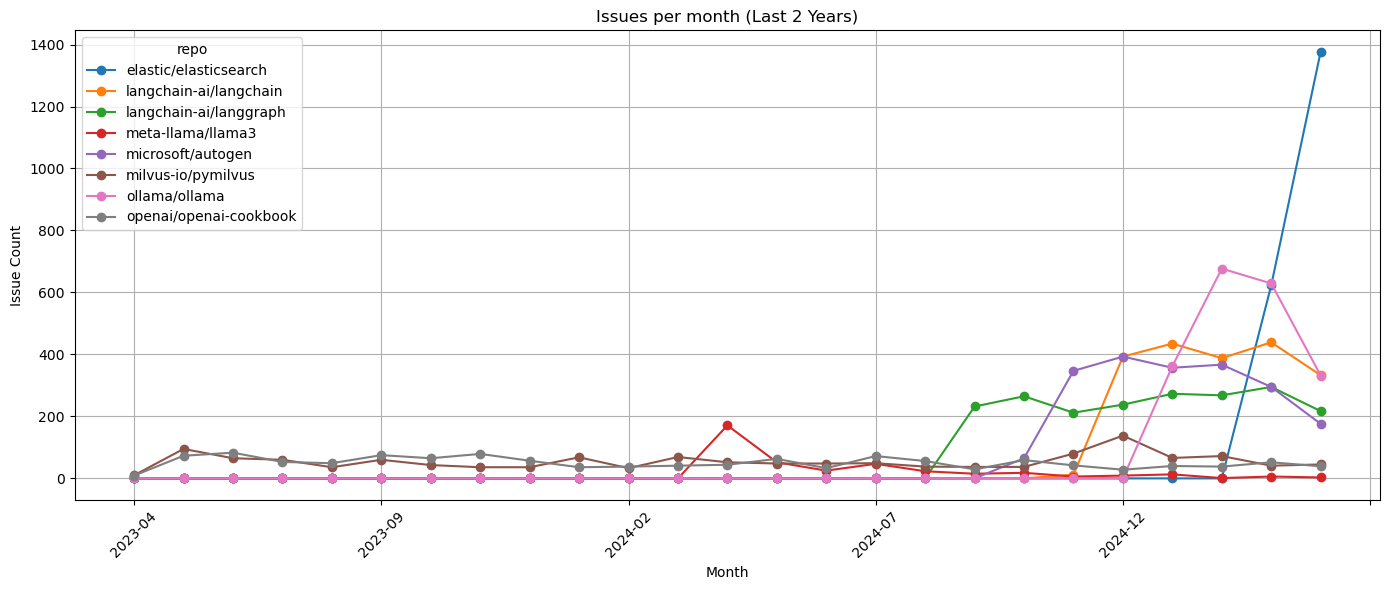

In [ ]:
#Add your code for requirement 2 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df = filter_recent_issues(df, days=730, mode="created_only")

# group by month
df["month"] = df["created_at"].dt.to_period("M").astype(str)
monthly_df = df.groupby(["repo", "month"]).size().reset_index(name="issue_count")

# pivot a table
pivot_df = monthly_df.pivot(index="month", columns="repo", values="issue_count").fillna(0)

plt.figure()
pivot_df.plot(kind="line", marker="o", figsize=(14, 6))
plt.title("Issues per month (Last 2 Years)")
plt.xlabel("Month")
plt.ylabel("Issue Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Forecasting/charts/line_chart.png")
plt.show()


<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 3
- A bar chart to plot the issues created for every month for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)


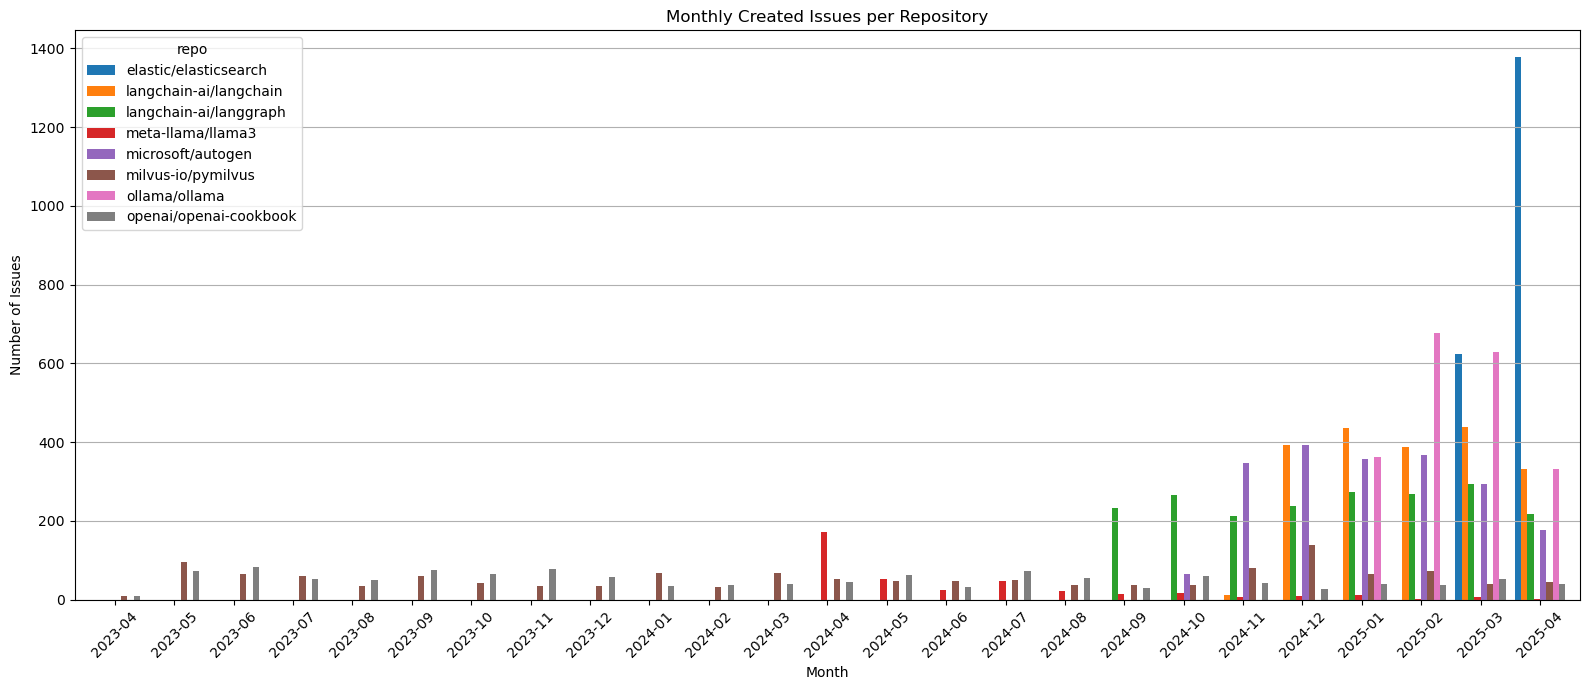

In [ ]:
#Add your code for requirement 3 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df = filter_recent_issues(df, days=730, mode="created_only")

# group by month
df["month"] = df["created_at"].dt.to_period("M").astype(str)
monthly_df = df.groupby(["repo", "month"]).size().reset_index(name="issue_count")

# pivot a table
pivot_df = monthly_df.pivot(index="month", columns="repo", values="issue_count").fillna(0)

pivot_df.plot(kind="bar", figsize=(16, 7), width=0.85)
plt.title("Monthly Created Issues per Repository")
plt.xlabel("Month")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")
plt.savefig("../Forecasting/charts/monthly_issues.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 4
- A bar chart to plot the starts for every repository
    
</div>

In [ ]:
import json
# Fetch Repo Metadata (for stars/forks)
repo_meta = {}
for repo in repos:
    url = f"https://api.github.com/repos/{repo}"
    response = requests.get(url)
    # NOTE: it seems headers is not rquired
    # response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        repo_meta[repo] = {
            "stars": data.get("stargazers_count", 0),
            "forks": data.get("forks_count", 0)
        }
    else:
        logger.error(f"Error fetching {repo}: {response.status_code} -- {response}")
        repo_meta[repo] = {"stars": None, "forks": None}


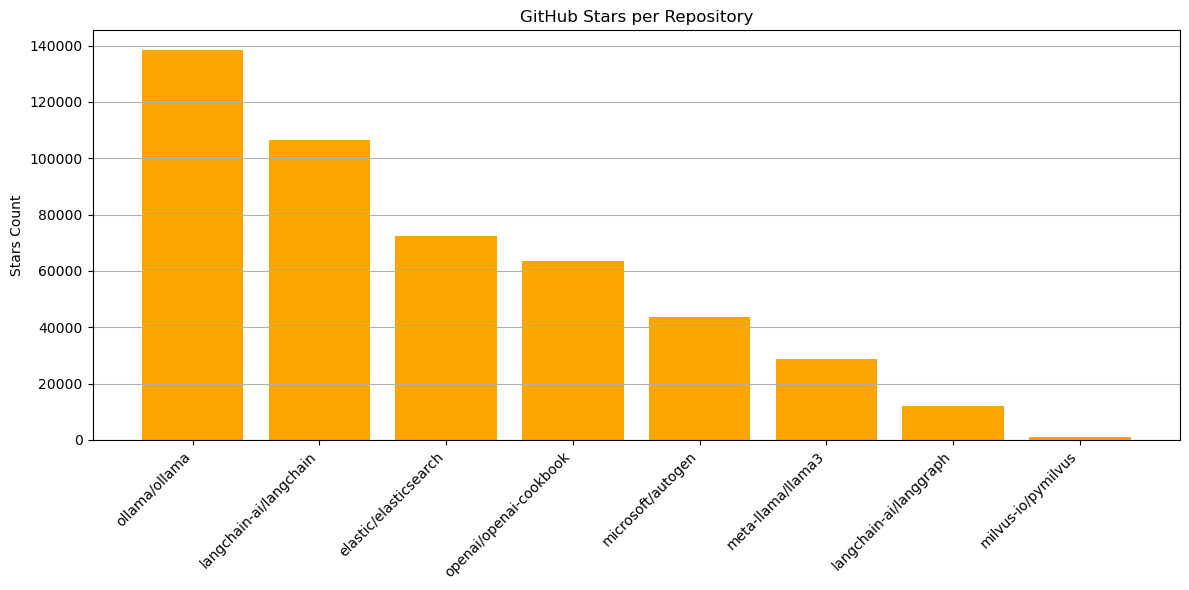

In [ ]:
#Add your code for requirement 4 in this cell

# get data
stars_data = {repo: meta["stars"] for repo, meta in repo_meta.items()}

# sort data
sorted_stars = dict(sorted(stars_data.items(
), key=lambda item: item[1] if item[1] is not None else -1, reverse=True))

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_stars.keys(), sorted_stars.values(), color="orange")
plt.title("GitHub Stars per Repository")
plt.ylabel("Stars Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/repo_stars.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 5
- A bar chart to plot the forks for every repository
    
</div>

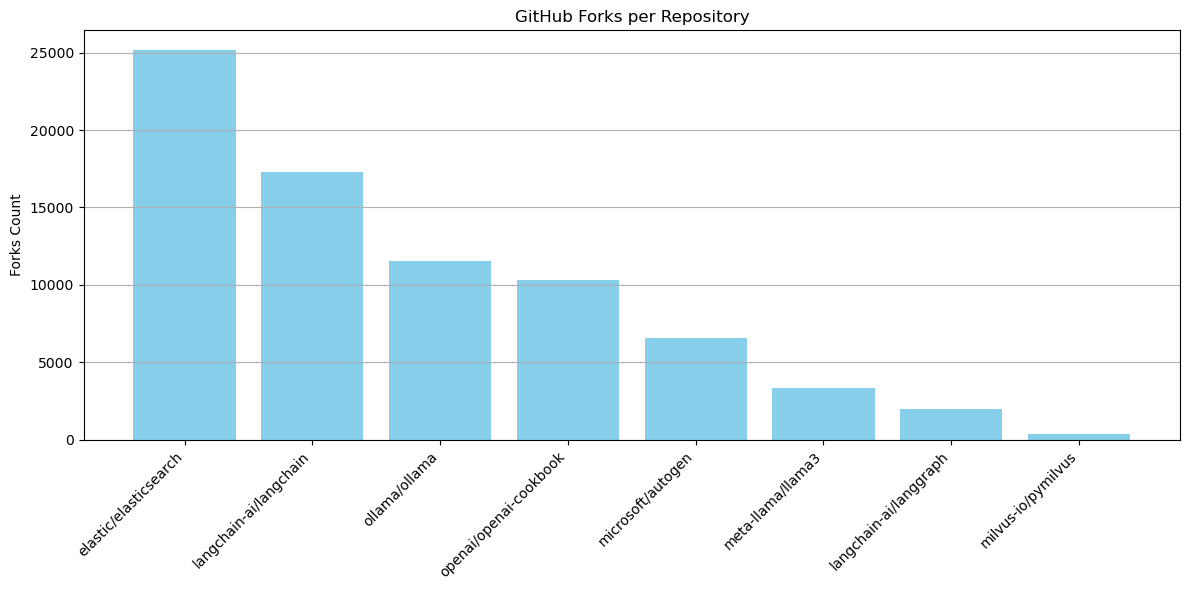

In [ ]:
#Add your code for requirement 5 in this cell

# get data
forks_data = {repo: meta["forks"] for repo, meta in repo_meta.items()}

# sort data
sorted_forks = dict(sorted(forks_data.items(
), key=lambda item: item[1] if item[1] is not None else -1, reverse=True))

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_forks.keys(), sorted_forks.values(), color="skyblue")
plt.title("GitHub Forks per Repository")
plt.ylabel("Forks Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/repo_forks.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 6
- A bar chart to plot the issues closed for every week for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)


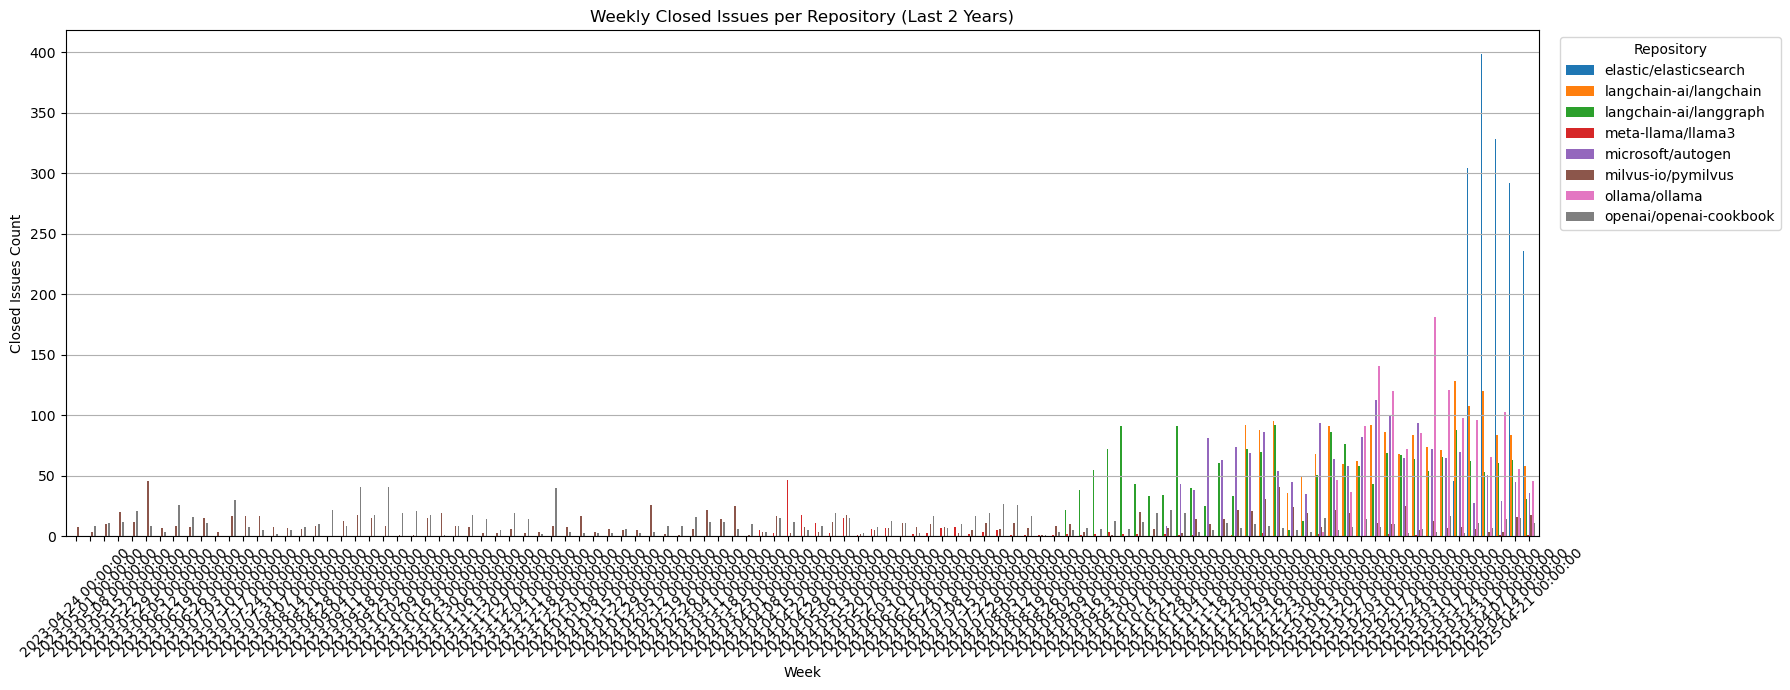

In [ ]:
#Add your code for requirement 6 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df = filter_recent_issues(df, days=730, mode="created_only")
df["repo"] = df["repo"].astype(str)

# use close at
closed_df = df.dropna(subset=["closed_at"]).copy()

# group by week
closed_df["week"] = closed_df["closed_at"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_closed_df = closed_df.groupby(["week", "repo"]).size().reset_index(name="closed_count")

# pivot a table
pivot_df = weekly_closed_df.pivot(index="week", columns="repo", values="closed_count").fillna(0)

# bar chart
pivot_df.plot(kind="bar", stacked=False, figsize=(18, 7), width=0.9)
plt.title("Weekly Closed Issues per Repository (Last 2 Years)")
plt.xlabel("Week")
plt.ylabel("Closed Issues Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.legend(title="Repository", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../Forecasting/charts/weekly_closed_issues.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 7
- A stack-bar Chart to plot the created and closed issues for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)


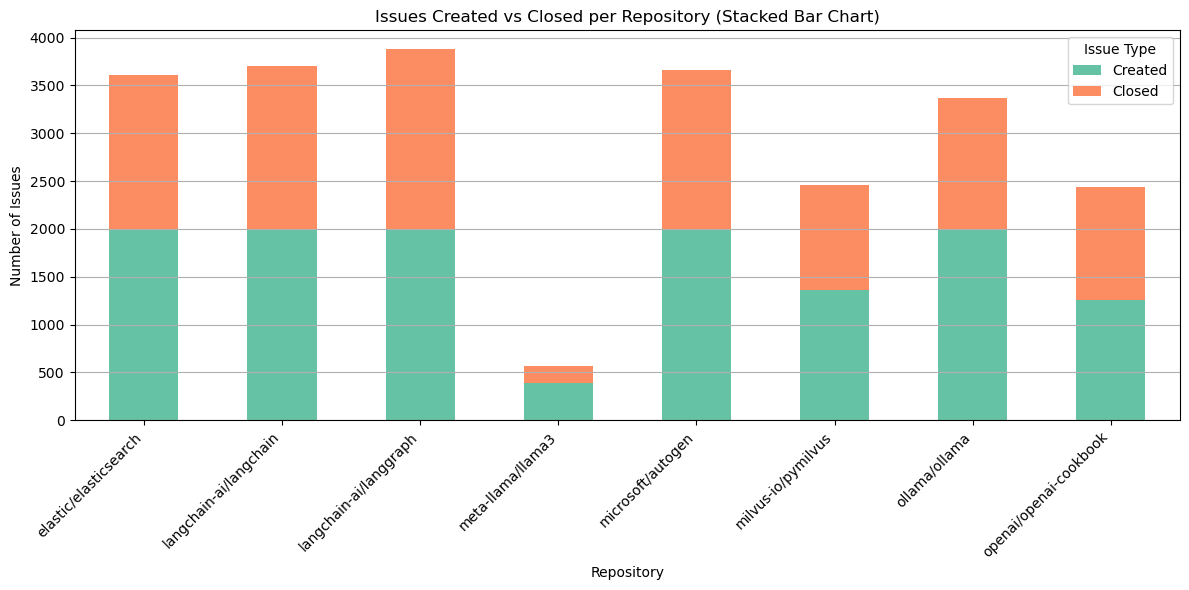

In [ ]:
#Add your code for requirement 7 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df = filter_recent_issues(df, days=730, mode="created_only")
df["repo"] = df["repo"].astype(str)


# get created and closed 
created_counts = df.groupby("repo")["created_at"].count()
closed_counts = df["closed_at"].notna().groupby(df["repo"]).sum()

# merge to one DataFrame
summary_df = pd.DataFrame({
    "Created": created_counts,
    "Closed": closed_counts
})

summary_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=["#66c2a5", "#fc8d62"])
plt.title("Issues Created vs Closed per Repository (Stacked Bar Chart)")
plt.xlabel("Repository")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Issue Type")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/created_vs_closed_stacked.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 8 (TENSORFLOW/KERAS LSTM)
- Use TensorFlow/Keras LSTM package to forecast the following for every repository  
</div>

<div class="alert alert-block alert-success">   
    
#### REQ8-1). The day of the week maximum number of issues created 
    
</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:28:52,907 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:28:52,907 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:28:54,135 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:28:54,135 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

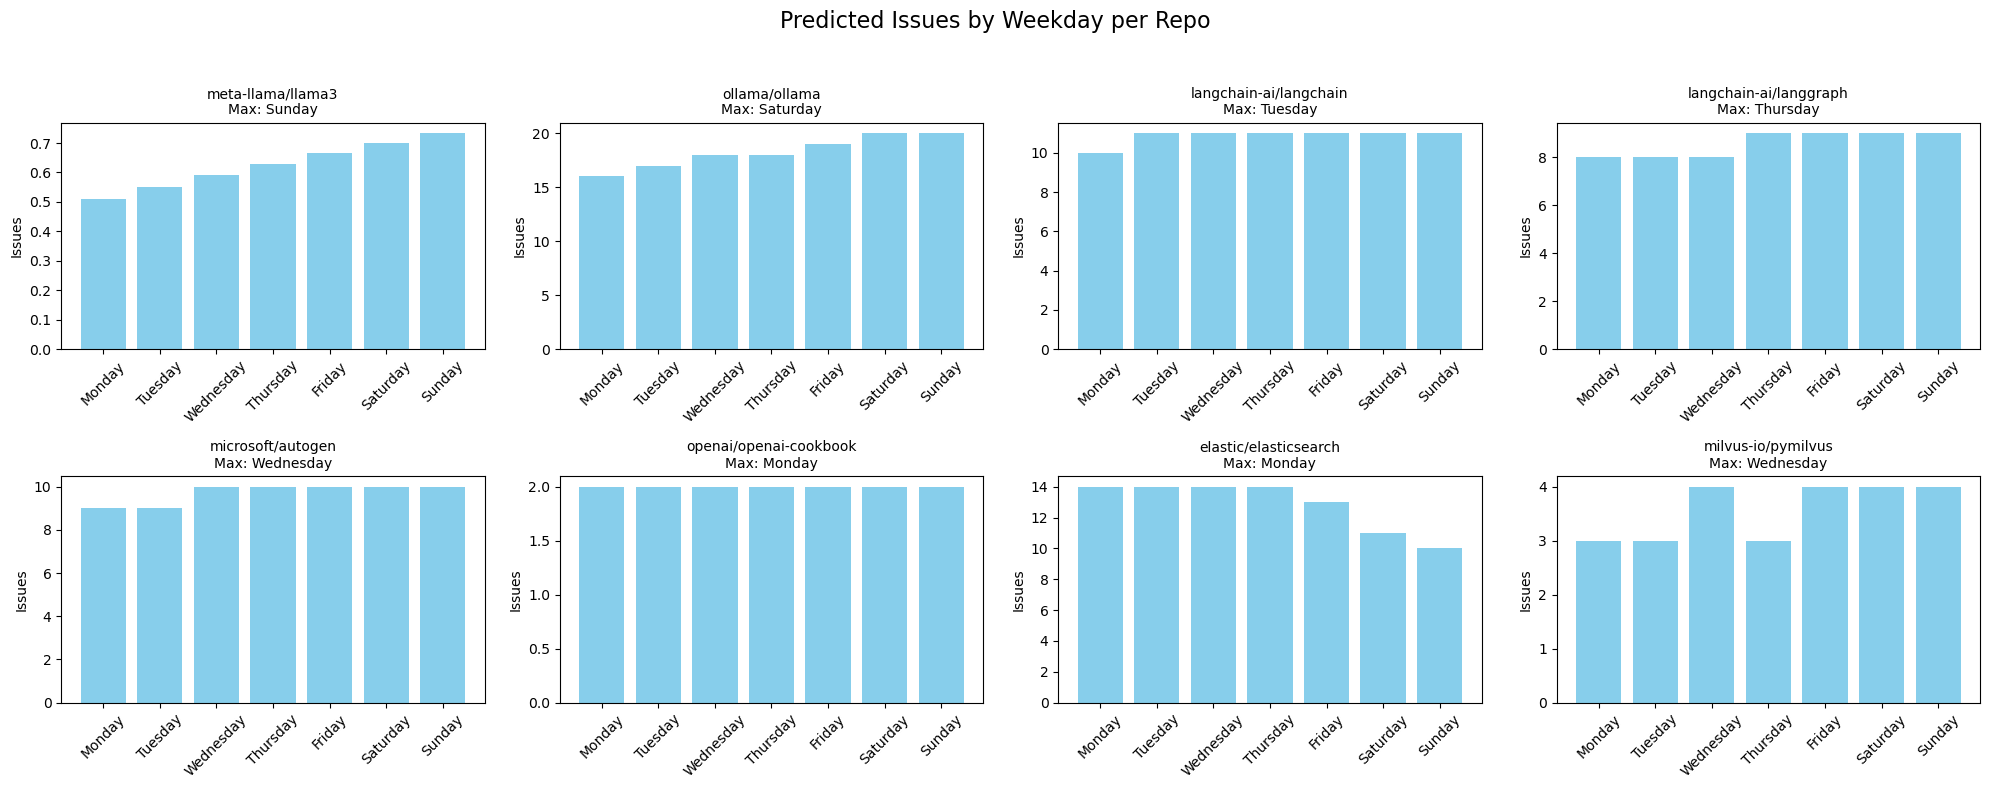

In [ ]:
#Add your code for requirement 8.1 in this cell

# get the original df (without filtering)
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    repo_df = df[df["repo"] == repo]
    daily_issues = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_issues = daily_issues.reindex(pd.date_range(
        daily_issues.index.min(), daily_issues.index.max()), fill_value=0)
    daily_issues.index.name = "date"

    # normalization
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_issues.values.reshape(-1, 1))

    # prepare LSTM input
    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict next 7 days
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    # inverse transform
    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_day = days[np.argmax(predictions)]

    # draw subplot
    ax = axs[idx]
    ax.bar(days, predictions, color='skyblue')
    ax.set_title(f"{repo}\nMax: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Issues")
    
    # save each repo plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions, color='skyblue')
    single_ax.set_title(f"{repo}\nMax: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/issues_created_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Predicted Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.savefig("../Forecasting/Tensorflow_LSTM/issues_created_weekday_forecast.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-2). The day of the week maximum number of issues closed 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:05,237 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:29:05,237 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:06,339 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:29:06,339 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

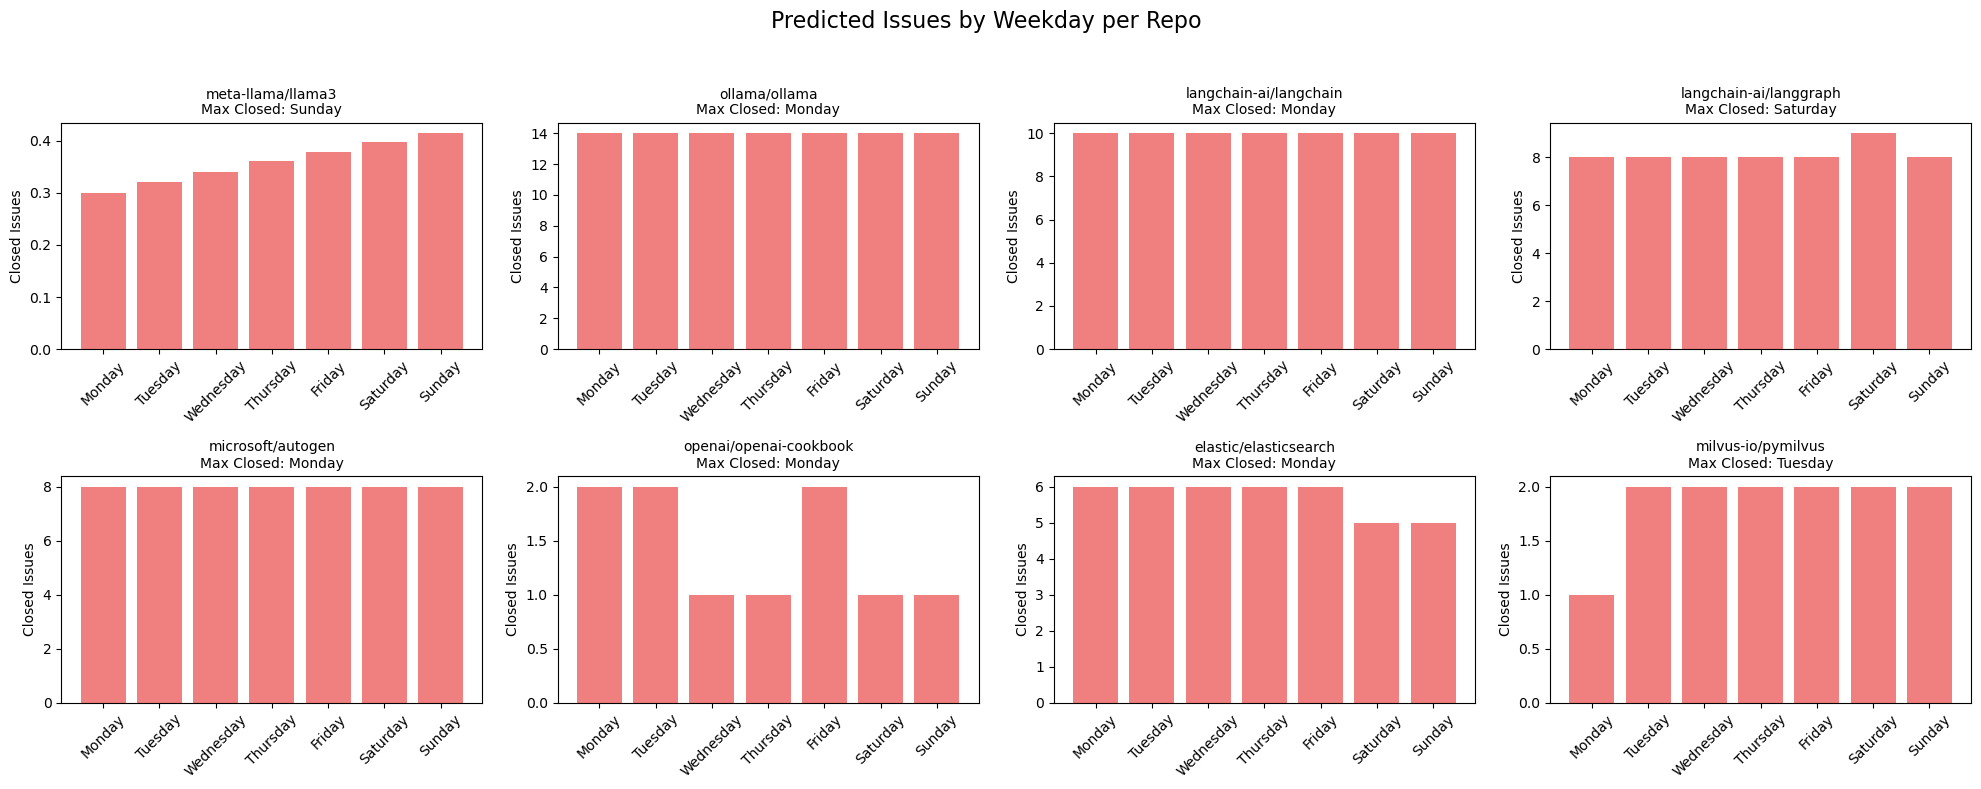

In [ ]:
#Add your code for requirement 8.2 in this cell

# get the original df (without filtering)
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(pd.date_range(
        daily_closed.index.min(), daily_closed.index.max()), fill_value=0)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_closed.values.reshape(-1, 1))

    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # next week
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_day = days[np.argmax(predictions)]

    ax.bar(days, predictions, color='lightcoral')
    ax.set_title(f"{repo}\nMax Closed: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    
    # save each repo plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions, color='lightcoral')
    single_ax.set_title(f"{repo}\nMax Closed: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/issues_closed_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Predicted Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.savefig("../Forecasting/Tensorflow_LSTM/issues_closed_weekday_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-3). The month of the year that has maximum number of issues closed 


</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:17,128 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:29:17,128 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:18,525 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:29:18,525 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

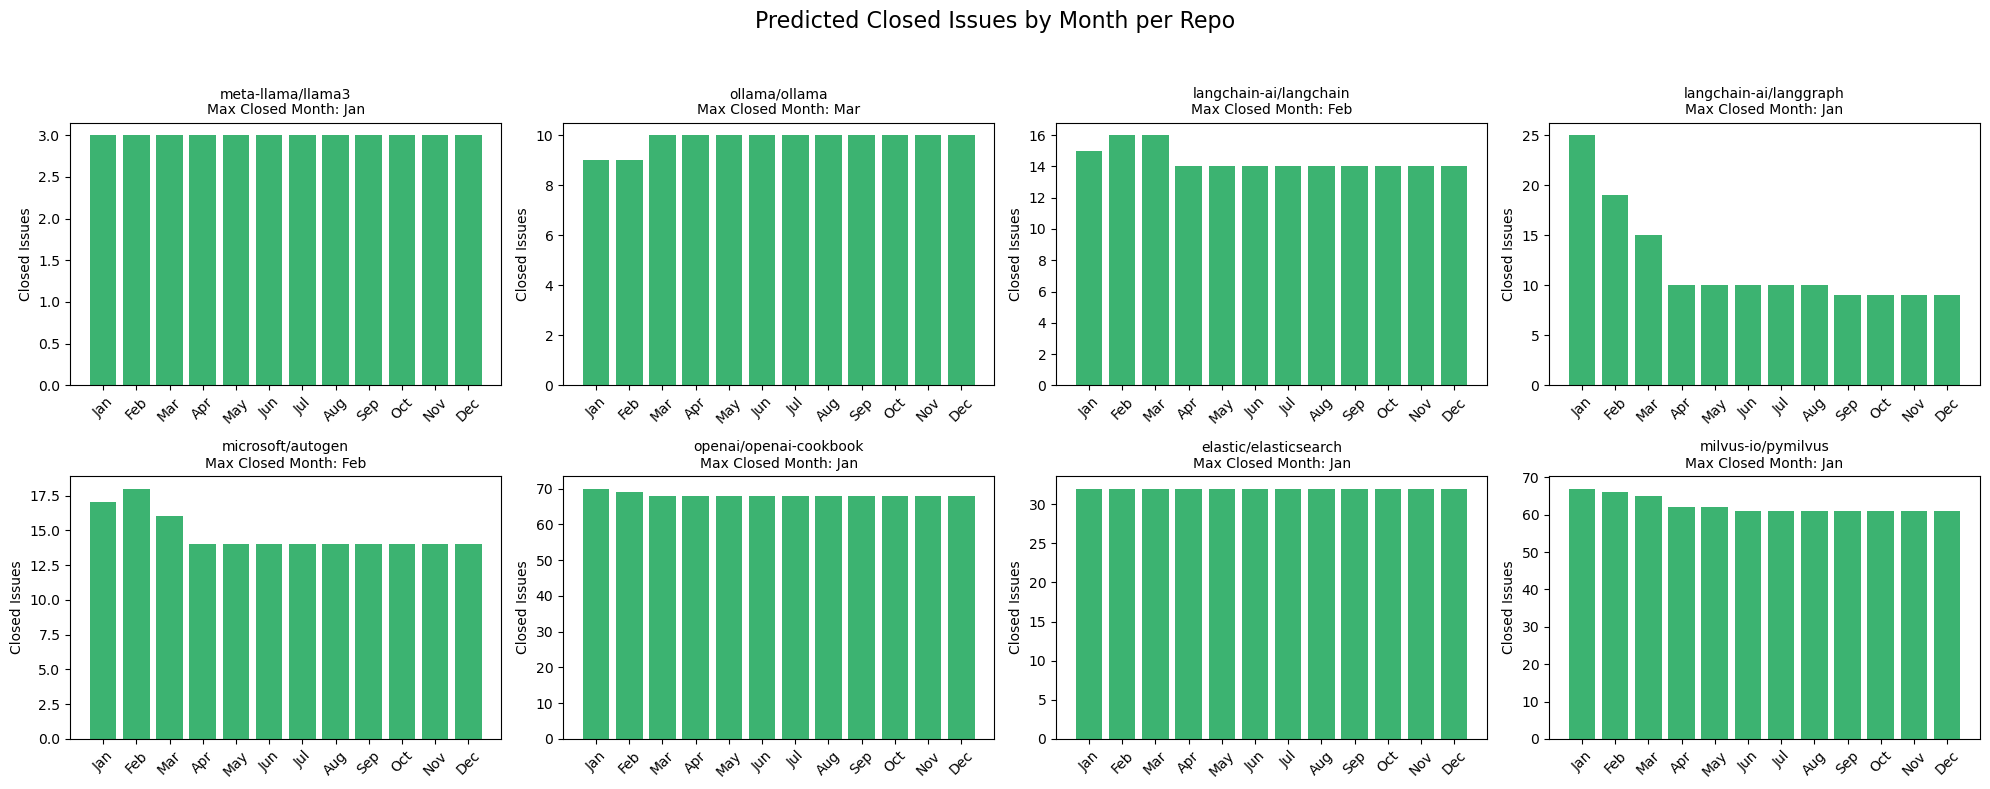

In [ ]:
#Add your code for requirement 8.3 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    # group by month
    repo_df["month"] = repo_df["closed_at"].dt.month
    monthly_counts = repo_df.groupby("month").size()
    monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly_counts.values.reshape(-1, 1))

    X, y = [], []
    # use every 3 months to predict
    lookback = 3
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict next 12 months
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(12):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_month = months[np.argmax(predictions)]

    ax.bar(months, predictions, color='mediumseagreen')
    ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    
    # save each repo plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(months, predictions, color='mediumseagreen')
    single_ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/issues_closed_monthly_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Predicted Closed Issues by Month per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/issues_closed_monthly_forecast.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-4). Plot the created issues forecast 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:32,646 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:29:32,646 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:29:36,583 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:29:36,583 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

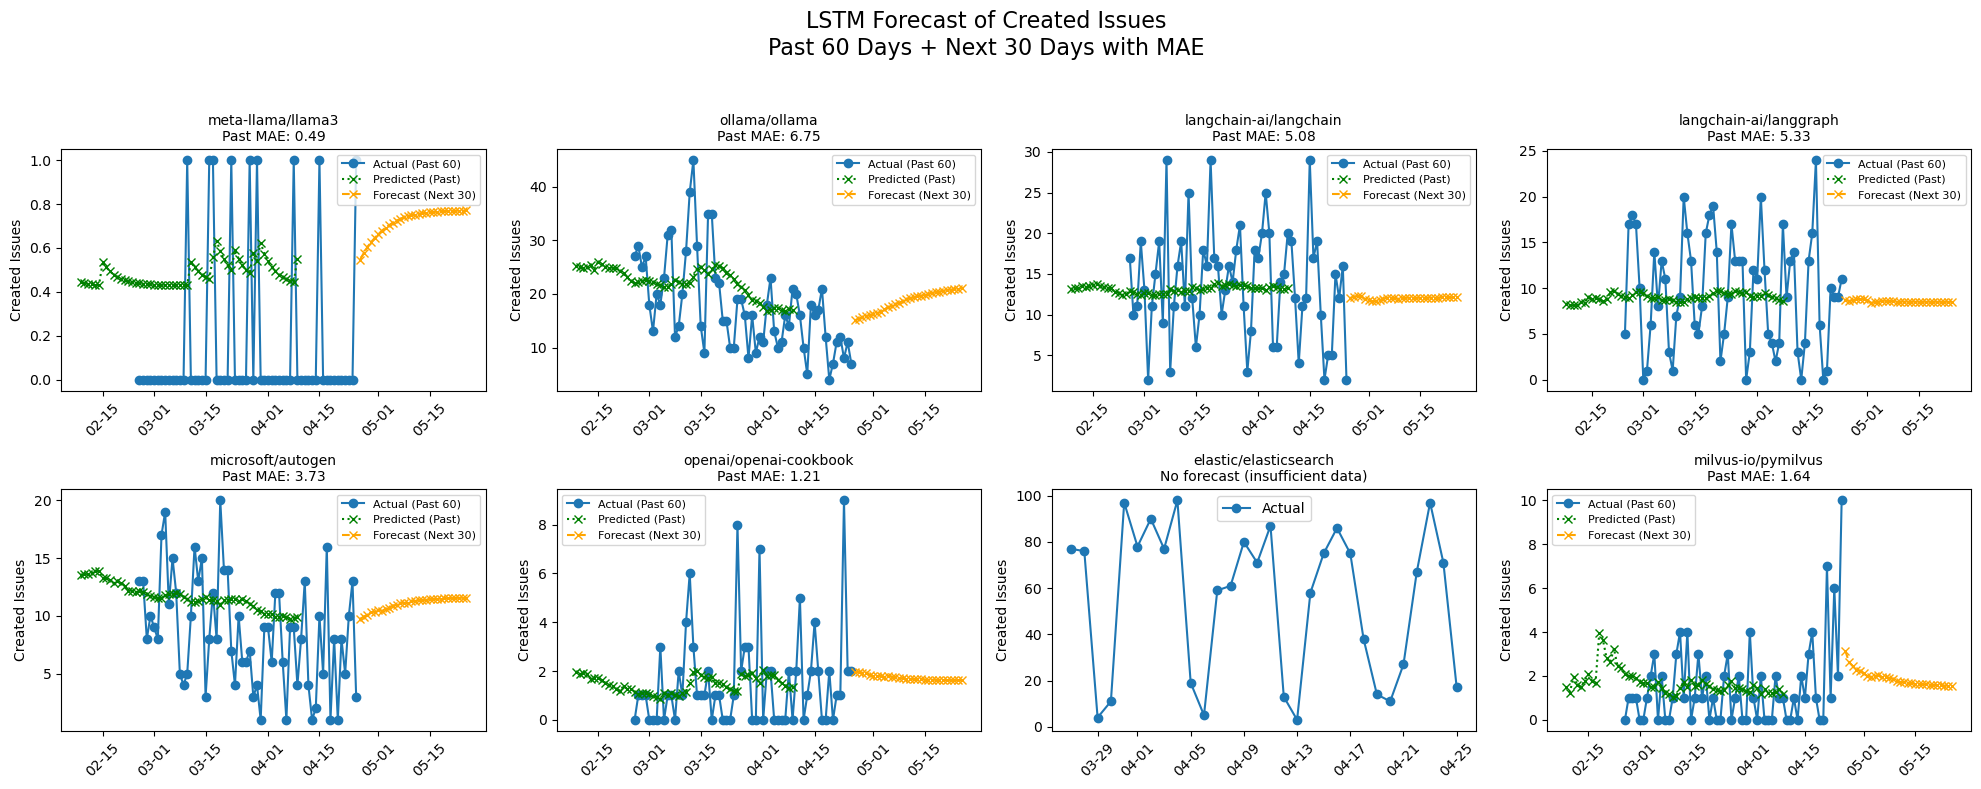

In [ ]:
#Add your code for requirement 8.4 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()
repo_names = df["repo"].unique()

lookback = 14
forecast_horizon = 30
eval_days = 60

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # daily group + fill missing
    daily = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily = daily.reindex(pd.date_range(daily.index.min(), daily.index.max()), fill_value=0)
    daily.index.name = "date"
    values = daily.values

    if len(values) < lookback + forecast_horizon + eval_days:
        past_days = 30 if len(values) >= 30 else len(values)
        ax.plot(daily.index[-past_days:], daily.values[-past_days:], label="Actual", marker='o')
        ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=10)
        ax.set_ylabel("Created Issues")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        continue

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values.reshape(-1, 1))

    # LSTM input
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # Model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict last 60 days
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(scaled) - (eval_days + forecast_horizon), len(scaled) - forecast_horizon):
        input_seq = scaled[i:i + lookback]
        target = scaled[i + lookback][0]
        input_seq = input_seq.reshape(1, lookback, 1)

        pred = model.predict(input_seq, verbose=0)[0][0]
        compare_preds.append(pred)
        compare_actuals.append(target)
        compare_dates.append(daily.index[i + lookback])

    compare_preds = scaler.inverse_transform(np.array(compare_preds).reshape(-1, 1)).flatten()
    compare_actuals = scaler.inverse_transform(np.array(compare_actuals).reshape(-1, 1)).flatten()
    compare_mae = mean_absolute_error(compare_actuals, compare_preds)

    # forecast next 30 days
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    past_dates = daily.index[-eval_days:]
    past_values = daily.values[-eval_days:]
    future_dates = pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

    # plot
    ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
    ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
    ax.plot(future_dates, preds, label="Forecast (Next 30)", linestyle="--", marker='x', color='orange')

    ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=10)
    ax.set_ylabel("Created Issues")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    
    # save each repo plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(values) < lookback + forecast_horizon + eval_days:
        single_ax.plot(daily.index[-past_days:], daily.values[-past_days:], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=12)
        single_ax.set_ylabel("Created Issues")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend()
    else:
        single_ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
        single_ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
        single_ax.plot(future_dates, preds, label="Forecast (Next 30)", linestyle="--", marker='x', color='orange')
        single_ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=12)
        single_ax.set_ylabel("Created Issues")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/created_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("LSTM Forecast of Created Issues\nPast 60 Days + Next 30 Days with MAE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/created_issues_forecast.png")
plt.show()



<div class="alert alert-block alert-success">   
    
#### REQ8-5). Plot the closed issues forecast 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:30:04,187 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:30:04,187 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:30:07,662 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:30:07,662 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

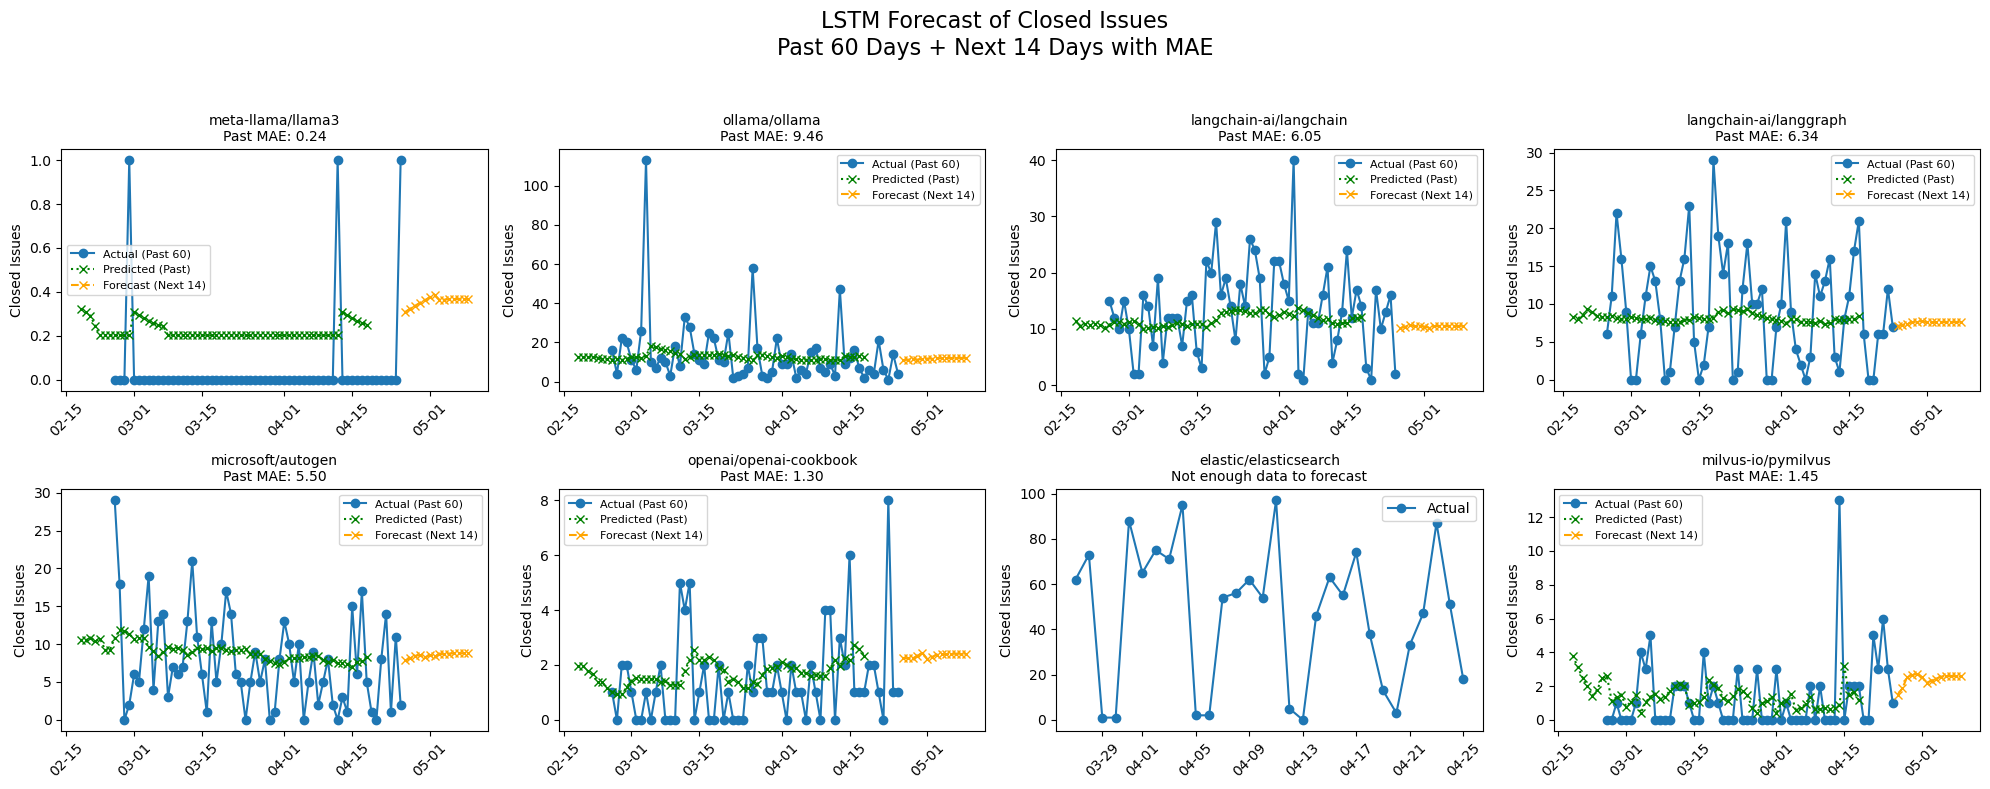

In [ ]:
#Add your code for requirement 8.5 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()
repo_names = df["repo"].unique()

lookback = 7
forecast_horizon = 14
eval_days = 60

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
        ax.set_title(repo, fontsize=10)
        ax.axis("off")
        continue

    # groupby date
    daily = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily = daily.reindex(pd.date_range(daily.index.min(), daily.index.max()), fill_value=0)
    daily.index.name = "date"
    values = daily.values

    if len(values) < lookback + forecast_horizon + eval_days:
        show_days = min(30, len(daily))
        ax.plot(daily.index[-show_days:], daily.values[-show_days:], label="Actual", marker='o')
        ax.set_title(f"{repo}\nNot enough data to forecast", fontsize=10)
        ax.set_ylabel("Closed Issues")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        continue

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values.reshape(-1, 1))

    # prepare input
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict past 60 days (for evaluation)
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(scaled) - (eval_days + forecast_horizon), len(scaled) - forecast_horizon):
        input_seq = scaled[i:i + lookback]
        target = scaled[i + lookback][0]
        input_seq = input_seq.reshape(1, lookback, 1)

        pred = model.predict(input_seq, verbose=0)[0][0]
        compare_preds.append(pred)
        compare_actuals.append(target)
        compare_dates.append(daily.index[i + lookback])

    compare_preds = scaler.inverse_transform(np.array(compare_preds).reshape(-1, 1)).flatten()
    compare_actuals = scaler.inverse_transform(np.array(compare_actuals).reshape(-1, 1)).flatten()
    compare_mae = mean_absolute_error(compare_actuals, compare_preds)

    # forecast next 14 days
    input_seq = scaled[-lookback:]
    future_preds = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        future_preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    past_dates = daily.index[-eval_days:]
    past_values = daily.values[-eval_days:]
    future_dates = pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

    # plot
    ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
    ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
    ax.plot(future_dates, future_preds, label="Forecast (Next 14)", linestyle="--", marker='x', color='orange')

    ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=10)
    ax.set_ylabel("Closed Issues")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    
    # save each repo plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(values) < lookback + forecast_horizon + eval_days:
        single_ax.plot(daily.index[-show_days:], daily.values[-show_days:], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nNot enough data to forecast", fontsize=12)
        single_ax.set_ylabel("Closed Issues")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend()
    else:
        single_ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
        single_ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
        single_ax.plot(future_dates, future_preds, label="Forecast (Next 14)", linestyle="--", marker='x', color='orange')
        single_ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=12)
        single_ax.set_ylabel("Closed Issues")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/closed_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("LSTM Forecast of Closed Issues\nPast 60 Days + Next 14 Days with MAE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/closed_issues_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-6). Plot the pulls forecast 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:30:30,820 - __main__ - INFO - Saved meta-llama_llama3
2025-04-25 03:30:30,820 - __main__ - INFO - Saved meta-llama_llama3
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-25 03:30:34,079 - __main__ - INFO - Saved ollama_ollama
2025-04-25 03:30:34,079 - __main__ - INFO - Saved ollama_ollama
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argu

KeyboardInterrupt: 

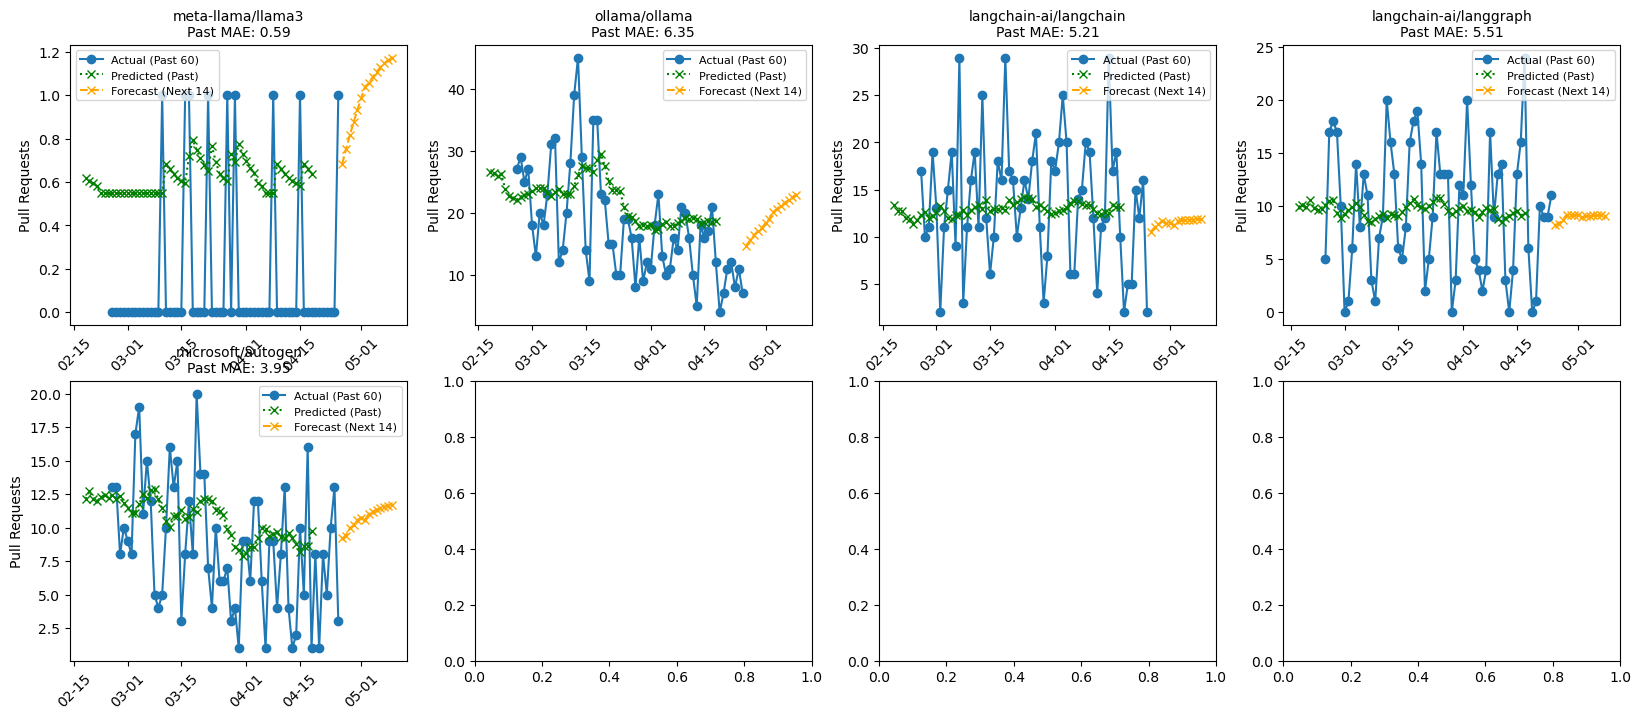

In [ ]:
#Add your code for requirement 8.6 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

# check for PR column
if "pull_request" not in df.columns:
    logger.info("No 'pull_request' column found.")
    df["is_pr"] = False
else:
    df["is_pr"] = df["pull_request"].notna()

df_pr = df[df["is_pr"]]
repo_names = df_pr["repo"].unique()

lookback = 7
forecast_horizon = 14
eval_days = 60

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_pr[df_pr["repo"] == repo]

    if repo_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
        ax.set_title(repo, fontsize=10)
        ax.axis("off")
        continue

    # groupby day
    daily = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily = daily.reindex(pd.date_range(daily.index.min(), daily.index.max()), fill_value=0)
    daily.index.name = "date"
    values = daily.values

    if len(values) < lookback + forecast_horizon + eval_days:
        show_days = min(30, len(daily))
        ax.plot(daily.index[-show_days:], daily.values[-show_days:], label="Actual", marker='o')
        ax.set_title(f"{repo}\nNot enough data", fontsize=10)
        ax.set_ylabel("Pull Requests")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        continue

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values.reshape(-1, 1))

    # prepare input
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM Model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict last 60 days (for evaluation)
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(scaled) - (eval_days + forecast_horizon), len(scaled) - forecast_horizon):
        input_seq = scaled[i:i + lookback]
        target = scaled[i + lookback][0]
        input_seq = input_seq.reshape(1, lookback, 1)

        pred = model.predict(input_seq, verbose=0)[0][0]
        compare_preds.append(pred)
        compare_actuals.append(target)
        compare_dates.append(daily.index[i + lookback])

    compare_preds = scaler.inverse_transform(np.array(compare_preds).reshape(-1, 1)).flatten()
    compare_actuals = scaler.inverse_transform(np.array(compare_actuals).reshape(-1, 1)).flatten()
    compare_mae = mean_absolute_error(compare_actuals, compare_preds)

    # predict next 14 days
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # plot
    past_dates = daily.index[-eval_days:]
    past_values = daily.values[-eval_days:]
    future_dates = pd.date_range(daily.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

    ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
    ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
    ax.plot(future_dates, preds, label="Forecast (Next 14)", linestyle="--", marker='x', color='orange')

    ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=10)
    ax.set_ylabel("Pull Requests")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    
    # save each repo PR forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(values) < lookback + forecast_horizon + eval_days:
        single_ax.plot(daily.index[-show_days:], daily.values[-show_days:], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nNot enough data", fontsize=12)
        single_ax.set_ylabel("Pull Requests")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend()
    else:
        single_ax.plot(past_dates, past_values, label="Actual (Past 60)", marker='o')
        single_ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
        single_ax.plot(future_dates, preds, label="Forecast (Next 14)", linestyle="--", marker='x', color='orange')
        single_ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=12)
        single_ax.set_ylabel("Pull Requests")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/pull_requests_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("LSTM Forecast of Pull Requests\nPast 60 Days + Next 14 Days with MAE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/pull_requests_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-7). Plot the commits forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved ollama_ollama


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langgraph


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved microsoft_autogen


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved openai_openai-cookbook


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved elastic_elasticsearch


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved milvus-io_pymilvus


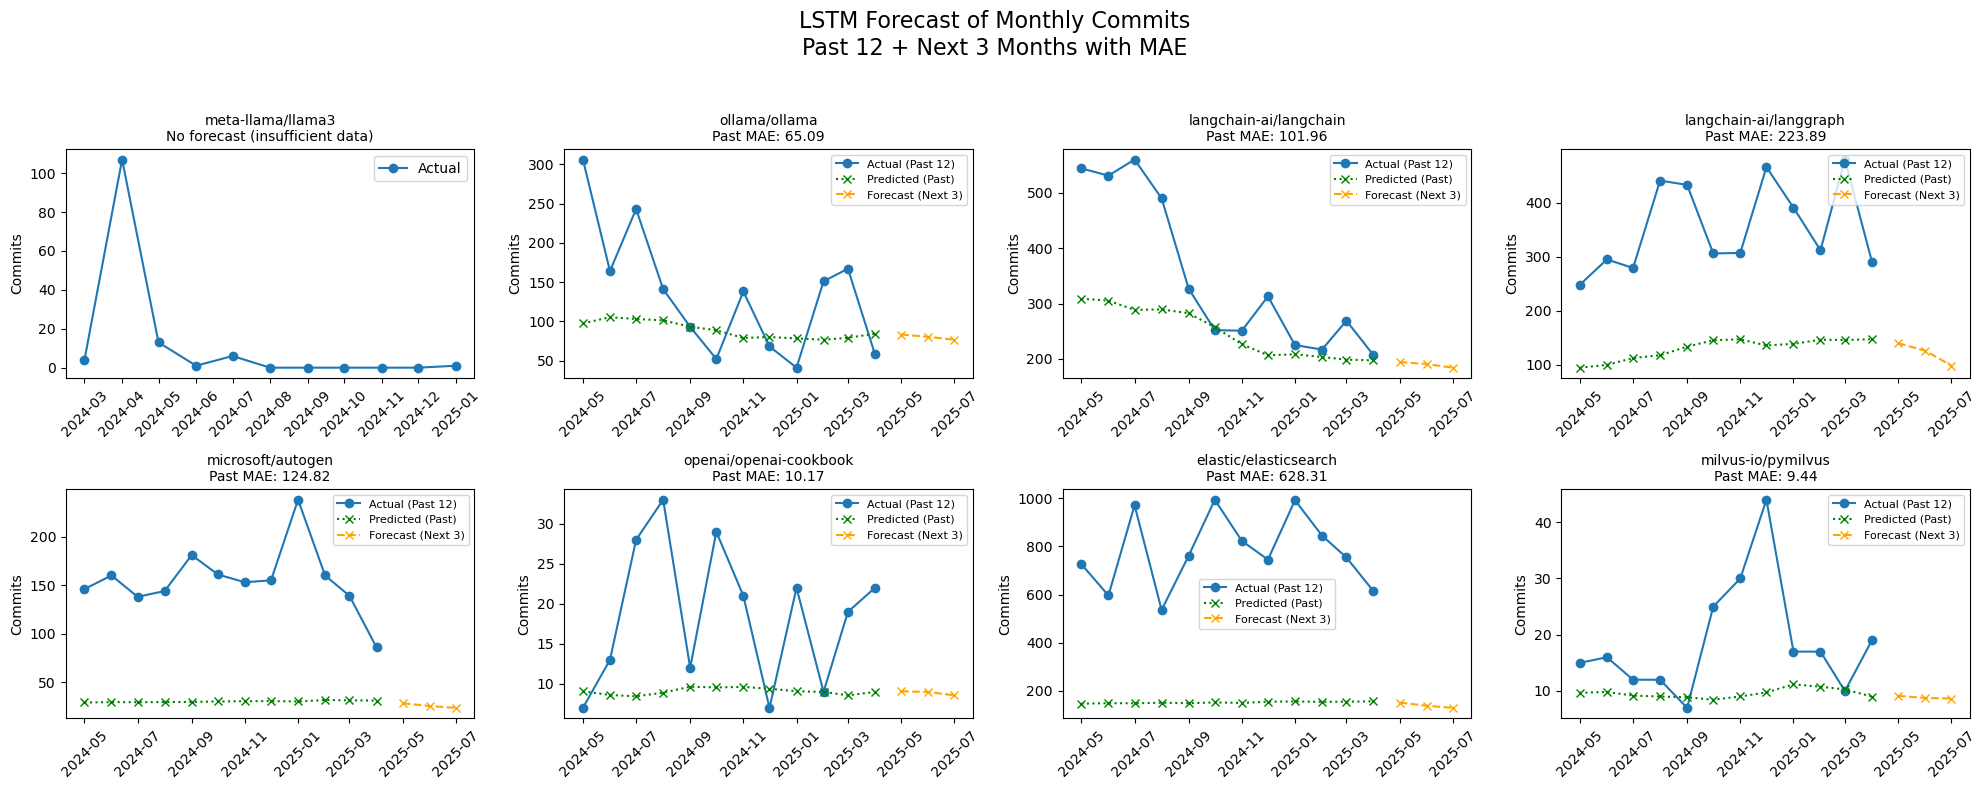

In [ ]:
#Add your code for requirement 8.7 in this cell

# df_commits_data = pd.read_csv("commits.csv")
df_commits_data["date"] = pd.to_datetime(df_commits_data["date"])
repo_names = df_commits_data["repo"].unique()

lookback = 3
forecast_horizon = 3
eval_months = 12  # evaluate last 12 months

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_commits_data[df_commits_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # monthly commit counts
    monthly = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly.index = monthly.index.to_timestamp()

    if monthly.empty or pd.isna(monthly.index.min()) or pd.isna(monthly.index.max()):
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly.index.min(), monthly.index.max(), freq="MS")
    monthly = monthly.reindex(full_index, fill_value=0)

    # if data too short need full modeling
    if len(monthly) < lookback + forecast_horizon + eval_months:
        past_months = 12 if len(monthly) >= 12 else len(monthly)
        ax.plot(monthly.index[-past_months:], monthly.values[-past_months:], label="Actual", marker='o')
        ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=10)
        ax.set_ylabel("Commits")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        continue

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly.values.reshape(-1, 1))

    # training
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, verbose=0)

    # predict last 12 months
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(scaled) - (eval_months + forecast_horizon), len(scaled) - forecast_horizon):
        input_seq = scaled[i:i + lookback]
        target = scaled[i + lookback][0]
        input_seq = input_seq.reshape(1, lookback, 1)
        pred = model.predict(input_seq, verbose=0)[0][0]
        compare_preds.append(pred)
        compare_actuals.append(target)
        compare_dates.append(monthly.index[i + lookback])

    compare_preds = scaler.inverse_transform(np.array(compare_preds).reshape(-1, 1)).flatten()
    compare_actuals = scaler.inverse_transform(np.array(compare_actuals).reshape(-1, 1)).flatten()
    compare_mae = mean_absolute_error(compare_actuals, compare_preds)

    # forecast future
    input_seq = scaled[-lookback:]
    future_preds = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        future_preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    # plot
    ax.plot(monthly.index[-eval_months:], monthly.values[-eval_months:], label="Actual (Past 12)", marker='o')
    ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
    future_dates = pd.date_range(monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq="MS")
    ax.plot(future_dates, future_preds, label="Forecast (Next 3)", linestyle="--", marker='x', color='orange')

    ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=10)
    ax.set_ylabel("Commits")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    
    # save each repo commit forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(monthly) < lookback + forecast_horizon + eval_months:
        past_months = 12 if len(monthly) >= 12 else len(monthly)
        single_ax.plot(monthly.index[-past_months:], monthly.values[-past_months:], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=12)
        single_ax.set_ylabel("Commits")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend()
    else:
        single_ax.plot(monthly.index[-eval_months:], monthly.values[-eval_months:], label="Actual (Past 12)", marker='o')
        single_ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
        single_ax.plot(future_dates, future_preds, label="Forecast (Next 3)", linestyle="--", marker='x', color='orange')
        single_ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=12)
        single_ax.set_ylabel("Commits")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/monthly_commits_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("LSTM Forecast of Monthly Commits\nPast 12 + Next 3 Months with MAE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/monthly_commits_forecast.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-8). Plot the branches forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved meta-llama_llama3


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved ollama_ollama


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langgraph


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved microsoft_autogen


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved openai_openai-cookbook


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved elastic_elasticsearch


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved milvus-io_pymilvus


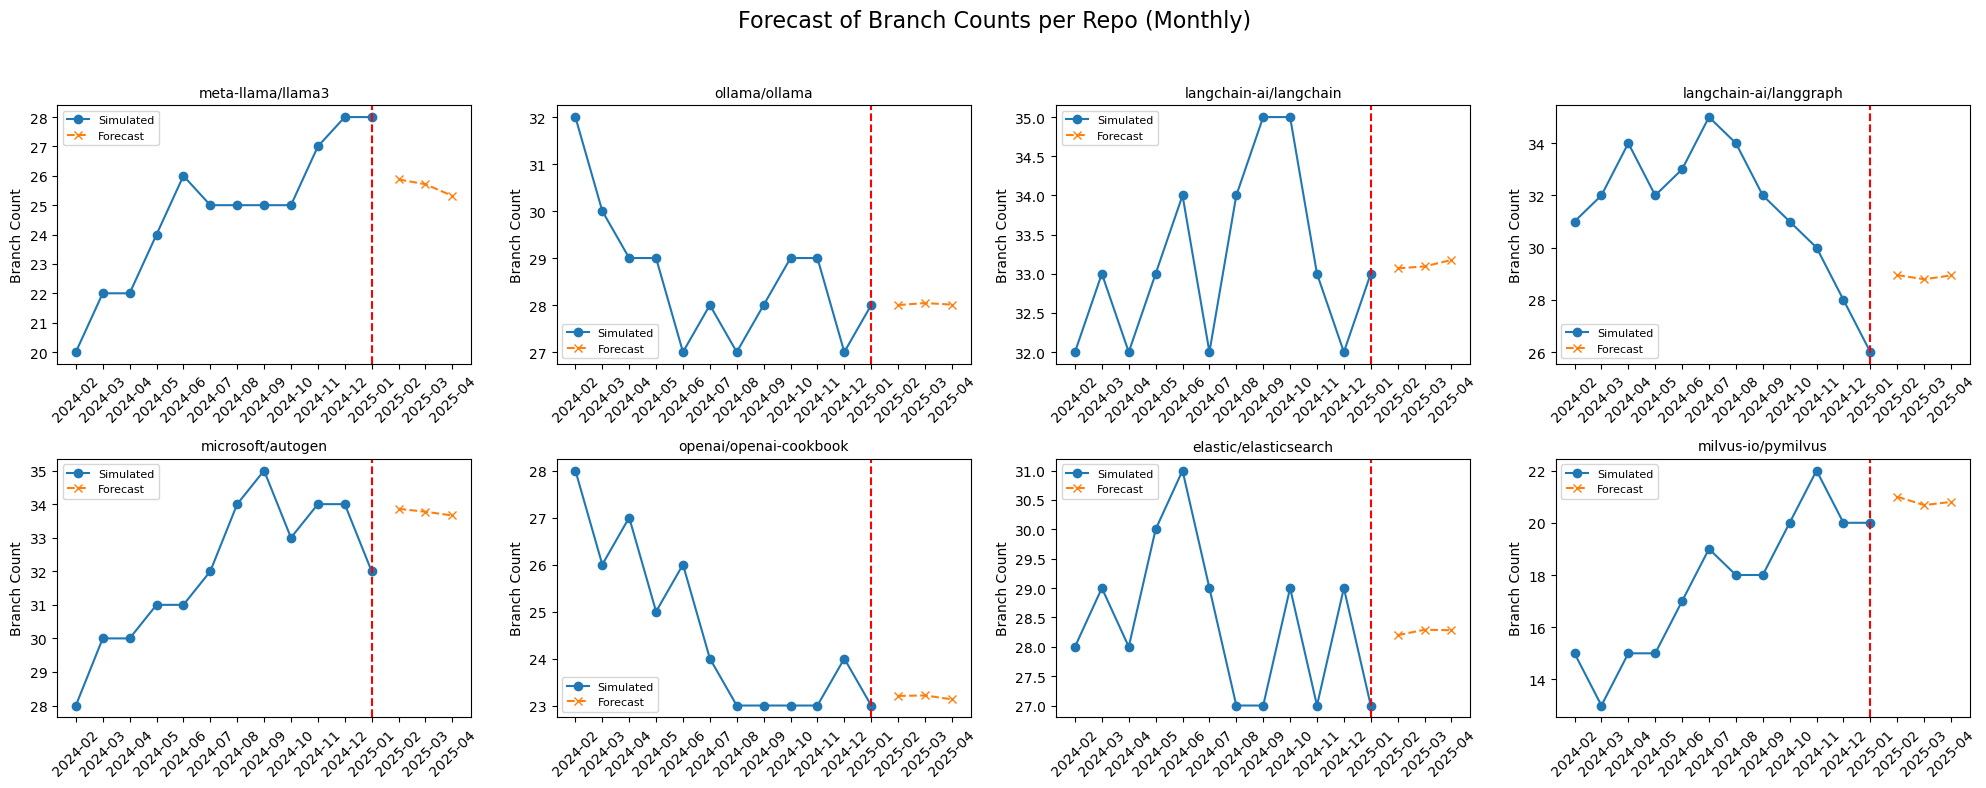

In [ ]:
# Add your code for requirement 8.8 in this cell

# Note: GitHub does not provide branch statistics over time with dates. 
# The /branches API only returns a current total count.
# To generate a time series suitable for forecasting,
# I simulate monthly branch counts using the latest known value and add random noise. 
# This lets me train an LSTM model and predict the next 3 months.

repos = df_branches_data["repo"].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_branches_data[df_branches_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate a historical monthly series using current value and noise.
    latest = row["branch_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-2, 3, size=12).cumsum(), 0, None)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(simulated_series.reshape(-1, 1))

    # LSTM data
    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # next 3 months
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(3):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    all_values = np.concatenate([simulated_series, preds])

    
    months = pd.date_range(end=pd.Timestamp.today(), periods=len(all_values), freq="MS").strftime("%Y-%m")
    ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    ax.plot(months[len(simulated_series):], preds, label="Forecast", marker="x", linestyle="--")
    ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Branch Count")
    ax.legend(fontsize=8)
    
    # save each repo branch forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    single_ax.plot(months[len(simulated_series):], preds, label="Forecast", marker="x", linestyle="--")
    single_ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    single_ax.set_title(repo, fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Branch Count")
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/monthly_branches_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)


fig.suptitle("Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/monthly_branches_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-9). Plot the contributors forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved meta-llama_llama3


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved ollama_ollama


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langgraph


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved microsoft_autogen


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved openai_openai-cookbook


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved elastic_elasticsearch


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved milvus-io_pymilvus


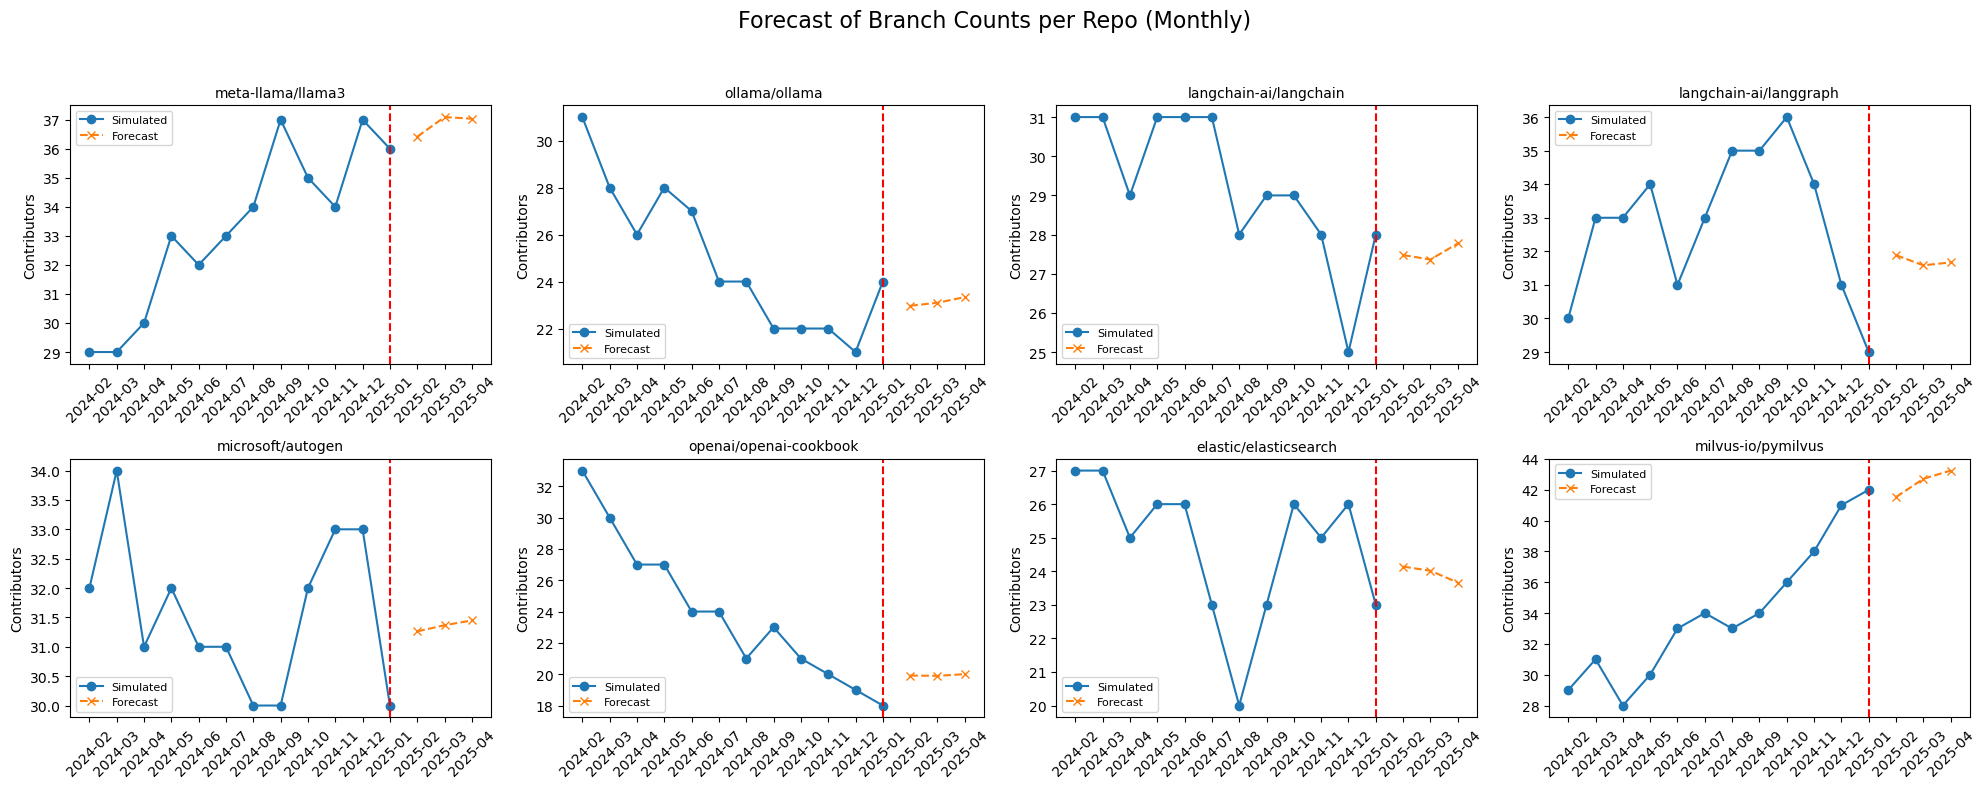

In [ ]:
#Add your code for requirement 8.9 in this cell

# Note: GitHub does not provide contributor statistics over time with dates. 
# The /contributors API only returns a current total count.
# To generate a time series suitable for forecasting,
# I simulate monthly contributor counts using the latest known value and add random noise. 
# This lets me train an LSTM model and predict the next 3 months.

# df_contributors_data = pd.read_csv("data/contributors.csv")
repos = df_contributors_data["repo"].unique()

# create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_contributors_data[df_contributors_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate a historical monthly series using current value and noise.
    latest = row["contributor_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-3, 4, size=12).cumsum(), 0, None)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(simulated_series.reshape(-1, 1))

    # LSTM data
    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Predict next 3 months
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(3):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    all_values = np.concatenate([simulated_series, preds])

    # Plot
    months = pd.date_range(end=pd.Timestamp.today(), periods=len(all_values), freq="MS").strftime("%Y-%m")
    ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    ax.plot(months[len(simulated_series):], preds, label="Forecast", linestyle="--", marker="x")
    ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Contributors")
    ax.legend(fontsize=8)
    
    # save each repo contributor forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    single_ax.plot(months[len(simulated_series):], preds, label="Forecast", linestyle="--", marker="x")
    single_ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    single_ax.set_title(repo, fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Contributors")
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/monthly_contributors_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)
    
fig.suptitle("Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/monthly_contributors_forecast.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-10). Plot the releases forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved ollama_ollama


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved microsoft_autogen


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved elastic_elasticsearch


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Saved milvus-io_pymilvus


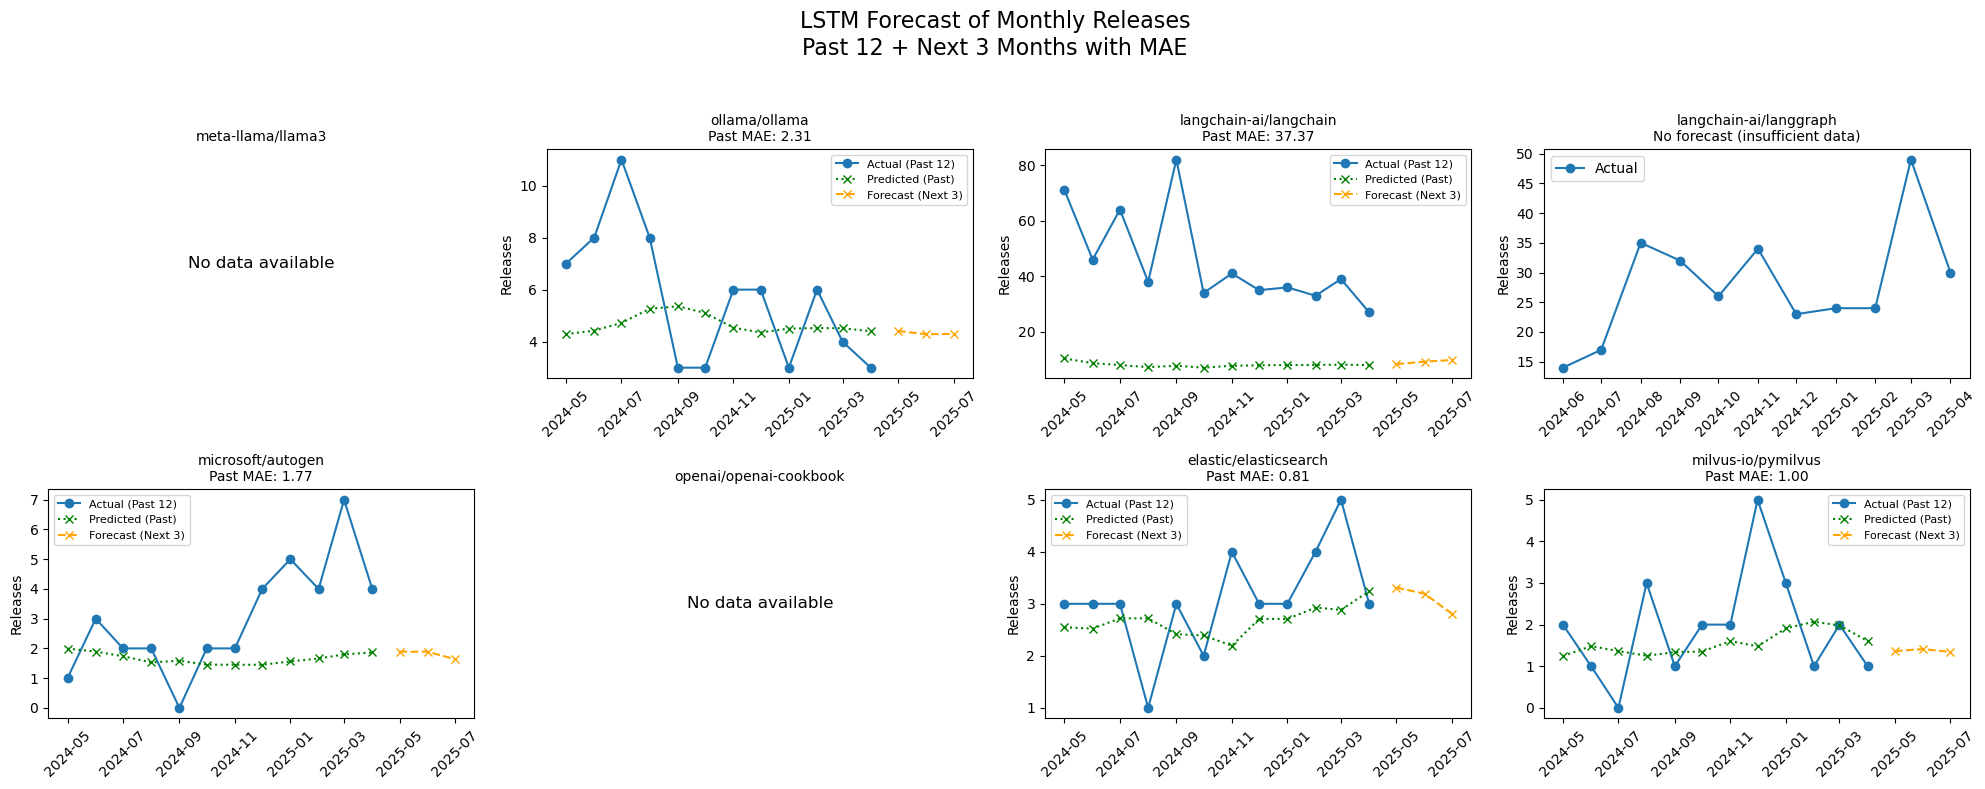

In [ ]:
# Add your code for requirement 8.10 in this cell

# df_releases_data = pd.read_csv("data/releases.csv")
df_releases_data["date"] = pd.to_datetime(df_releases_data["date"])
    
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

lookback = 3
forecast_horizon = 3
eval_months = 12  # evaluate recent 12 months

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_releases_data[df_releases_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    monthly = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly.index = monthly.index.to_timestamp()

    if monthly.empty or pd.isna(monthly.index.min()) or pd.isna(monthly.index.max()):
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    full_index = pd.date_range(monthly.index.min(), monthly.index.max(), freq="MS")
    monthly = monthly.reindex(full_index, fill_value=0)

    if len(monthly) < lookback + forecast_horizon + eval_months:
        past_months = 12 if len(monthly) >= 12 else len(monthly)
        ax.plot(monthly.index[-past_months:], monthly.values[-past_months:], label="Actual", marker='o')
        ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=10)
        ax.set_ylabel("Releases")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        continue

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly.values.reshape(-1, 1))

    # LSTM input
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, verbose=0)

    # predict past 12 months
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(scaled) - (eval_months + forecast_horizon), len(scaled) - forecast_horizon):
        input_seq = scaled[i:i + lookback]
        target = scaled[i + lookback][0]
        input_seq = input_seq.reshape(1, lookback, 1)
        pred = model.predict(input_seq, verbose=0)[0][0]
        compare_preds.append(pred)
        compare_actuals.append(target)
        compare_dates.append(monthly.index[i + lookback])

    compare_preds = scaler.inverse_transform(np.array(compare_preds).reshape(-1, 1)).flatten()
    compare_actuals = scaler.inverse_transform(np.array(compare_actuals).reshape(-1, 1)).flatten()
    compare_mae = mean_absolute_error(compare_actuals, compare_preds)

    # forecast future 3 months
    input_seq = scaled[-lookback:]
    future_preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        future_preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    # plot
    ax.plot(monthly.index[-eval_months:], monthly.values[-eval_months:], label="Actual (Past 12)", marker='o')
    ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
    future_dates = pd.date_range(monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq="MS")
    ax.plot(future_dates, future_preds, label="Forecast (Next 3)", linestyle="--", marker='x', color='orange')

    ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=10)
    ax.set_ylabel("Releases")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)
    
    # save each repo release forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(monthly) < lookback + forecast_horizon + eval_months:
        past_months = 12 if len(monthly) >= 12 else len(monthly)
        single_ax.plot(monthly.index[-past_months:], monthly.values[-past_months:], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nNo forecast (insufficient data)", fontsize=12)
        single_ax.set_ylabel("Releases")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend()
    else:
        single_ax.plot(monthly.index[-eval_months:], monthly.values[-eval_months:], label="Actual (Past 12)", marker='o')
        single_ax.plot(compare_dates, compare_preds, label="Predicted (Past)", linestyle=":", marker='x', color='green')
        single_ax.plot(future_dates, future_preds, label="Forecast (Next 3)", linestyle="--", marker='x', color='orange')
        single_ax.set_title(f"{repo}\nPast MAE: {compare_mae:.2f}", fontsize=12)
        single_ax.set_ylabel("Releases")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Tensorflow_LSTM/monthly_releases_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("LSTM Forecast of Monthly Releases\nPast 12 + Next 3 Months with MAE", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/monthly_releases_forecast.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 9 (FACEBOOK/PROPHET)
- Use Facebook/Prophet package to forecast the following for every repository
    
</div>

<div class="alert alert-block alert-warning">   
    
#### REQ9-1). The day of the week maximum number of issues created 
    
</div>

02:10:58 - cmdstanpy - INFO - Chain [1] start processing
02:10:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:10:58 - cmdstanpy - INFO - Chain [1] start processing
02:10:58 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:10:59 - cmdstanpy - INFO - Chain [1] start processing
02:10:59 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:10:59 - cmdstanpy - INFO - Chain [1] start processing
02:10:59 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:10:59 - cmdstanpy - INFO - Chain [1] start processing
02:10:59 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:10:59 - cmdstanpy - INFO - Chain [1] start processing
02:10:59 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:00 - cmdstanpy - INFO - Chain [1] start processing
02:11:00 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook
Saved elastic_elasticsearch


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:00 - cmdstanpy - INFO - Chain [1] start processing
02:11:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/553745795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()


Saved milvus-io_pymilvus


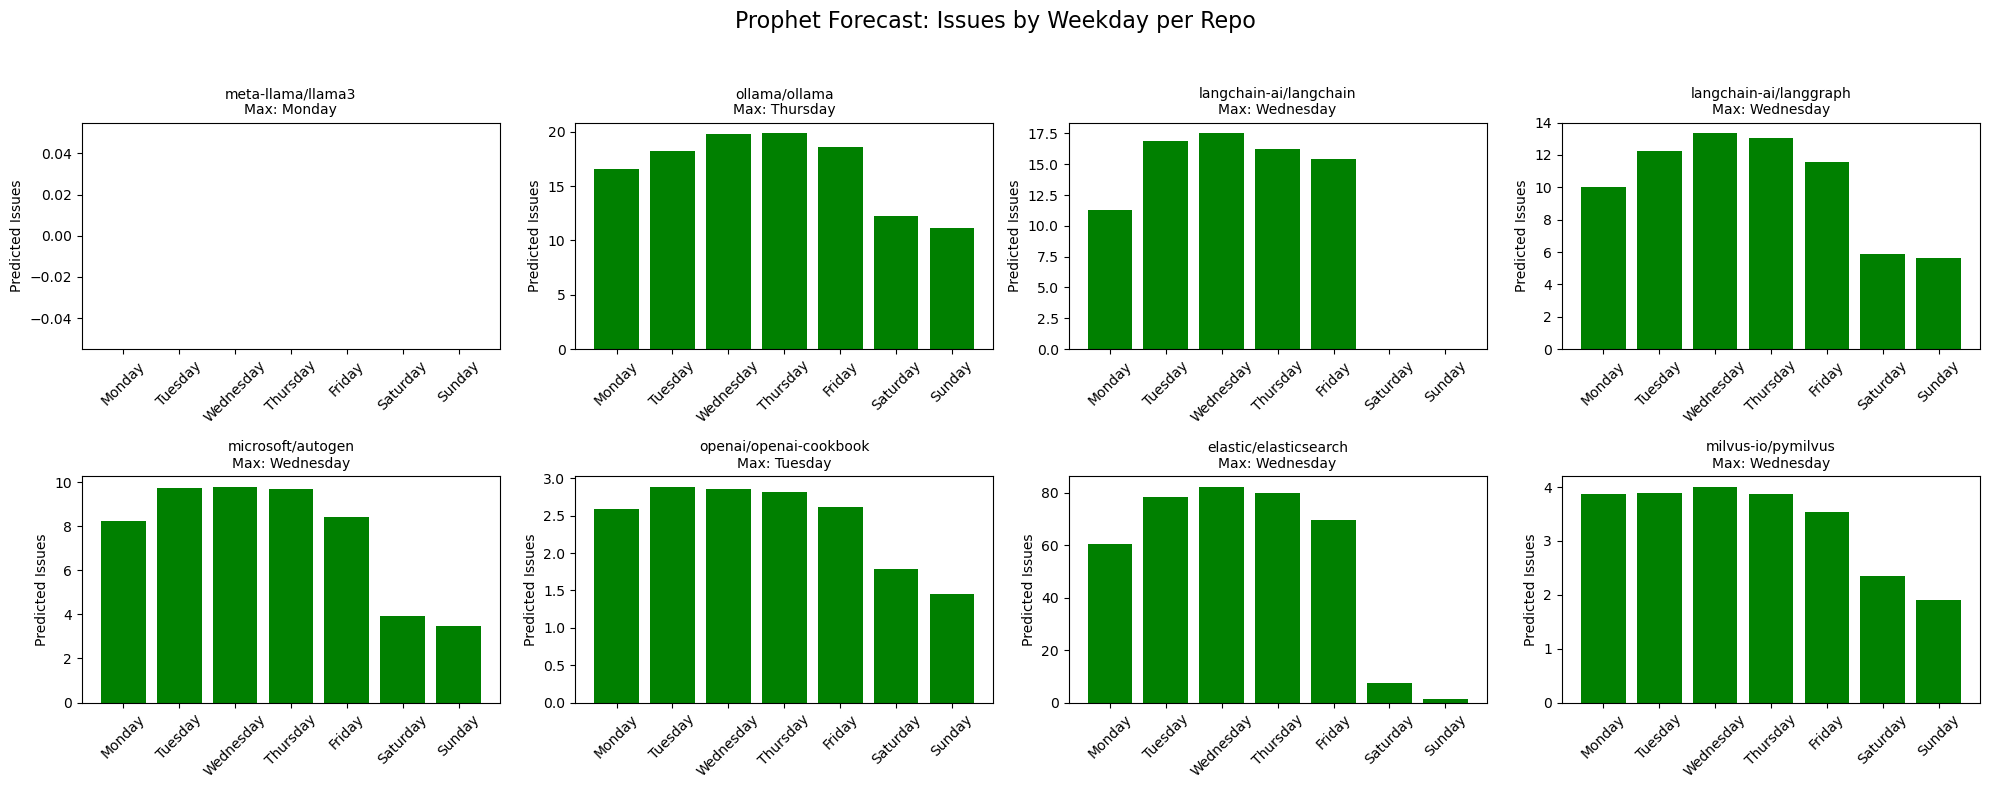

In [ ]:
#Add your code for requirement 9.1 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday", 
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    repo_df = df[df["repo"] == repo]
    
    # get daily issues
    daily_issues = repo_df.groupby(repo_df["created_at"].dt.date).size().reset_index(name='y')
    daily_issues.columns = ['ds', 'y']
    daily_issues['ds'] = pd.to_datetime(daily_issues['ds'])

    # prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_issues)

    # predict next 7 days
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # next 7 days
    future_forecast = forecast.tail(7)
    future_forecast['weekday'] = future_forecast['ds'].dt.day_name()

    # get predicted issues count for everyday
    yhat_values = future_forecast['yhat'].values
    weekdays = future_forecast['weekday'].values

    # format it
    prediction_dict = dict(zip(weekdays, yhat_values))
    predictions_ordered = [prediction_dict.get(day, 0) for day in days]
    max_day = days[np.argmax(predictions_ordered)]

    # plot
    ax = axs[idx]
    ax.bar(days, predictions_ordered, color='green')
    ax.set_title(f"{repo}\nMax: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Predicted Issues")
    
    # save each repo Prophet forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions_ordered, color='green')
    single_ax.set_title(f"{repo}\nMax: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Predicted Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/issues_created_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast: Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/issues_created_weekday_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-2). The day of the week maximum number of issues closed 

</div>

02:11:01 - cmdstanpy - INFO - Chain [1] start processing
02:11:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:01 - cmdstanpy - INFO - Chain [1] start processing
02:11:01 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:02 - cmdstanpy - INFO - Chain [1] start processing
02:11:02 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:02 - cmdstanpy - INFO - Chain [1] start processing
02:11:02 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:02 - cmdstanpy - INFO - Chain [1] start processing
02:11:02 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:03 - cmdstanpy - INFO - Chain [1] start processing


Saved microsoft_autogen


02:11:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:03 - cmdstanpy - INFO - Chain [1] start processing
02:11:03 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook
Saved elastic_elasticsearch


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()
02:11:03 - cmdstanpy - INFO - Chain [1] start processing
02:11:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_2895/3449249662.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['weekday'] = future_forecast['ds'].dt.day_name()


Saved milvus-io_pymilvus


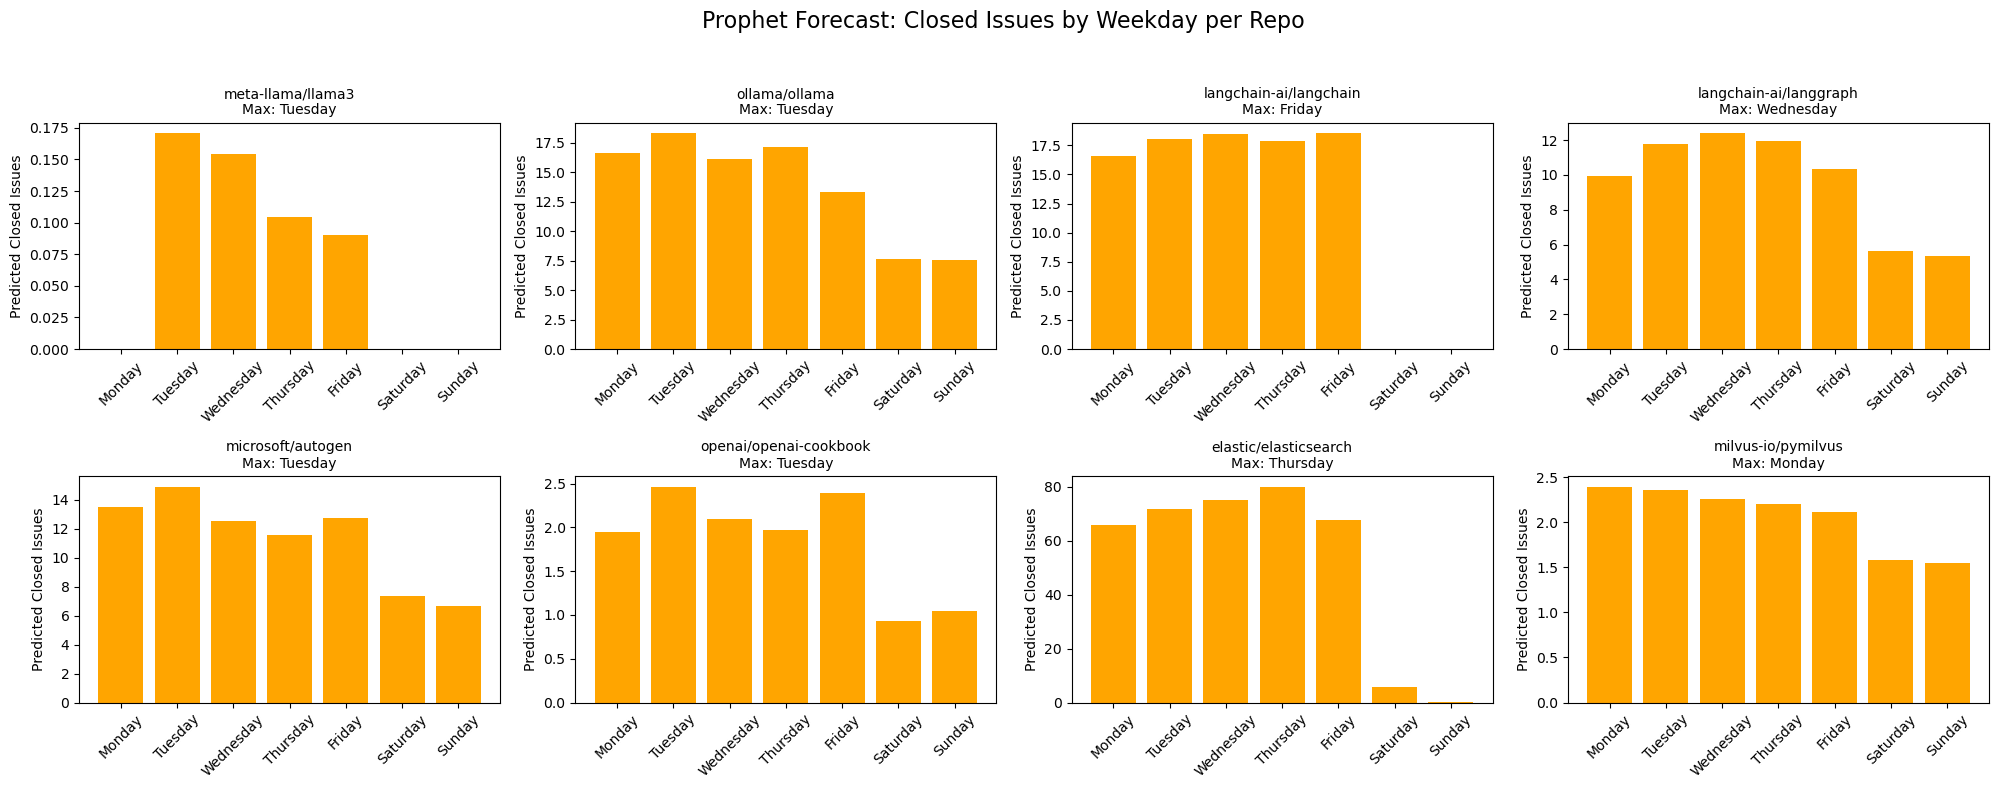

In [ ]:
#Add your code for requirement 9.2 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday", 
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    repo_df = df[df["repo"] == repo]
    
    # get daily closed issues
    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size().reset_index(name='y')
    daily_closed.columns = ['ds', 'y']
    daily_closed['ds'] = pd.to_datetime(daily_closed['ds'])

    # fill in missing dates with 0 by default to ensure continuous dates
    full_range = pd.date_range(start=daily_closed['ds'].min(), end=daily_closed['ds'].max())
    daily_closed = daily_closed.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    daily_closed.columns = ['ds', 'y']

    # prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_closed)

    # predict next 7 days
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # next 7 days
    future_forecast = forecast.tail(7)
    future_forecast['weekday'] = future_forecast['ds'].dt.day_name()

    # get predicted closed issue count for everyday
    yhat_values = future_forecast['yhat'].values
    weekdays = future_forecast['weekday'].values

    # format it
    prediction_dict = dict(zip(weekdays, yhat_values))
    predictions_ordered = [prediction_dict.get(day, 0) for day in days]
    max_day = days[np.argmax(predictions_ordered)]

    # plot
    ax = axs[idx]
    ax.bar(days, predictions_ordered, color='orange')
    ax.set_title(f"{repo}\nMax: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Predicted Closed Issues")
    
    # save each repo Prophet closed issue forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions_ordered, color='orange')
    single_ax.set_title(f"{repo}\nMax: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Predicted Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/issues_closed_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast: Closed Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/issues_closed_weekday_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-3). The month of the year that has maximum number of issues closed 


</div>

02:11:05 - cmdstanpy - INFO - Chain [1] start processing
02:11:05 - cmdstanpy - INFO - Chain [1] done processing
02:11:05 - cmdstanpy - INFO - Chain [1] start processing
02:11:05 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


02:11:06 - cmdstanpy - INFO - Chain [1] start processing
02:11:06 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:06 - cmdstanpy - INFO - Chain [1] start processing
02:11:06 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:07 - cmdstanpy - INFO - Chain [1] start processing
02:11:07 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:07 - cmdstanpy - INFO - Chain [1] start processing
02:11:07 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:07 - cmdstanpy - INFO - Chain [1] start processing
02:11:07 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:08 - cmdstanpy - INFO - Chain [1] start processing


Saved elastic_elasticsearch


02:11:08 - cmdstanpy - INFO - Chain [1] done processing


Saved milvus-io_pymilvus


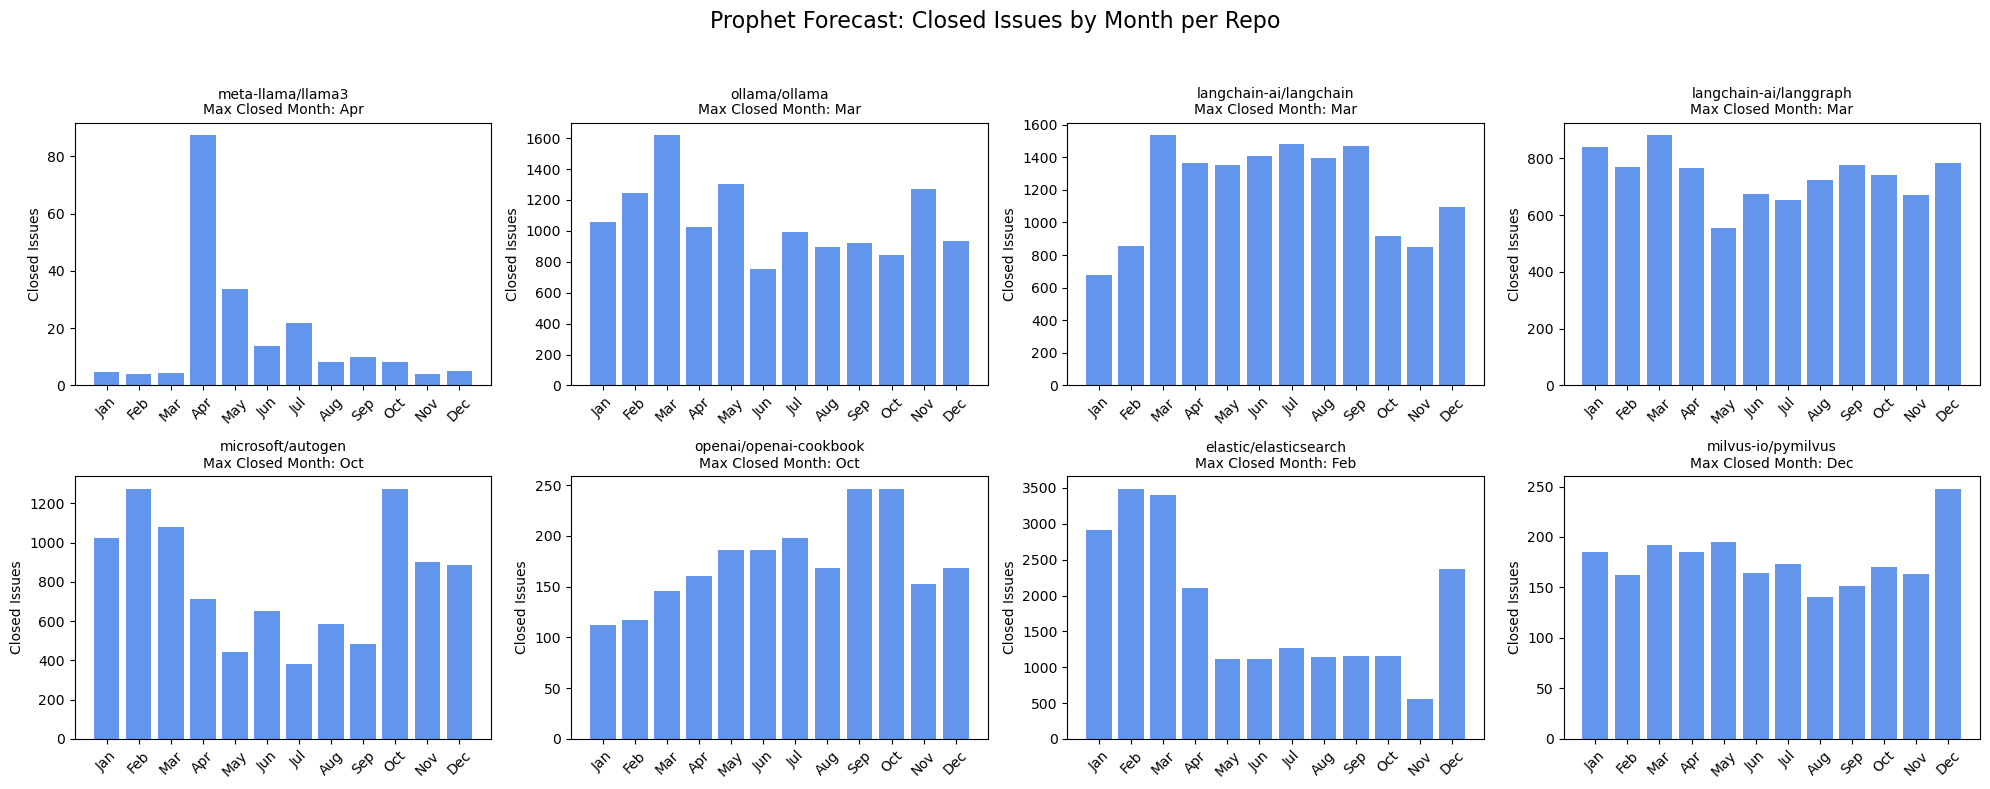

In [ ]:
# Add your code for requirement 9.3 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    # group by day and ensure continuity
    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size().reset_index(name='y')
    daily_closed.columns = ['ds', 'y']
    daily_closed['ds'] = pd.to_datetime(daily_closed['ds'])

    # fill missing dates with 0
    full_range = pd.date_range(start=daily_closed['ds'].min(), end=daily_closed['ds'].max())
    daily_closed = daily_closed.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    daily_closed.columns = ['ds', 'y']

    # prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(daily_closed)

    # predict next 365 days
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # group forecast by month
    forecast['month'] = forecast['ds'].dt.month
    monthly_sum = forecast.groupby('month')['yhat'].sum()
    monthly_sum = monthly_sum.reindex(range(1, 13), fill_value=0)

    # format for plotting
    monthly_values = monthly_sum.values
    max_month = months[np.argmax(monthly_values)]

    ax.bar(months, monthly_values, color='cornflowerblue')
    ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    
    # save each repo monthly forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(months, monthly_values, color='cornflowerblue')
    single_ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/issues_closed_monthly_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast: Closed Issues by Month per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/issues_closed_monthly_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-4). Plot the created issues forecast 

</div>

02:11:09 - cmdstanpy - INFO - Chain [1] start processing
02:11:09 - cmdstanpy - INFO - Chain [1] done processing
02:11:10 - cmdstanpy - INFO - Chain [1] start processing
02:11:10 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


02:11:10 - cmdstanpy - INFO - Chain [1] start processing
02:11:10 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:10 - cmdstanpy - INFO - Chain [1] start processing
02:11:10 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:11 - cmdstanpy - INFO - Chain [1] start processing
02:11:11 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:11 - cmdstanpy - INFO - Chain [1] start processing
02:11:11 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:11 - cmdstanpy - INFO - Chain [1] start processing
02:11:11 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:12 - cmdstanpy - INFO - Chain [1] start processing


Saved elastic_elasticsearch


02:11:12 - cmdstanpy - INFO - Chain [1] done processing


Saved milvus-io_pymilvus


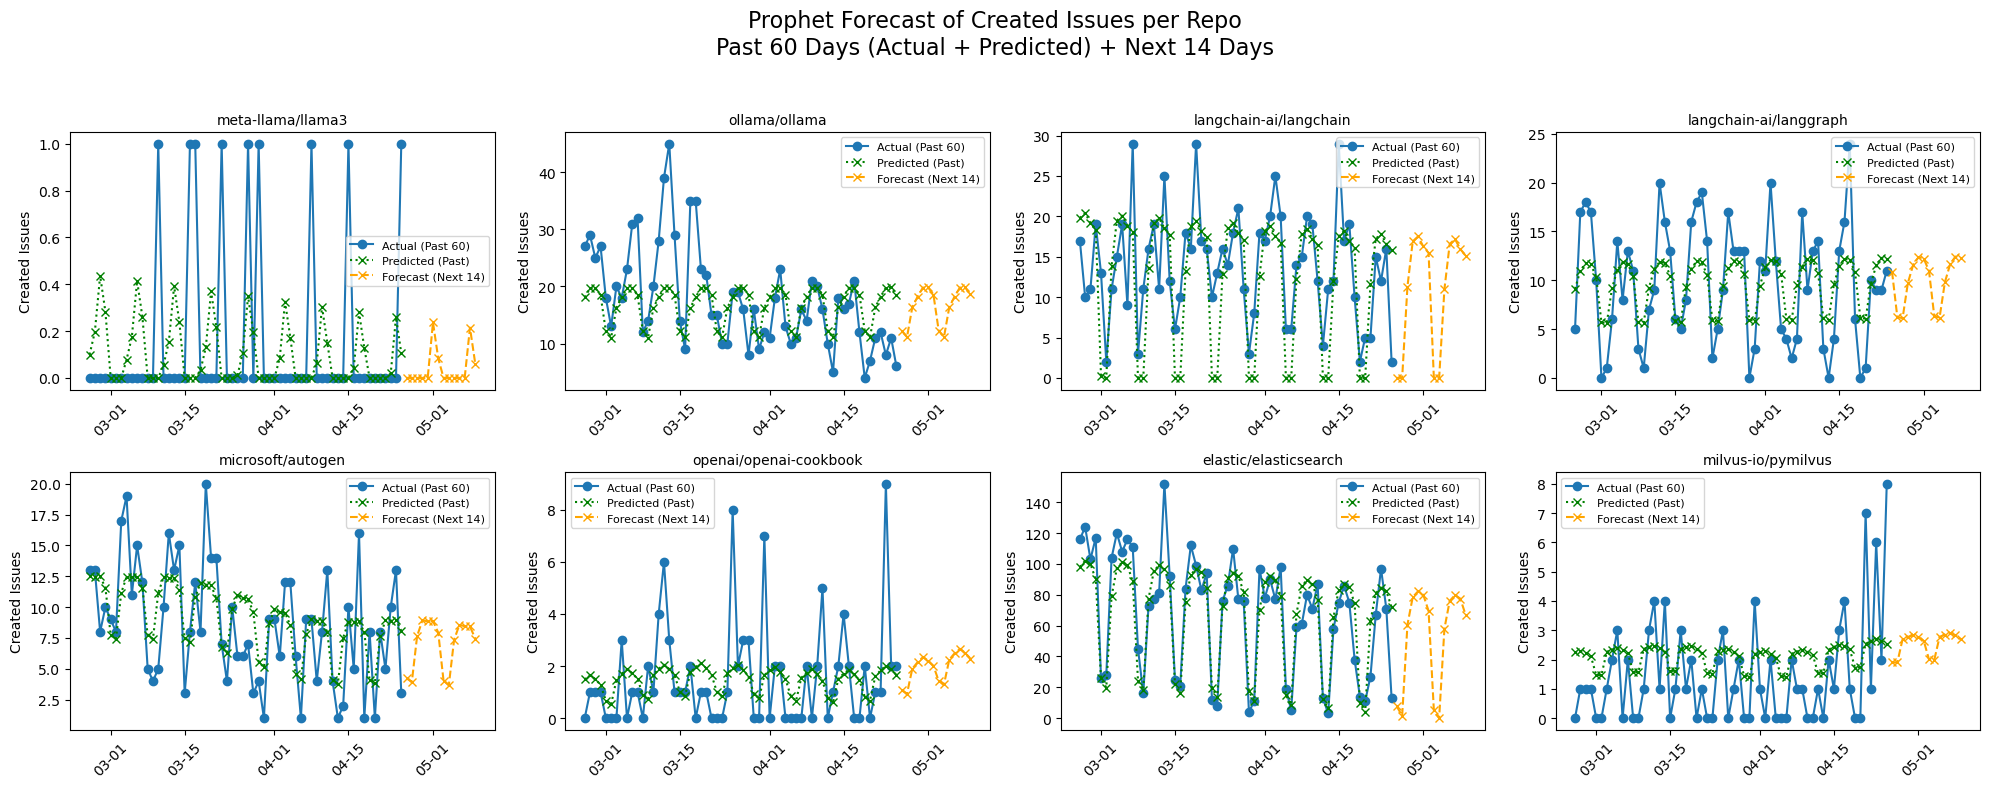

In [ ]:
#Add your code for requirement 9.4 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()

past_days = 60
forecast_days = 14

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.shape[0] < 10:
        ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                ha='center', va='center', color='gray')
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    daily_created = repo_df.groupby(repo_df["created_at"].dt.date).size().reset_index(name='y')
    daily_created.columns = ['ds', 'y']
    daily_created['ds'] = pd.to_datetime(daily_created['ds'])

    # fill missing date
    full_range = pd.date_range(start=daily_created['ds'].min(), end=daily_created['ds'].max())
    daily_created = daily_created.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    daily_created.columns = ['ds', 'y']

    # Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_created)

    # forecast
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # slice for plotting
    total_plot_days = past_days + forecast_days
    forecast_plot = forecast.tail(total_plot_days)

    # separate parts
    actual_plot = daily_created.tail(past_days)
    predicted_plot = forecast_plot.head(past_days)
    future_plot = forecast_plot.tail(forecast_days)

    # plot
    ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Created Issues")
    ax.legend(fontsize=8)
    
    # save each repo forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if repo_df.shape[0] < 10:
        single_ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                       ha='center', va='center', color='gray')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.axis("off")
    else:
        single_ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
        single_ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
        single_ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.set_ylabel("Created Issues")
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/created_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Created Issues per Repo\nPast 60 Days (Actual + Predicted) + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/created_issues_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-5). Plot the closed issues forecast 

</div>

02:11:13 - cmdstanpy - INFO - Chain [1] start processing
02:11:13 - cmdstanpy - INFO - Chain [1] done processing
02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:14 - cmdstanpy - INFO - Chain [1] start processing
02:11:15 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:15 - cmdstanpy - INFO - Chain [1] start processing
02:11:15 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:15 - cmdstanpy - INFO - Chain [1] start processing
02:11:15 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:16 - cmdstanpy - INFO - Chain [1] start processing


Saved elastic_elasticsearch


02:11:16 - cmdstanpy - INFO - Chain [1] done processing


Saved milvus-io_pymilvus


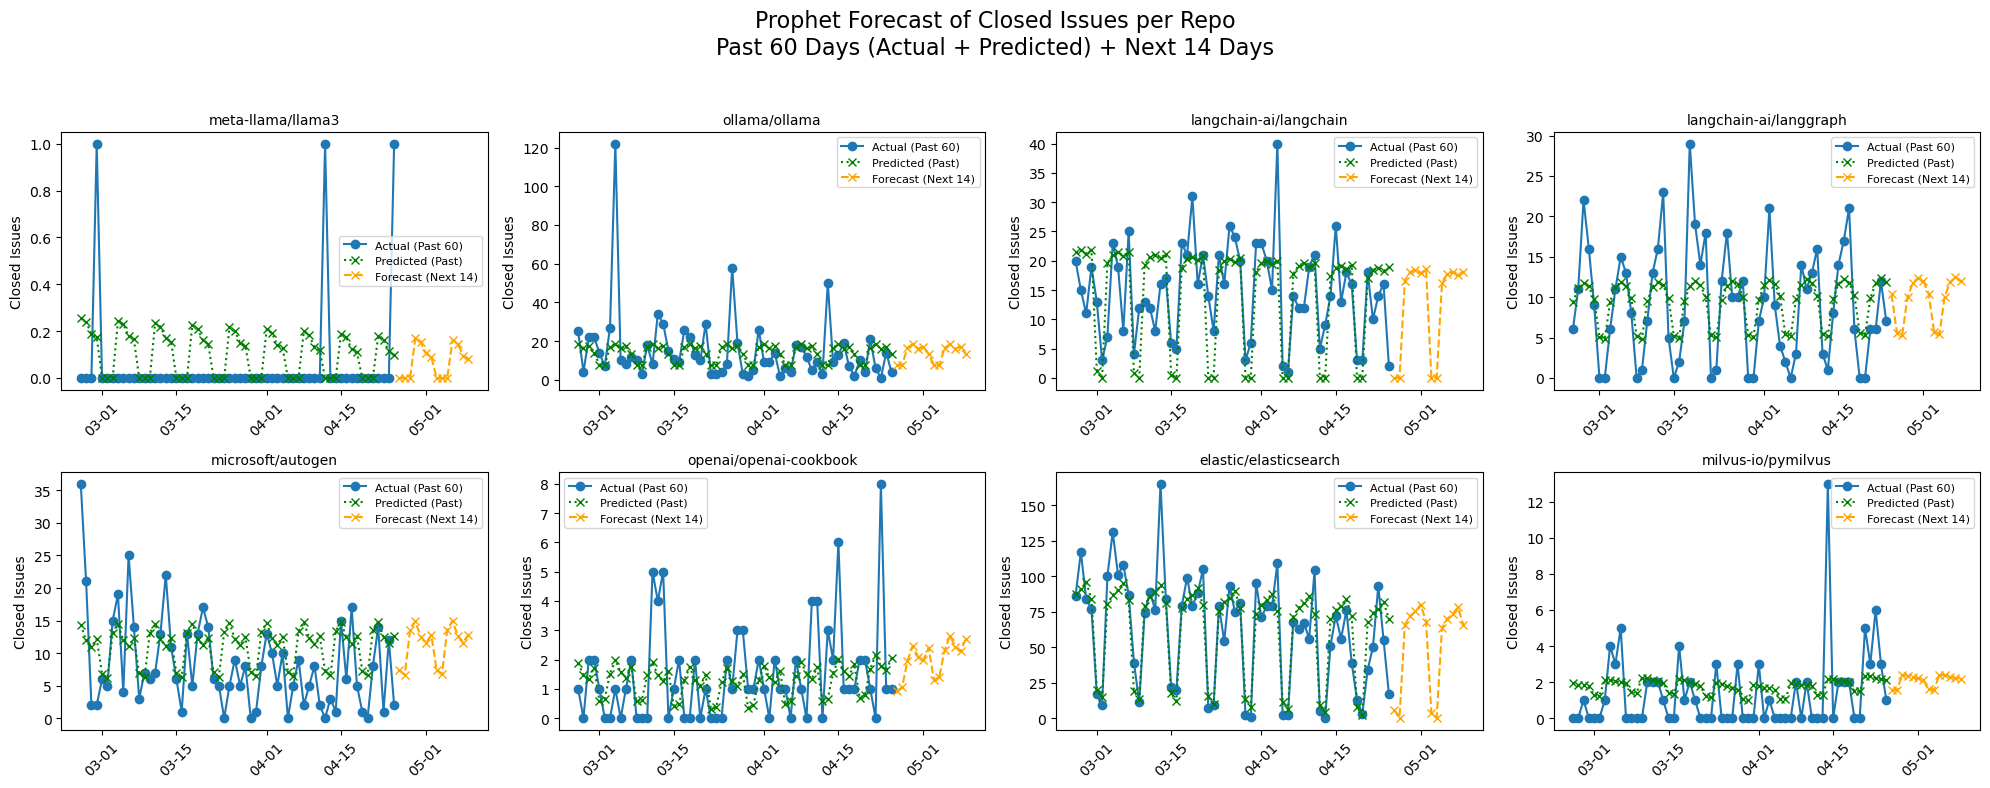

In [ ]:
#Add your code for requirement 9.5 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()

past_days = 60
forecast_days = 14

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.shape[0] < 10:
        ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                ha='center', va='center', color='gray')
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # groupby closed date
    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size().reset_index(name='y')
    daily_closed.columns = ['ds', 'y']
    daily_closed['ds'] = pd.to_datetime(daily_closed['ds'])

    # fill missing dates
    full_range = pd.date_range(start=daily_closed['ds'].min(), end=daily_closed['ds'].max())
    daily_closed = daily_closed.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    daily_closed.columns = ['ds', 'y']

    # Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_closed)

    # forecast
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # slice for plotting
    total_plot_days = past_days + forecast_days
    forecast_plot = forecast.tail(total_plot_days)

    # separate parts
    actual_plot = daily_closed.tail(past_days)
    predicted_plot = forecast_plot.head(past_days)
    future_plot = forecast_plot.tail(forecast_days)

    # plot
    ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    ax.legend(fontsize=8)
    
    # save each repo closed issues forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if repo_df.shape[0] < 10:
        single_ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                       ha='center', va='center', color='gray')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.axis("off")
    else:
        single_ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
        single_ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
        single_ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.set_ylabel("Closed Issues")
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/closed_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Closed Issues per Repo\nPast 60 Days (Actual + Predicted) + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/closed_issues_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-6). Plot the pulls forecast 

</div>

02:11:17 - cmdstanpy - INFO - Chain [1] start processing
02:11:17 - cmdstanpy - INFO - Chain [1] done processing
02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:19 - cmdstanpy - INFO - Chain [1] start processing
02:11:19 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:19 - cmdstanpy - INFO - Chain [1] start processing


Saved microsoft_autogen


02:11:19 - cmdstanpy - INFO - Chain [1] done processing
02:11:20 - cmdstanpy - INFO - Chain [1] start processing
02:11:20 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook
Saved elastic_elasticsearch


02:11:20 - cmdstanpy - INFO - Chain [1] start processing
02:11:20 - cmdstanpy - INFO - Chain [1] done processing


Saved milvus-io_pymilvus


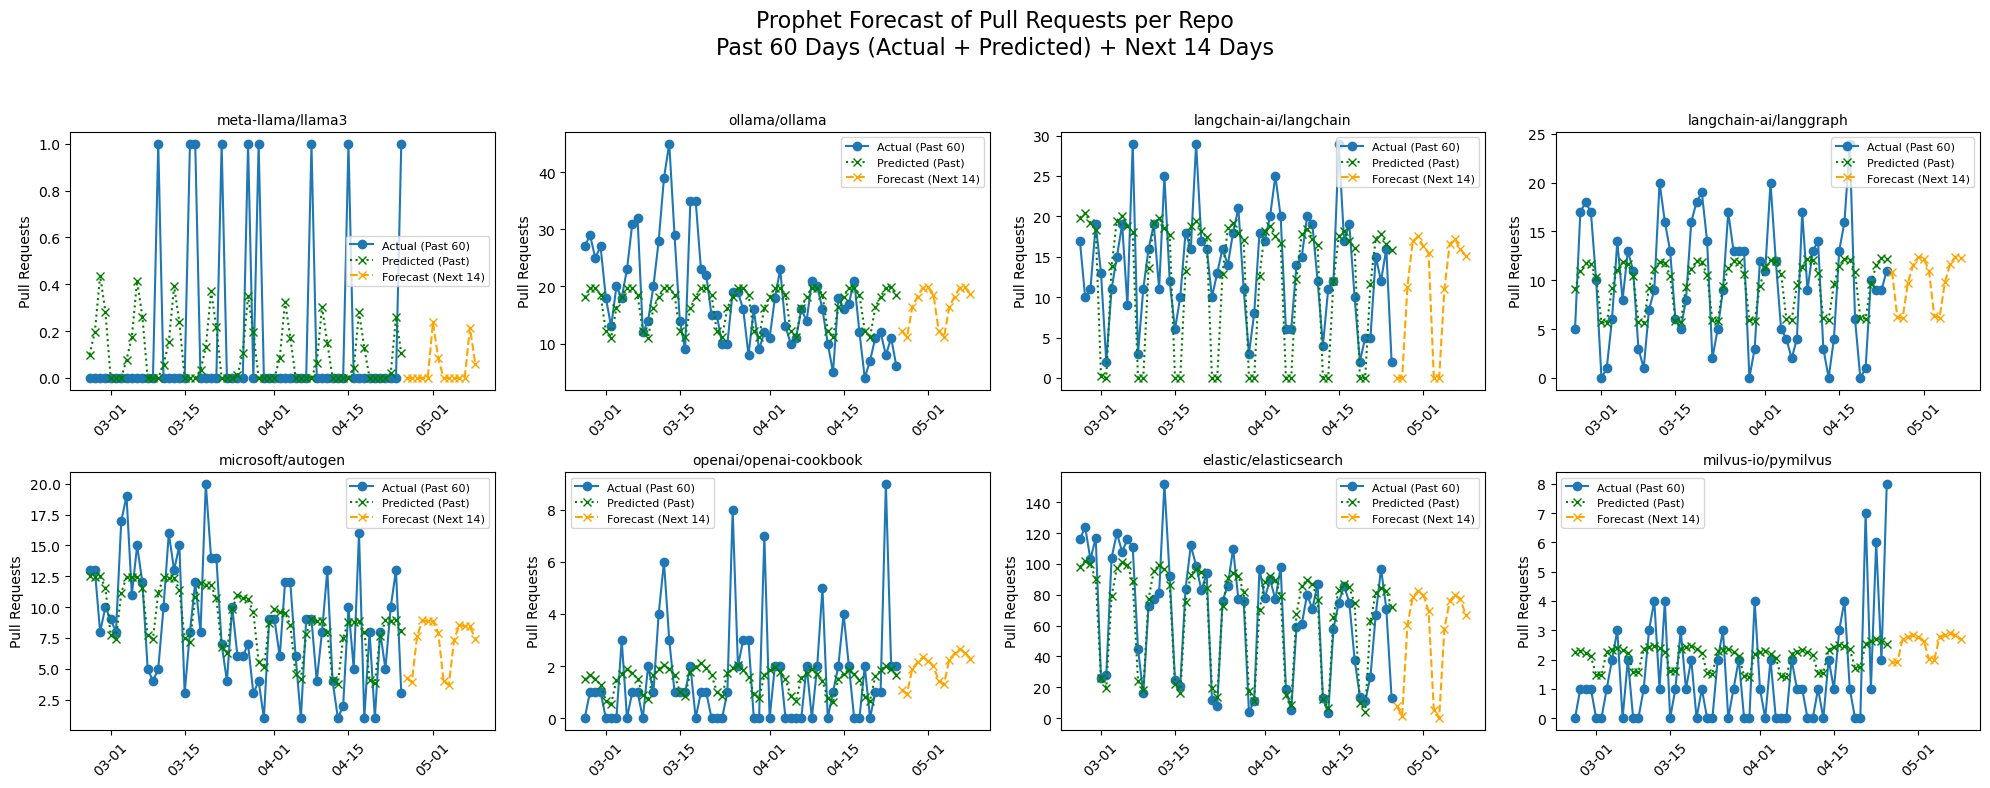

In [ ]:
#Add your code for requirement 9.6 in this cell

# get the original df (without filtering)
df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# check pull_request column
if "pull_request" not in df.columns:
    logger.info("No 'pull_request' column")
    df["is_pr"] = False
else:
    df["is_pr"] = df["pull_request"].notna()

# get df_pr
df_pr = df[df["is_pr"]]

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df_pr["repo"].unique()
past_days = 60
forecast_days = 14

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_pr[df_pr["repo"] == repo]

    if repo_df.shape[0] < 10:
        ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                ha='center', va='center', color='gray')
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # group daily pull requests
    daily_prs = repo_df.groupby(repo_df["created_at"].dt.date).size().reset_index(name='y')
    daily_prs.columns = ['ds', 'y']
    daily_prs['ds'] = pd.to_datetime(daily_prs['ds'])

    # fill missing dates
    full_range = pd.date_range(start=daily_prs['ds'].min(), end=daily_prs['ds'].max())
    daily_prs = daily_prs.set_index('ds').reindex(full_range, fill_value=0).reset_index()
    daily_prs.columns = ['ds', 'y']

    # Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_prs)

    # make forecast
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # slicing plot range
    total_plot_days = past_days + forecast_days
    forecast_plot = forecast.tail(total_plot_days)

    # separate parts
    actual_plot = daily_prs.tail(past_days)
    predicted_plot = forecast_plot.head(past_days)
    future_plot = forecast_plot.tail(forecast_days)

    # plot
    ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Pull Requests")
    ax.legend(fontsize=8)
    
    # save each repo pull request forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if repo_df.shape[0] < 10:
        single_ax.text(0.5, 0.5, "Not enough data", fontsize=12,
                       ha='center', va='center', color='gray')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.axis("off")
    else:
        single_ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 60)", marker='o')
        single_ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
        single_ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.set_ylabel("Pull Requests")
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/pull_requests_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Pull Requests per Repo\nPast 60 Days (Actual + Predicted) + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/pull_requests_forecast.png")
plt.show()

<div class="alert alert-block alert-warning">   
    
#### REQ9-7). Plot the commits forecast

</div>

02:11:22 - cmdstanpy - INFO - Chain [1] start processing
02:11:22 - cmdstanpy - INFO - Chain [1] done processing
02:11:22 - cmdstanpy - INFO - Chain [1] start processing
02:11:22 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:22 - cmdstanpy - INFO - Chain [1] start processing
02:11:22 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:23 - cmdstanpy - INFO - Chain [1] start processing
02:11:23 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:23 - cmdstanpy - INFO - Chain [1] start processing
02:11:23 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:23 - cmdstanpy - INFO - Chain [1] start processing
02:11:23 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:23 - cmdstanpy - INFO - Chain [1] start processing
02:11:23 - cmdstanpy - INFO - Chain [1] done processing


Saved elastic_elasticsearch
Saved milvus-io_pymilvus


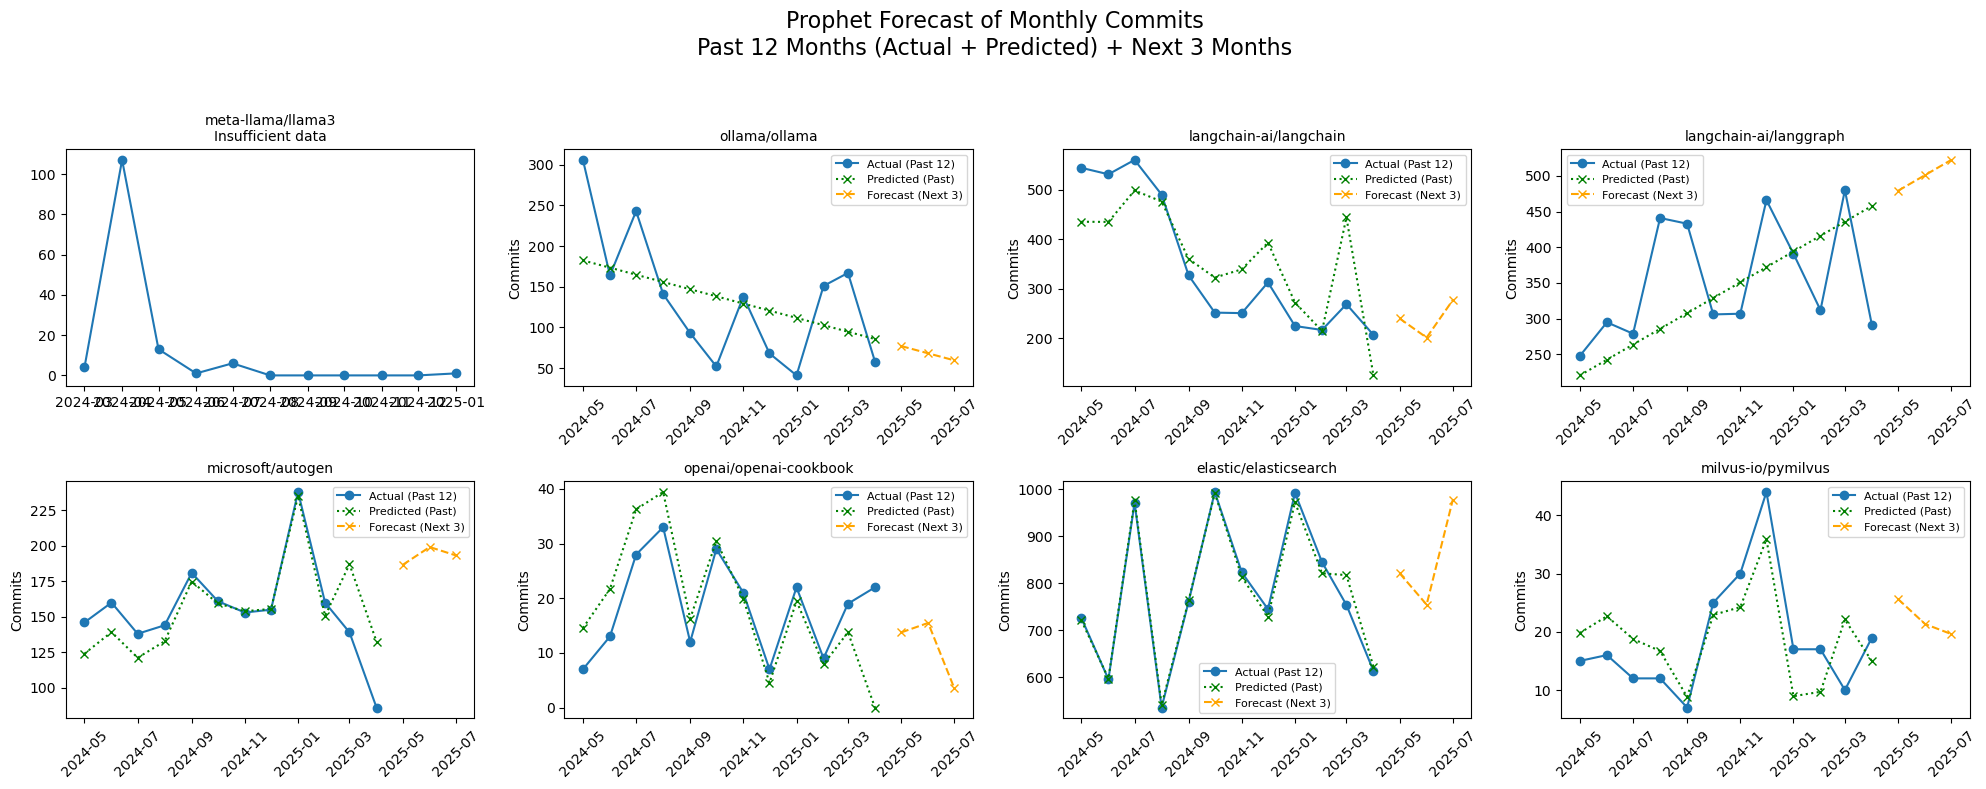

In [ ]:
#Add your code for requirement 9.7 in this cell

df_commits_data["date"] = pd.to_datetime(df_commits_data["date"])

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

eval_months = 12
forecast_months = 3

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_commits_data[df_commits_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    monthly_commits = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_commits.index = monthly_commits.index.to_timestamp()

    if monthly_commits.empty:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly_commits.index.min(), monthly_commits.index.max(), freq="MS")
    monthly_commits = monthly_commits.reindex(full_index, fill_value=0)
    df_prophet = pd.DataFrame({'ds': monthly_commits.index, 'y': monthly_commits.values})

    if len(df_prophet) < eval_months + forecast_months:
        ax.plot(df_prophet['ds'], df_prophet['y'], label="Actual", marker='o')
        ax.set_title(f"{repo}\nInsufficient data", fontsize=10)
        ax.axis("on")
        continue

    # Prophet model
    model = Prophet()
    model.fit(df_prophet)

    # forecast
    total_periods = eval_months + forecast_months
    future = model.make_future_dataframe(periods=forecast_months, freq='MS')
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    forecast_start = df_prophet['ds'].iloc[-eval_months]
    forecast_plot = forecast[forecast['ds'] >= forecast_start]

    # 3 parts
    actual_plot = df_prophet[df_prophet['ds'] >= forecast_start]
    predicted_plot = forecast_plot[forecast_plot['ds'] < forecast_plot['ds'].iloc[-forecast_months]]
    future_plot = forecast_plot.tail(forecast_months)


    # plot
    ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 12)", marker='o')
    ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.set_ylabel("Commits")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo monthly commits forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(df_prophet) < eval_months + forecast_months:
        single_ax.plot(df_prophet['ds'], df_prophet['y'], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nInsufficient data", fontsize=12)
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.set_ylabel("Commits")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.legend()
    else:
        single_ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 12)", marker='o')
        single_ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
        single_ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.set_ylabel("Commits")
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/monthly_commits_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Monthly Commits\nPast 12 Months (Actual + Predicted) + Next 3 Months", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/monthly_commits_forecast.png")
plt.show()

<div class="alert alert-block alert-warning">   
    
#### REQ9-8). Plot the branches forecast

</div>

02:11:25 - cmdstanpy - INFO - Chain [1] start processing
02:11:25 - cmdstanpy - INFO - Chain [1] done processing
02:11:25 - cmdstanpy - INFO - Chain [1] start processing
02:11:25 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3
Saved ollama_ollama


02:11:25 - cmdstanpy - INFO - Chain [1] start processing
02:11:25 - cmdstanpy - INFO - Chain [1] done processing
02:11:26 - cmdstanpy - INFO - Chain [1] start processing
02:11:26 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:27 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing


Saved elastic_elasticsearch
Saved milvus-io_pymilvus


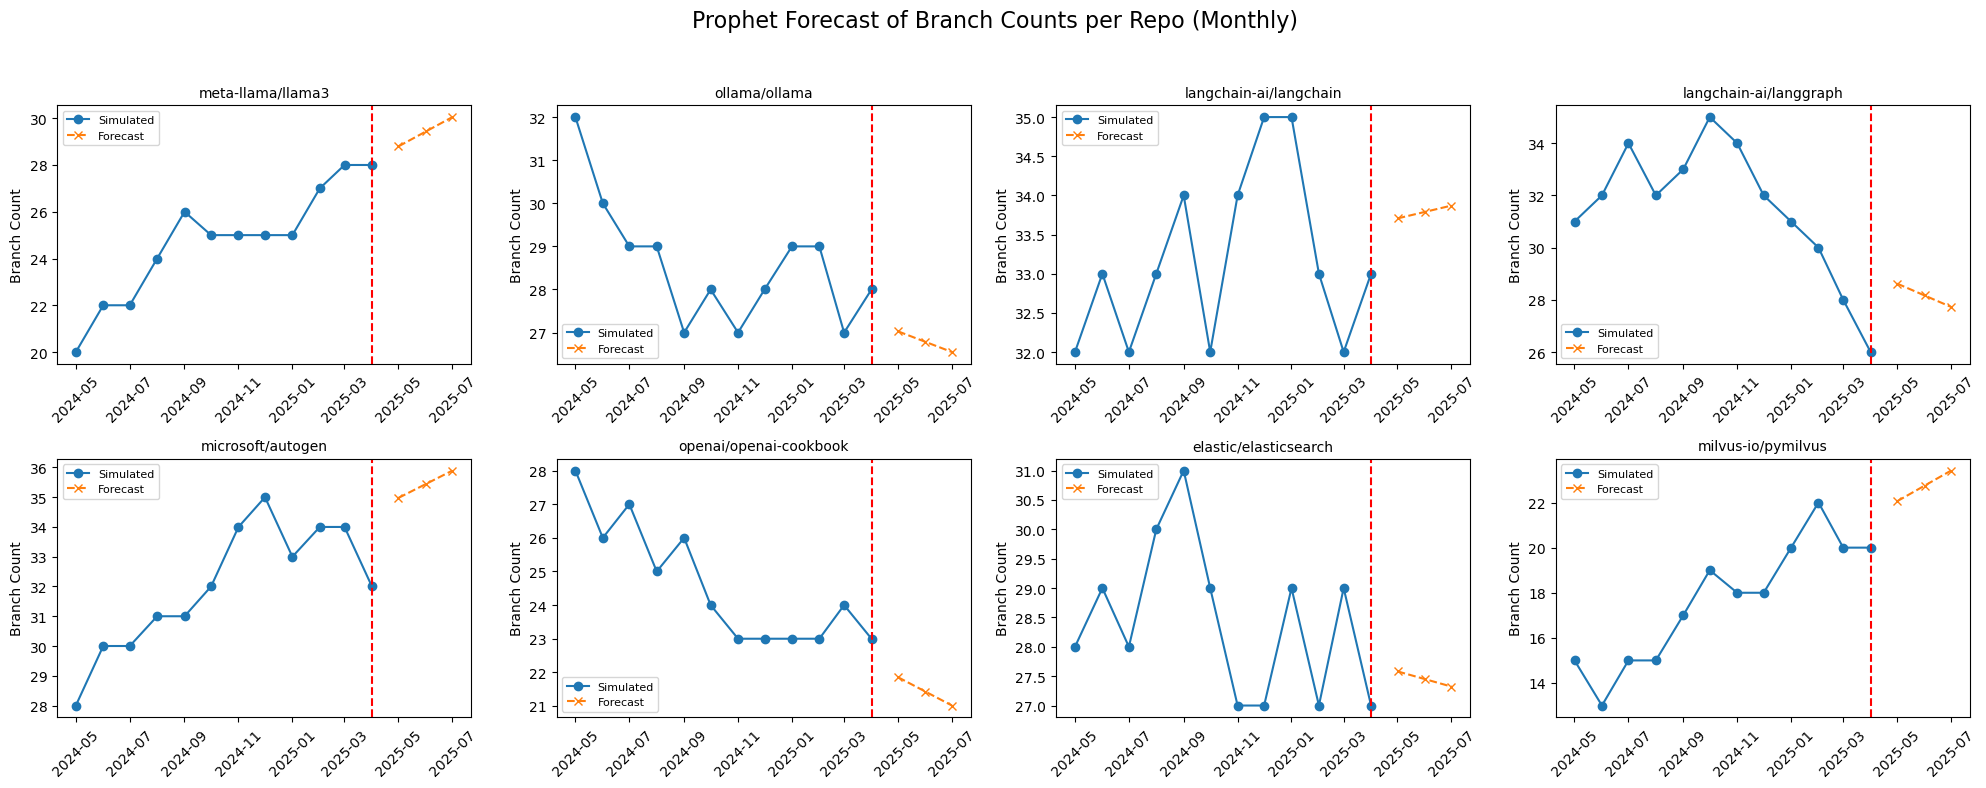

In [ ]:
#Add your code for requirement 9.8 in this cell

repos = df_branches_data["repo"].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_branches_data[df_branches_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate historical monthly data
    latest = row["branch_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-2, 3, size=12).cumsum(), 0, None)

    # create DataFrame for Prophet
    dates = pd.date_range(end=pd.Timestamp.today(), periods=12, freq="MS")
    df_prophet = pd.DataFrame({"ds": dates, "y": simulated_series})

    # build and fit model
    model = Prophet()
    model.fit(df_prophet)

    # forecast next 3 months
    future = model.make_future_dataframe(periods=3, freq='MS')
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # extract forecasted branch counts
    preds = forecast.tail(3)
    all_values = np.concatenate([df_prophet['y'].values, preds['yhat'].values])
    all_dates = pd.date_range(end=preds['ds'].iloc[-1], periods=len(all_values), freq='MS')

    # plot
    ax.plot(all_dates[:12], df_prophet['y'].values, label="Simulated", marker='o')
    ax.plot(all_dates[12:], preds['yhat'].values, label="Forecast", linestyle="--", marker='x')
    ax.axvline(x=all_dates[11], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Branch Count")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo branch forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(all_dates[:12], df_prophet['y'].values, label="Simulated", marker='o')
    single_ax.plot(all_dates[12:], preds['yhat'].values, label="Forecast", linestyle="--", marker='x')
    single_ax.axvline(x=all_dates[11], color='red', linestyle='--')
    single_ax.set_title(repo, fontsize=12)
    single_ax.set_ylabel("Branch Count")
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/monthly_branches_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/monthly_branches_forecast.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-9). Plot the contributors forecast

</div>

02:11:30 - cmdstanpy - INFO - Chain [1] start processing
02:11:30 - cmdstanpy - INFO - Chain [1] done processing
02:11:30 - cmdstanpy - INFO - Chain [1] start processing
02:11:30 - cmdstanpy - INFO - Chain [1] done processing


Saved meta-llama_llama3


02:11:30 - cmdstanpy - INFO - Chain [1] start processing
02:11:30 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:11:31 - cmdstanpy - INFO - Chain [1] start processing
02:11:31 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:11:31 - cmdstanpy - INFO - Chain [1] start processing
02:11:31 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langgraph


02:11:31 - cmdstanpy - INFO - Chain [1] start processing
02:11:31 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:11:32 - cmdstanpy - INFO - Chain [1] start processing
02:11:32 - cmdstanpy - INFO - Chain [1] done processing


Saved openai_openai-cookbook


02:11:32 - cmdstanpy - INFO - Chain [1] start processing
02:11:32 - cmdstanpy - INFO - Chain [1] done processing


Saved elastic_elasticsearch
Saved milvus-io_pymilvus


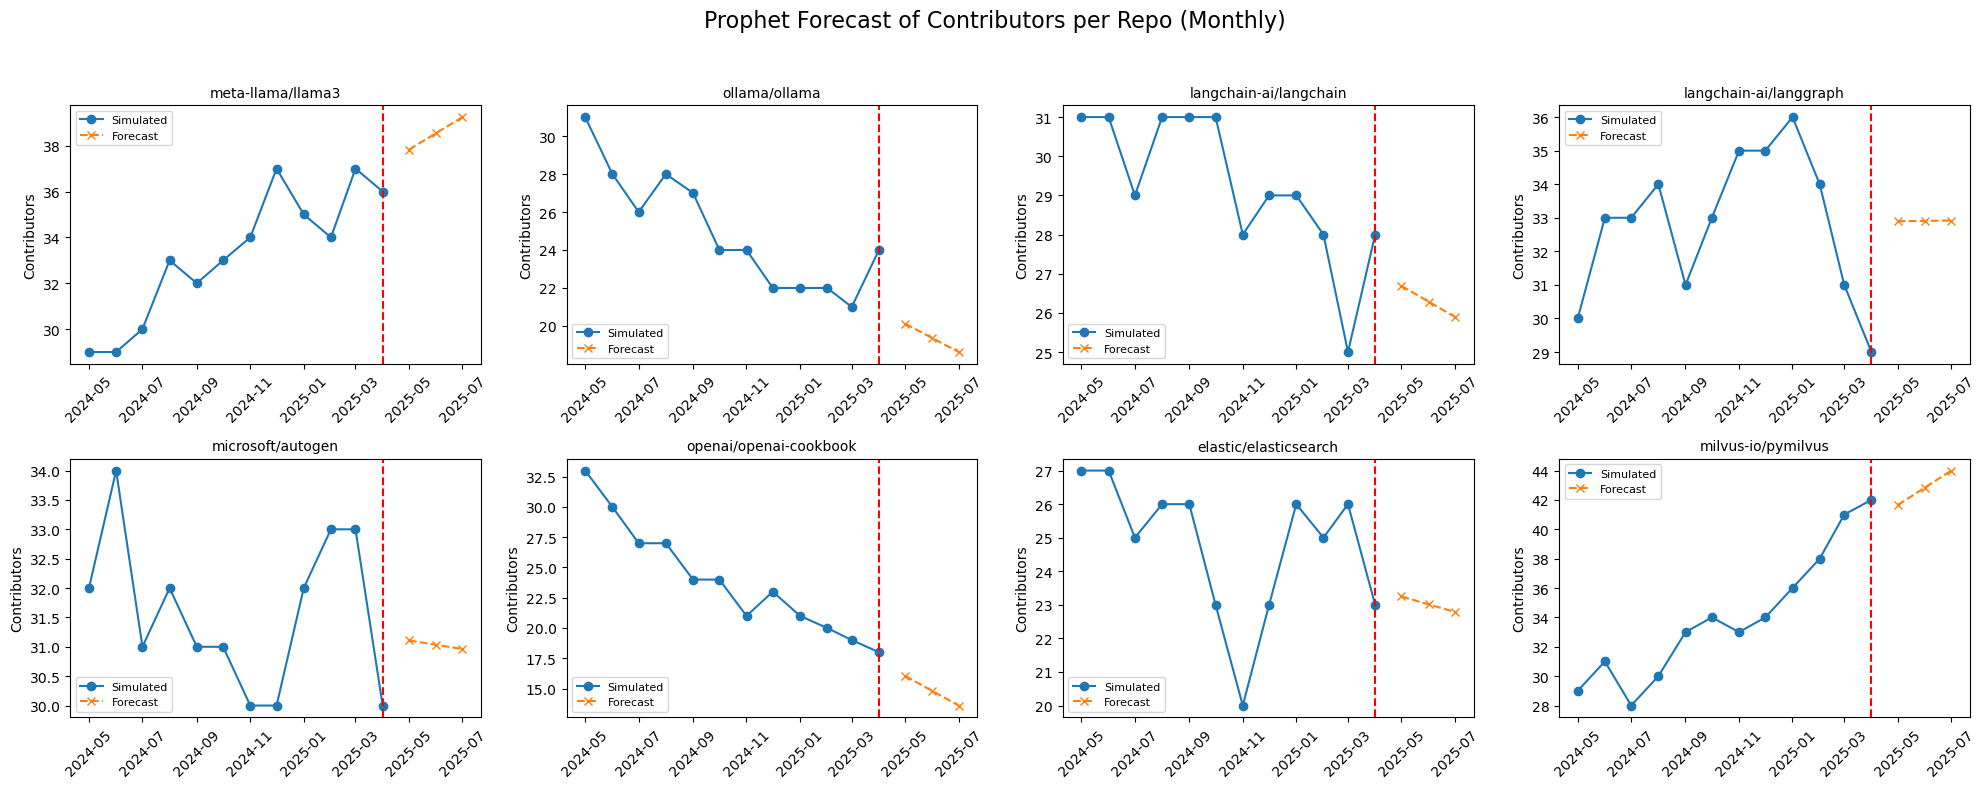

In [ ]:
#Add your code for requirement 9.9 in this cell

repos = df_contributors_data["repo"].unique()

# create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_contributors_data[df_contributors_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate a historical monthly series using current value and noise.
    latest = row["contributor_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-3, 4, size=12).cumsum(), 0, None)

    # create DataFrame for Prophet
    dates = pd.date_range(end=pd.Timestamp.today(), periods=12, freq="MS")
    df_prophet = pd.DataFrame({"ds": dates, "y": simulated_series})

    # Prophet model
    model = Prophet()
    model.fit(df_prophet)

    # forecast next 3 months
    future = model.make_future_dataframe(periods=3, freq='MS')
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    # combine simulated + forecast
    preds = forecast.tail(3)
    all_values = np.concatenate([df_prophet['y'].values, preds['yhat'].values])
    all_dates = pd.date_range(end=preds['ds'].iloc[-1], periods=len(all_values), freq='MS')

    # plot
    ax.plot(all_dates[:12], df_prophet['y'].values, label="Simulated", marker="o")
    ax.plot(all_dates[12:], preds['yhat'].values, label="Forecast", linestyle="--", marker="x")
    ax.axvline(x=all_dates[11], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Contributors")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo contributor forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(all_dates[:12], df_prophet['y'].values, label="Simulated", marker="o")
    single_ax.plot(all_dates[12:], preds['yhat'].values, label="Forecast", linestyle="--", marker="x")
    single_ax.axvline(x=all_dates[11], color='red', linestyle='--')
    single_ax.set_title(repo, fontsize=12)
    single_ax.set_ylabel("Contributors")
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/monthly_contributors_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Contributors per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/monthly_contributors_forecast.png")
plt.show()

<div class="alert alert-block alert-warning">   
    
#### REQ9-10). Plot the releases forecast

</div>

02:18:31 - cmdstanpy - INFO - Chain [1] start processing
02:18:31 - cmdstanpy - INFO - Chain [1] done processing
02:18:31 - cmdstanpy - INFO - Chain [1] start processing
02:18:32 - cmdstanpy - INFO - Chain [1] done processing


Saved ollama_ollama


02:18:32 - cmdstanpy - INFO - Chain [1] start processing
02:18:32 - cmdstanpy - INFO - Chain [1] done processing


Saved langchain-ai_langchain


02:18:32 - cmdstanpy - INFO - Chain [1] start processing
02:18:32 - cmdstanpy - INFO - Chain [1] done processing


Saved microsoft_autogen


02:18:32 - cmdstanpy - INFO - Chain [1] start processing
02:18:32 - cmdstanpy - INFO - Chain [1] done processing


Saved elastic_elasticsearch
Saved milvus-io_pymilvus


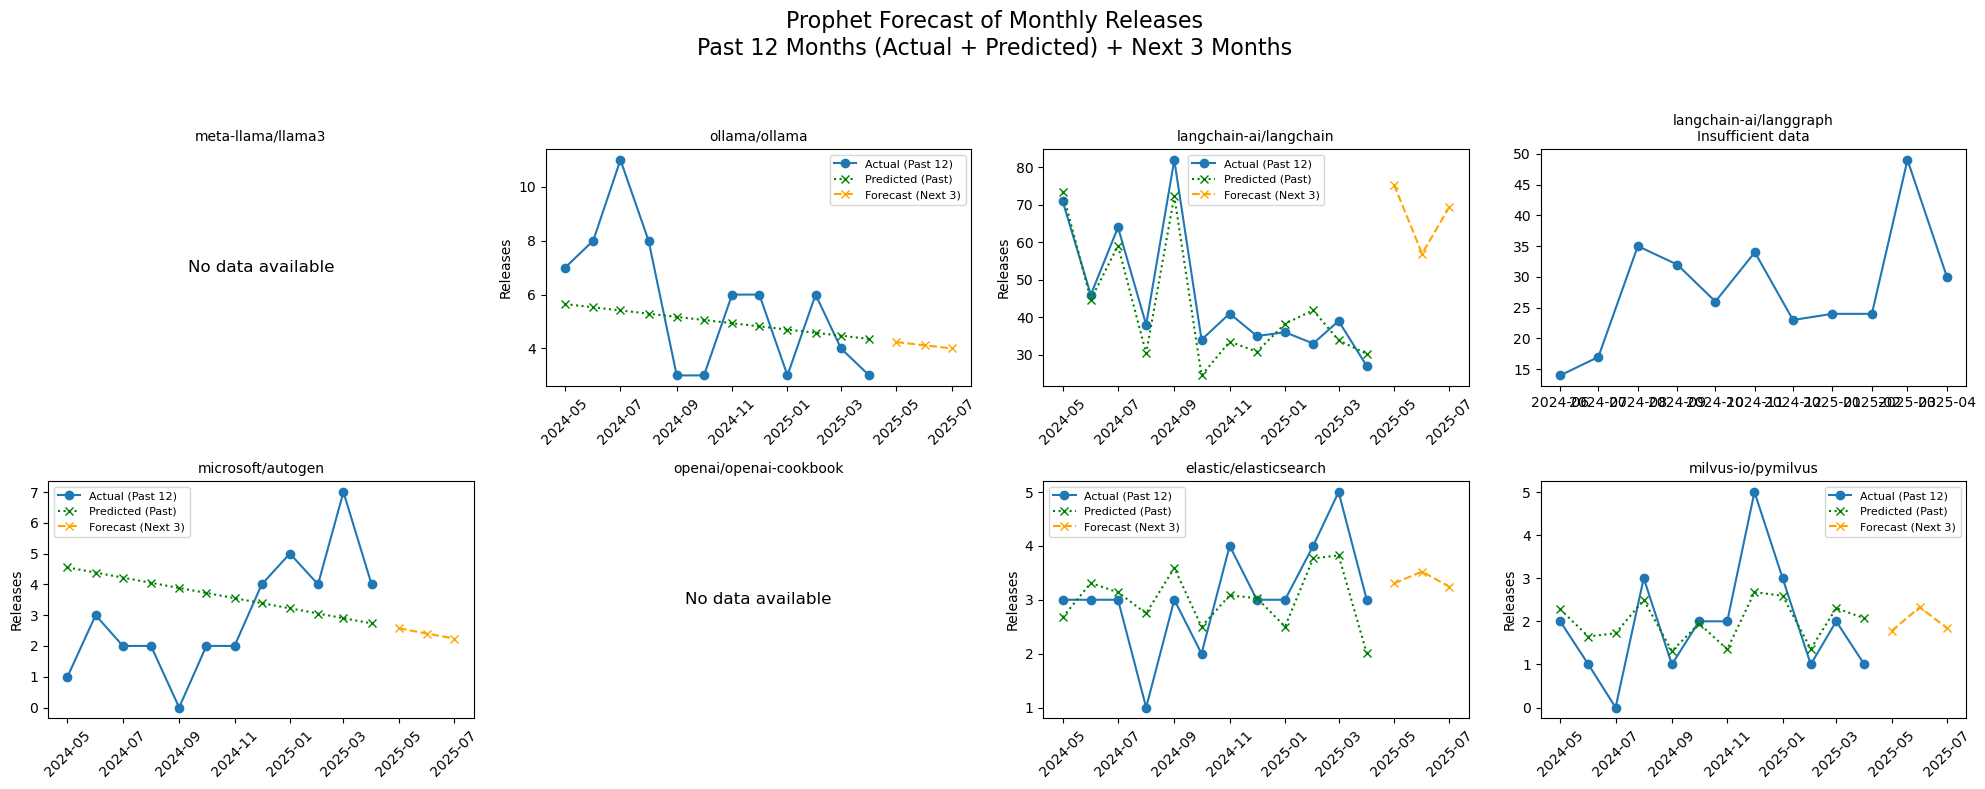

In [ ]:
#Add your code for requirement 9.10 in this cell

df_releases_data["date"] = pd.to_datetime(df_releases_data["date"])

eval_months = 12
forecast_months = 3

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_releases_data[df_releases_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # groupby month
    monthly_releases = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_releases.index = monthly_releases.index.to_timestamp()

    if monthly_releases.empty:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly_releases.index.min(), monthly_releases.index.max(), freq="MS")
    monthly_releases = monthly_releases.reindex(full_index, fill_value=0)
    df_prophet = pd.DataFrame({'ds': monthly_releases.index, 'y': monthly_releases.values})

    if len(df_prophet) < eval_months + forecast_months:
        ax.plot(df_prophet['ds'], df_prophet['y'], label="Actual", marker='o')
        ax.set_title(f"{repo}\nInsufficient data", fontsize=10)
        ax.axis("on")
        continue

    # Prophet model
    model = Prophet()
    model.fit(df_prophet)

    # forecast
    future = model.make_future_dataframe(periods=forecast_months, freq="MS")
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)

    forecast_start = df_prophet['ds'].iloc[-eval_months]
    forecast_plot = forecast[forecast['ds'] >= forecast_start]

    # 3 parts
    actual_plot = df_prophet[df_prophet['ds'] >= forecast_start]
    predicted_plot = forecast_plot[forecast_plot['ds'] < forecast_plot['ds'].iloc[-forecast_months]]
    future_plot = forecast_plot.tail(forecast_months)

    # plot
    ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 12)", marker='o')
    ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.set_ylabel("Releases")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo releases forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    if len(df_prophet) < eval_months + forecast_months:
        single_ax.plot(df_prophet['ds'], df_prophet['y'], label="Actual", marker='o')
        single_ax.set_title(f"{repo}\nInsufficient data", fontsize=12)
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.set_ylabel("Releases")
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.legend()
    else:
        single_ax.plot(actual_plot['ds'], actual_plot['y'], label="Actual (Past 12)", marker='o')
        single_ax.plot(predicted_plot['ds'], predicted_plot['yhat'], label="Predicted (Past)", linestyle=':', marker='x', color='green')
        single_ax.plot(future_plot['ds'], future_plot['yhat'], label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')
        single_ax.set_title(f"{repo}", fontsize=12)
        single_ax.set_ylabel("Releases")
        single_ax.tick_params(axis='x', rotation=45)
        single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/Prophet/monthly_releases_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("Prophet Forecast of Monthly Releases\nPast 12 Months (Actual + Predicted) + Next 3 Months", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Prophet/monthly_releases_forecast.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 10 (STATSMODEL)
- Use StatsModel package to forecast the following for every repository
    
</div>

<div class="alert alert-block alert-danger">   
    
#### REQ10-1). The day of the week maximum number of issues created 
    
</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


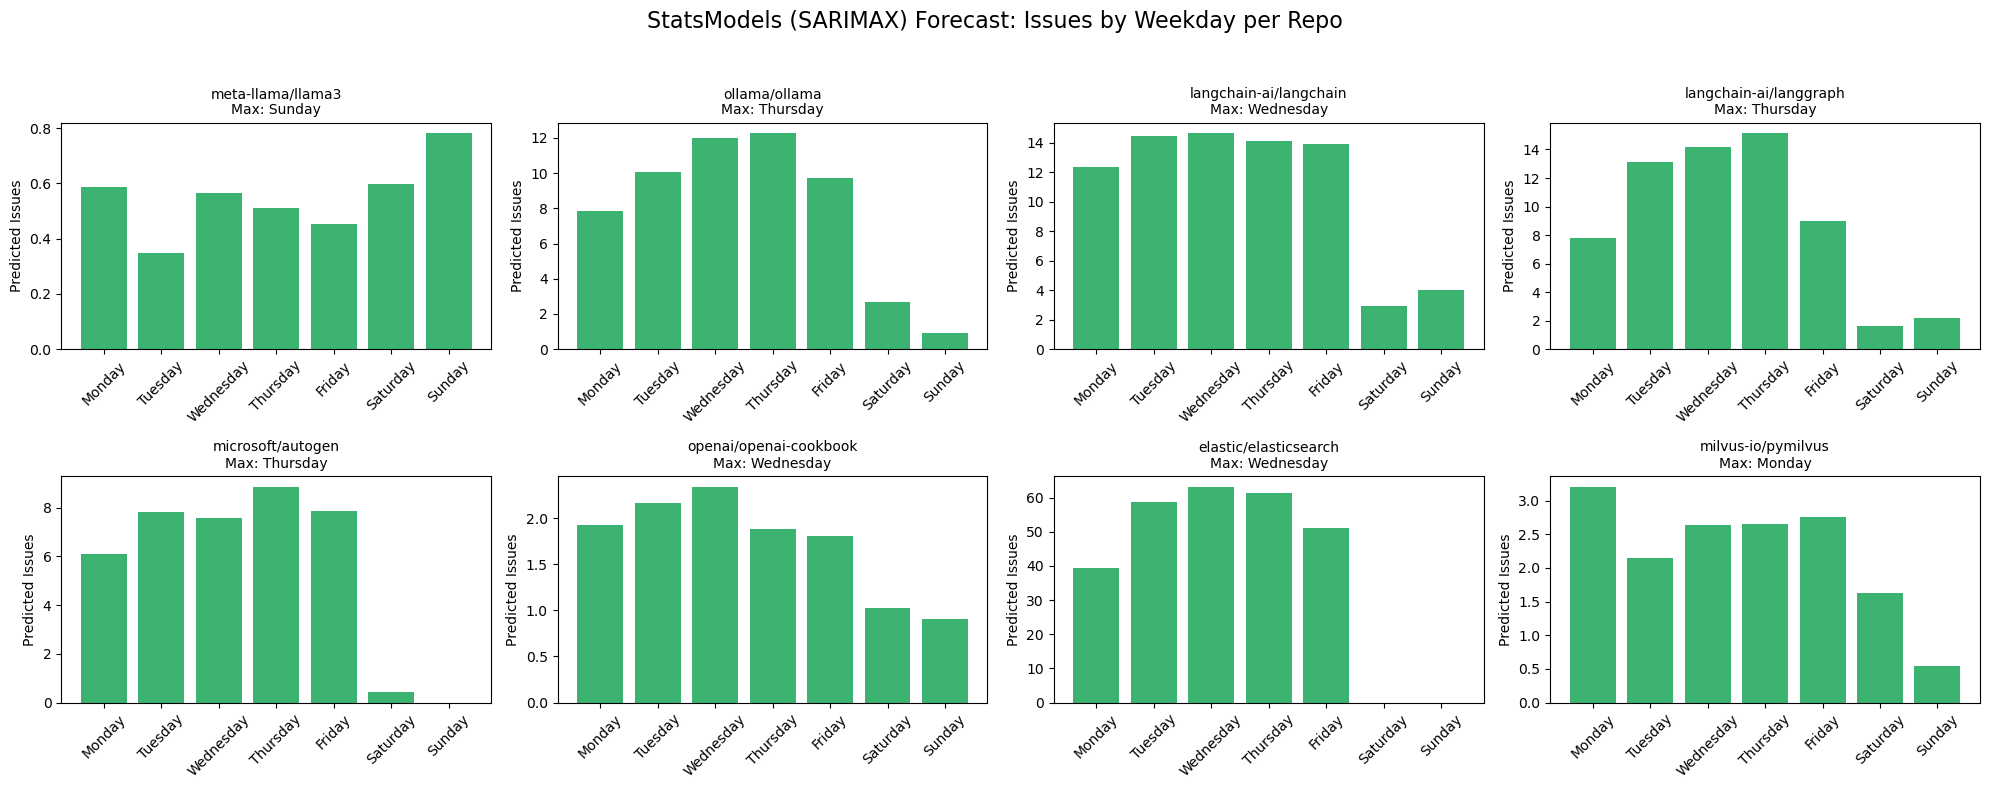

In [ ]:
#Add your code for requirement 10.1 in this cell

df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday", 
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    repo_df = df[df["repo"] == repo]

    # groupby day
    daily_issues = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_issues = daily_issues.reindex(
        pd.date_range(daily_issues.index.min(), daily_issues.index.max()),
        fill_value=0
    )
    daily_issues.index.name = "ds"

    if len(daily_issues) < 30:
        axs[idx].text(0.5, 0.5, "Not enough data", ha="center", va="center", fontsize=12)
        axs[idx].axis("off")
        continue

    # SARIMAX model
    try:
        model = SARIMAX(daily_issues, order=(1, 1, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        axs[idx].text(0.5, 0.5, "Model error", ha="center", va="center", fontsize=12)
        axs[idx].axis("off")
        continue

    # next 7 days
    forecast = results.forecast(steps=7)
    forecast_dates = [daily_issues.index[-1] + timedelta(days=i + 1) for i in range(7)]
    forecast.index = forecast_dates
    forecast = forecast.clip(lower=0)

    # to weekday
    weekdays = [d.strftime('%A') for d in forecast.index]
    forecast_values = forecast.values
    prediction_dict = dict(zip(weekdays, forecast_values))
    predictions_ordered = [prediction_dict.get(day, 0) for day in days]
    max_day = days[np.argmax(predictions_ordered)]

    # Plot
    ax = axs[idx]
    ax.bar(days, predictions_ordered, color='mediumseagreen')
    ax.set_title(f"{repo}\nMax: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Predicted Issues")
    
    # save each repo SARIMAX weekday forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions_ordered, color='mediumseagreen')
    single_ax.set_title(f"{repo}\nMax: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Predicted Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/issues_created_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast: Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/issues_created_weekday_forecast.png")
plt.show()


<div class="alert alert-block alert-danger">   
    
#### REQ10-2). The day of the week maximum number of issues closed 

</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


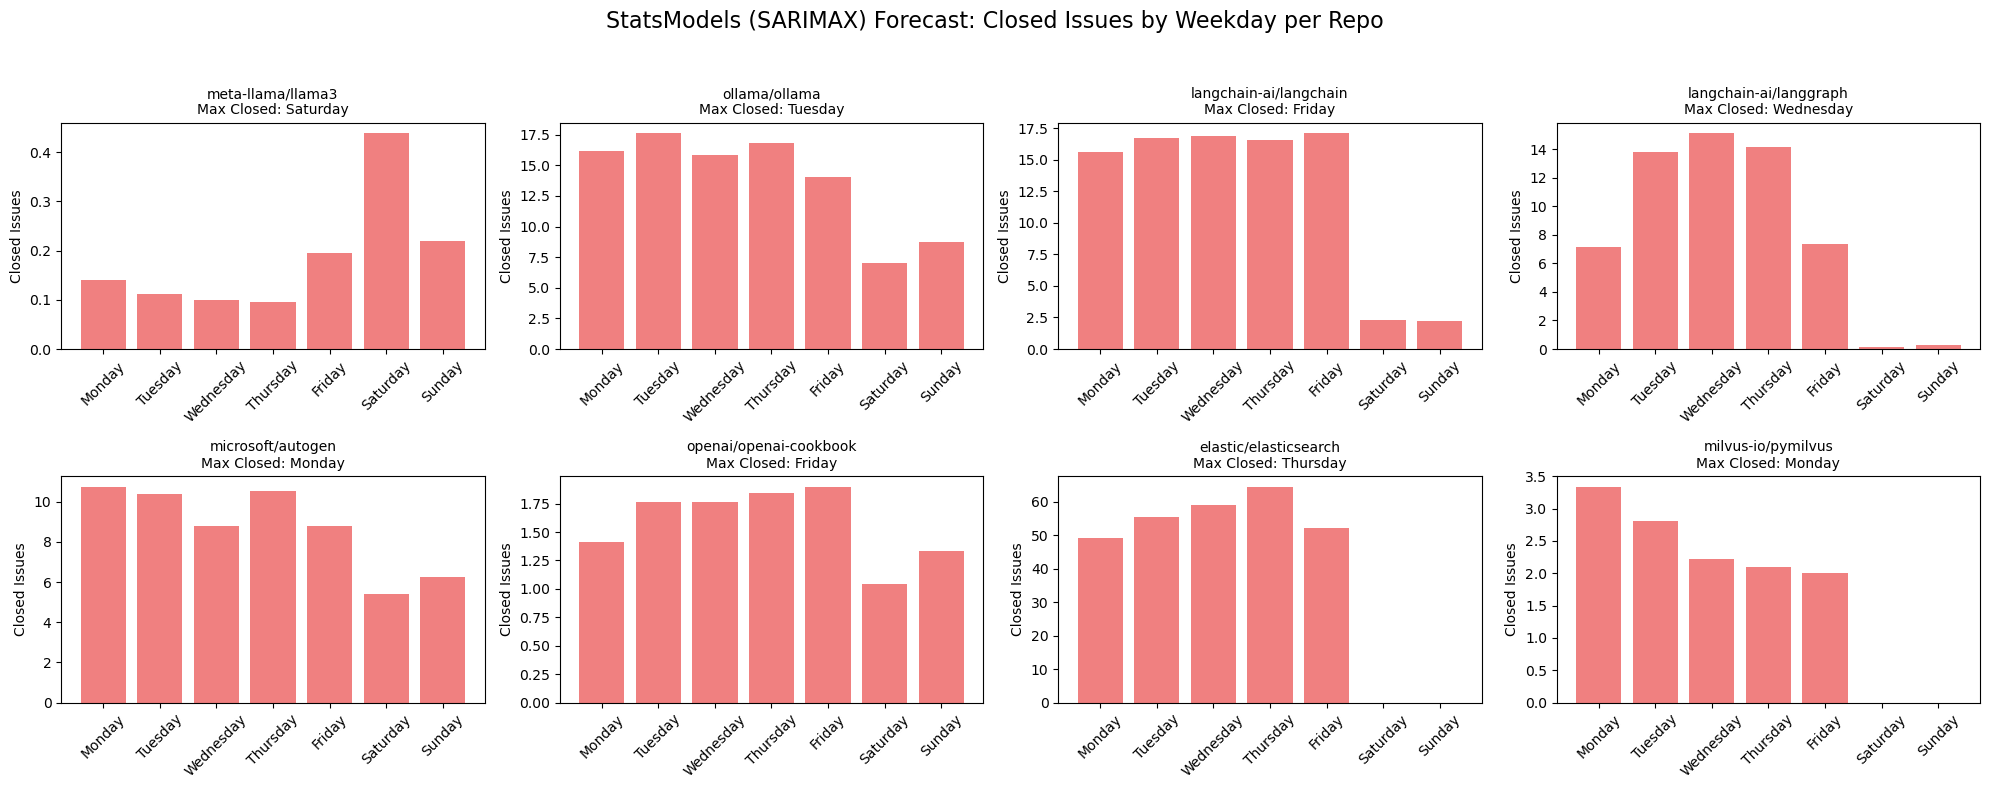

In [ ]:
#Add your code for requirement 10.2 in this cell

df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# plot
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    # groupby daily closed issues
    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(
        pd.date_range(daily_closed.index.min(), daily_closed.index.max()),
        fill_value=0
    )
    daily_closed.index.name = "ds"

    # skip if not enough data
    if len(daily_closed) < 30:
        ax.text(0.5, 0.5, "Not enough data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    try:
        # SARIMAX model
        model = SARIMAX(
            daily_closed,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # forecast next 7 days
    forecast = results.forecast(steps=7)
    forecast_dates = [daily_closed.index[-1] + timedelta(days=i + 1) for i in range(7)]
    forecast.index = forecast_dates
    forecast = forecast.clip(lower=0)

    # map weekday
    weekdays = [d.strftime('%A') for d in forecast.index]
    prediction_dict = dict(zip(weekdays, forecast.values))
    predictions_ordered = [prediction_dict.get(day, 0) for day in days]
    max_day = days[np.argmax(predictions_ordered)]

    # draw bar chart
    ax.bar(days, predictions_ordered, color='lightcoral')
    ax.set_title(f"{repo}\nMax Closed: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
        
    # save each repo SARIMAX closed issues forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(days, predictions_ordered, color='lightcoral')
    single_ax.set_title(f"{repo}\nMax Closed: {max_day}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/issues_closed_weekday_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast: Closed Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/issues_closed_weekday_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-3). The month of the year that has maximum number of issues closed 


</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


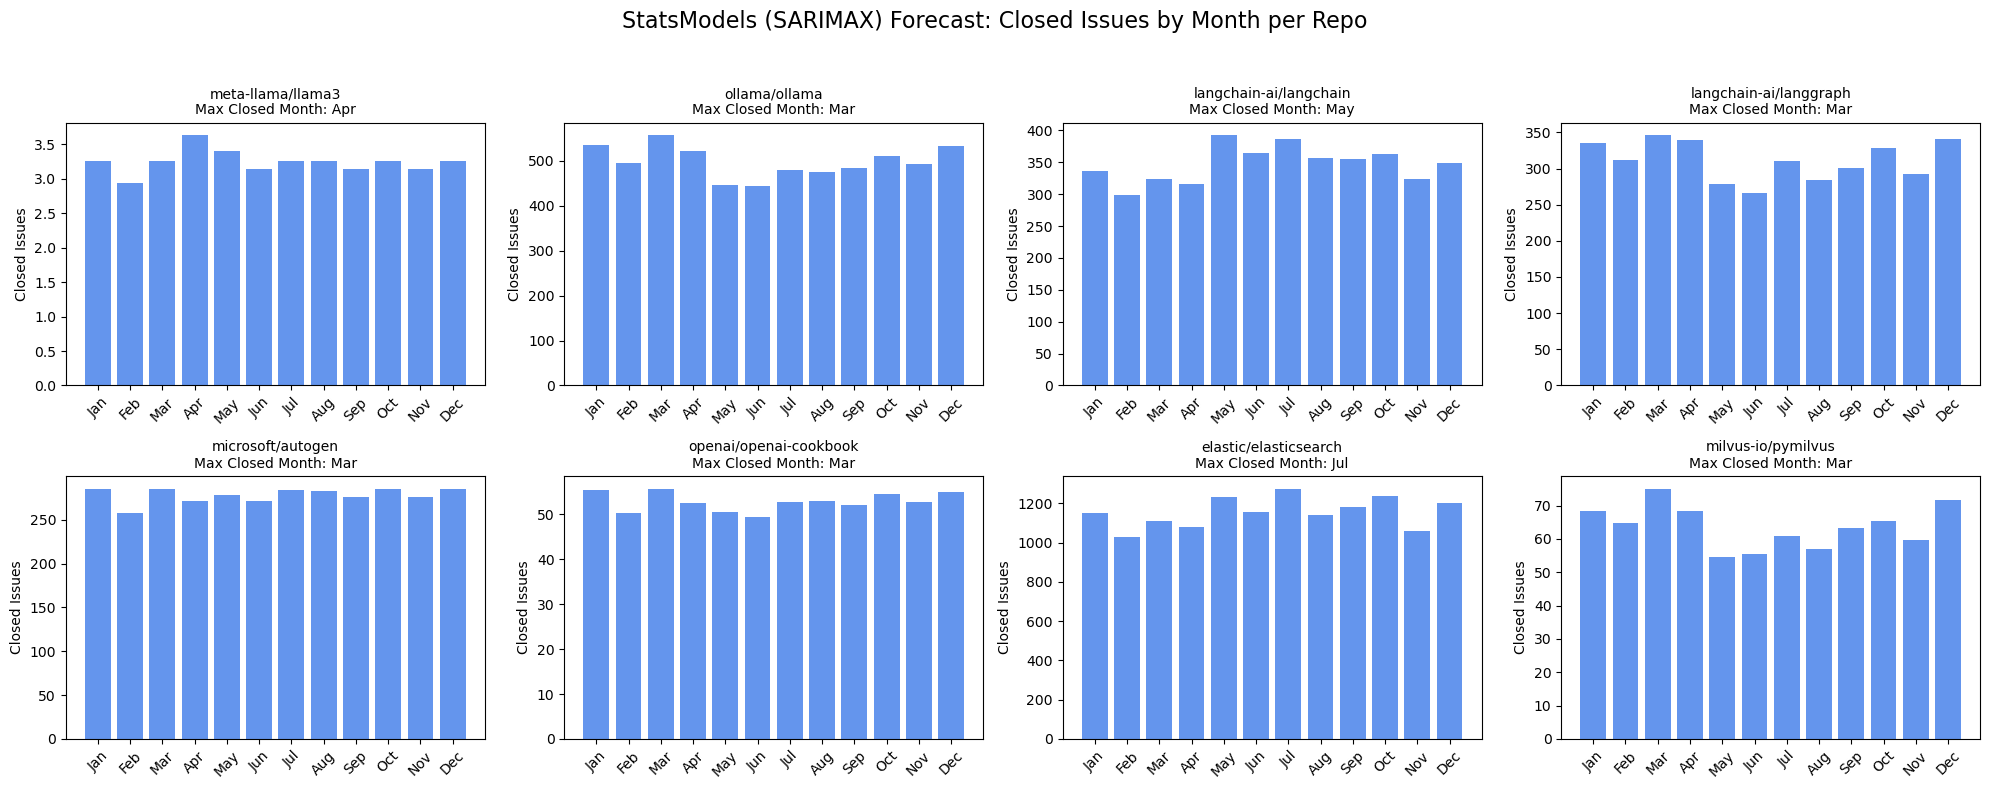

In [ ]:
#Add your code for requirement 10.3 in this cell

df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(
        pd.date_range(daily_closed.index.min(), daily_closed.index.max()),
        fill_value=0
    )
    daily_closed.index.name = "ds"

    if len(daily_closed) < 100:
        ax.text(0.5, 0.5, "Not enough data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # SARIMAX
    try:
        model = SARIMAX(daily_closed,
                        order=(1, 1, 1),
                        seasonal_order=(1, 0, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # next 365 days
    forecast = results.forecast(steps=365)
    forecast_dates = [daily_closed.index[-1] + timedelta(days=i + 1) for i in range(365)]
    forecast = pd.Series(data=forecast.clip(lower=0).values, index=forecast_dates)

    # groupby month
    forecast_df = forecast.reset_index()
    forecast_df.columns = ['ds', 'yhat']
    forecast_df['month'] = forecast_df['ds'].dt.month
    monthly_sum = forecast_df.groupby('month')['yhat'].sum()
    monthly_sum = monthly_sum.reindex(range(1, 13), fill_value=0)

    monthly_values = monthly_sum.values
    max_month = months[np.argmax(monthly_values)]
    
    ax.bar(months, monthly_values, color='cornflowerblue')
    ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    
    # save each repo monthly closed issues SARIMAX forecast plot
    single_fig, single_ax = plt.subplots(figsize=(8, 4))
    single_ax.bar(months, monthly_values, color='cornflowerblue')
    single_ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=12)
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.set_ylabel("Closed Issues")
    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/issues_closed_month_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast: Closed Issues by Month per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/issues_closed_month_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-4). Plot the created issues forecast 

</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


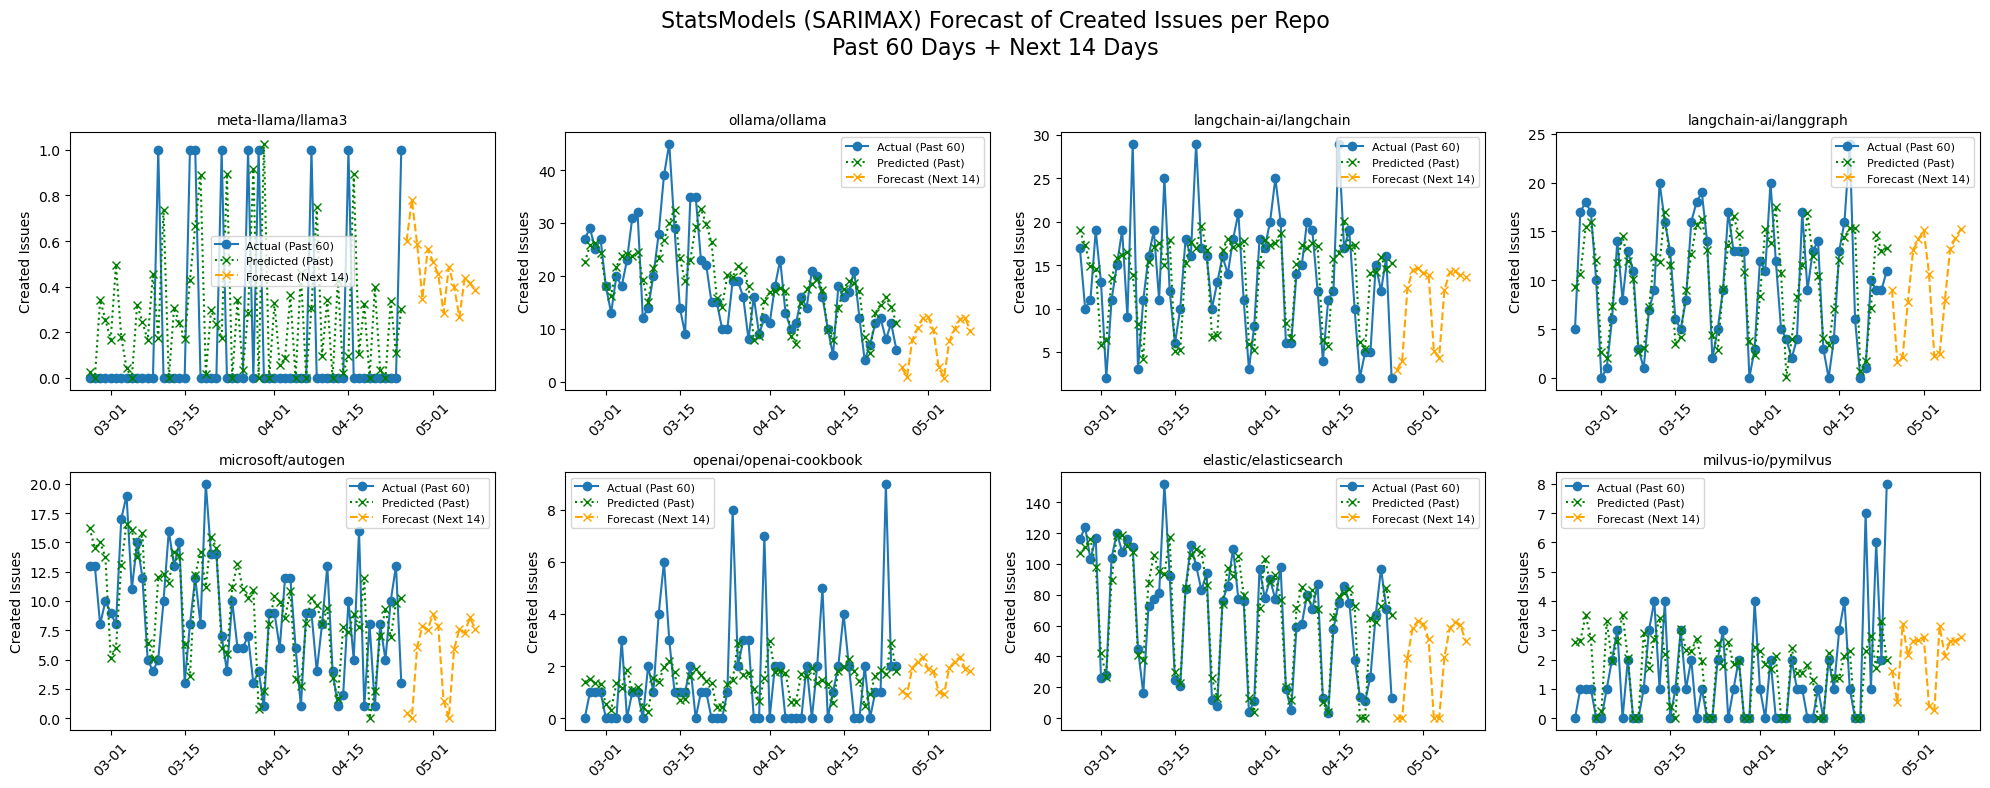

In [ ]:
#Add your code for requirement 10.4 in this cell

df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

past_days = 60
forecast_days = 14

repo_names = df["repo"].unique()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.shape[0] < 30:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # daily created
    daily_created = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_created = daily_created.reindex(
        pd.date_range(start=daily_created.index.min(), end=daily_created.index.max()),
        fill_value=0
    )
    daily_created.index.name = "ds"

    if len(daily_created) < past_days + forecast_days + 7:
        ax.text(0.5, 0.5, "Too short", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    try:
        model = SARIMAX(
            daily_created,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    # Predict past 60 days (for comparison)
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(daily_created) - (past_days + forecast_days), len(daily_created) - forecast_days):
        try:
            temp_model = SARIMAX(daily_created[:i + forecast_days],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 0, 1, 7),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            temp_res = temp_model.filter(results.params)
            pred = temp_res.forecast(steps=1)[0]
            compare_preds.append(max(0, pred))
            compare_actuals.append(daily_created[i + forecast_days])
            compare_dates.append(daily_created.index[i + forecast_days])
        except:
            continue

    # forecast next 14 days
    forecast = results.forecast(steps=forecast_days)
    forecast_dates = [daily_created.index[-1] + timedelta(days=i + 1) for i in range(forecast_days)]

    # 3 parts
    actual_plot = daily_created[-past_days:]
    predicted_plot = pd.Series(compare_preds, index=compare_dates)
    future_plot = pd.Series(forecast.clip(lower=0).values, index=forecast_dates)

    # plot
    ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_plot.index, future_plot.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Created Issues")
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX created issues forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    single_ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    single_ax.plot(future_plot.index, future_plot.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Created Issues")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/created_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast of Created Issues per Repo\nPast 60 Days + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/created_issues_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-5). Plot the closed issues forecast 

</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


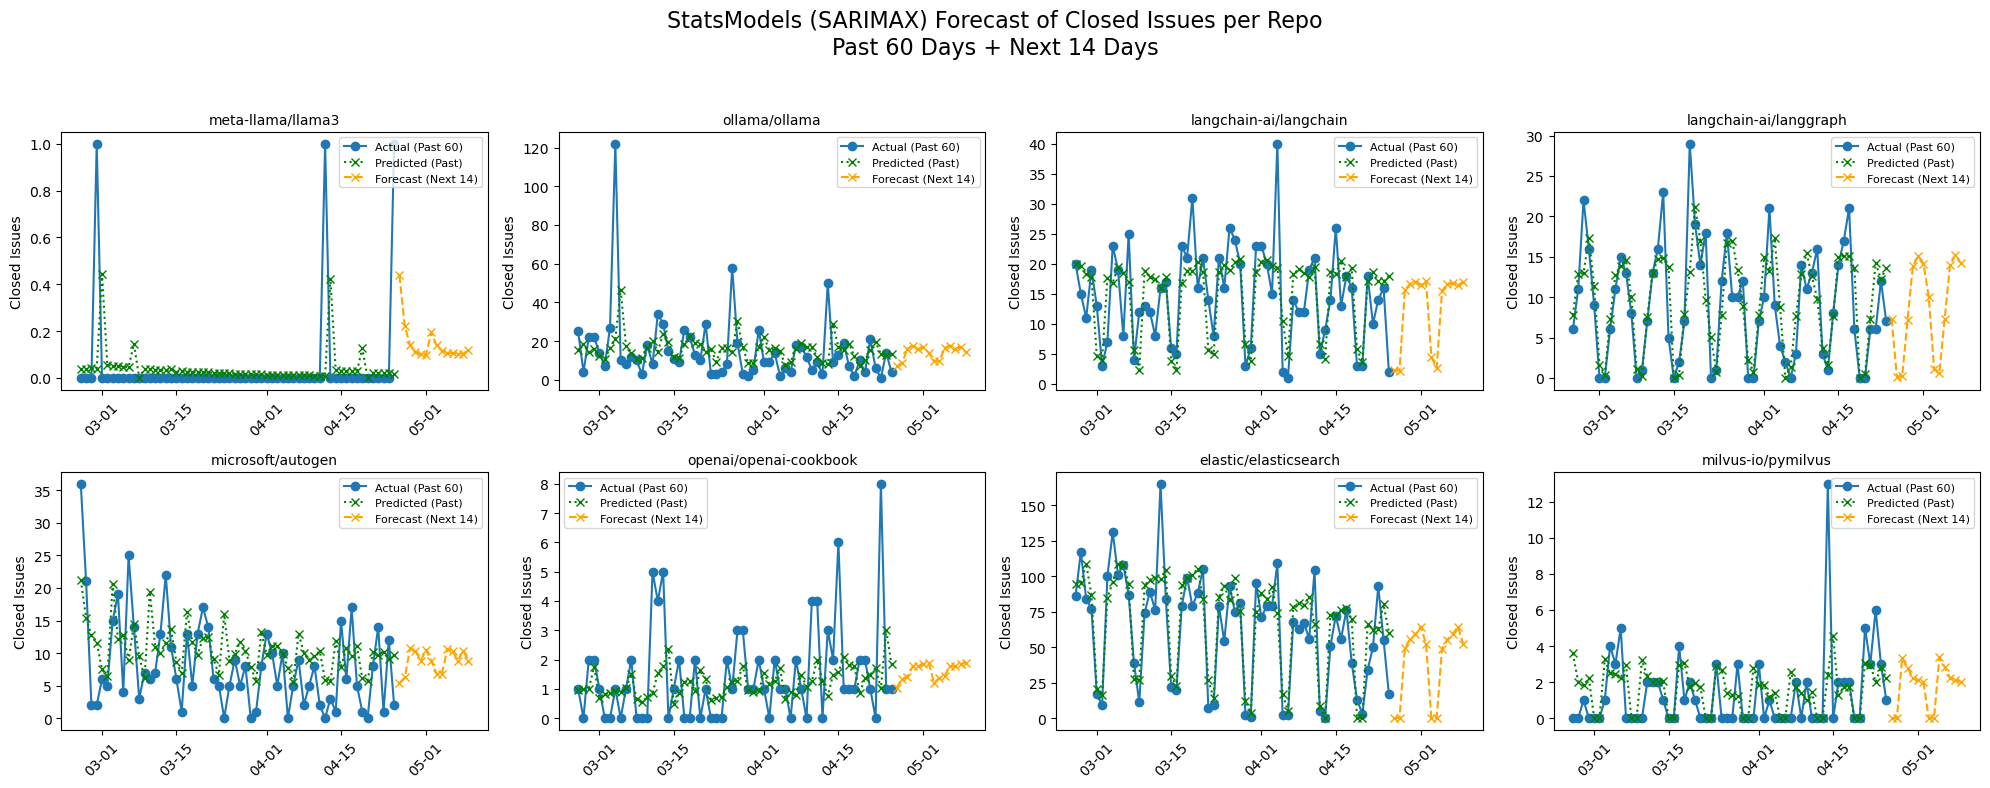

In [ ]:
#Add your code for requirement 10.5 in this cell

df = df_2_years.copy()
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

repo_names = df["repo"].unique()

past_days = 60
forecast_days = 14

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.shape[0] < 30:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # daily closed
    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(
        pd.date_range(start=daily_closed.index.min(), end=daily_closed.index.max()),
        fill_value=0
    )
    daily_closed.index.name = "ds"

    if len(daily_closed) < past_days + forecast_days + 7:
        ax.text(0.5, 0.5, "Too short", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    try:
        model = SARIMAX(
            daily_closed,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    # predict past 60 days (for evaluation)
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(daily_closed) - (past_days + forecast_days), len(daily_closed) - forecast_days):
        try:
            temp_model = SARIMAX(daily_closed[:i + forecast_days],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 0, 1, 7),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            temp_res = temp_model.filter(results.params)
            pred = temp_res.forecast(steps=1)[0]
            compare_preds.append(max(0, pred))
            compare_actuals.append(daily_closed[i + forecast_days])
            compare_dates.append(daily_closed.index[i + forecast_days])
        except:
            continue

    # forecast next 14 days
    forecast = results.forecast(steps=forecast_days)
    forecast_dates = [daily_closed.index[-1] + timedelta(days=i + 1) for i in range(forecast_days)]
    future_preds = pd.Series(data=forecast.clip(lower=0).values, index=forecast_dates)

    # build segments for plotting
    actual_plot = daily_closed[-past_days:]
    predicted_plot = pd.Series(compare_preds, index=compare_dates)

    # plot
    ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX closed issues forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    single_ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    single_ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Closed Issues")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/closed_issues_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast of Closed Issues per Repo\nPast 60 Days + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/closed_issues_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-6). Plot the pulls forecast 

</div>

Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


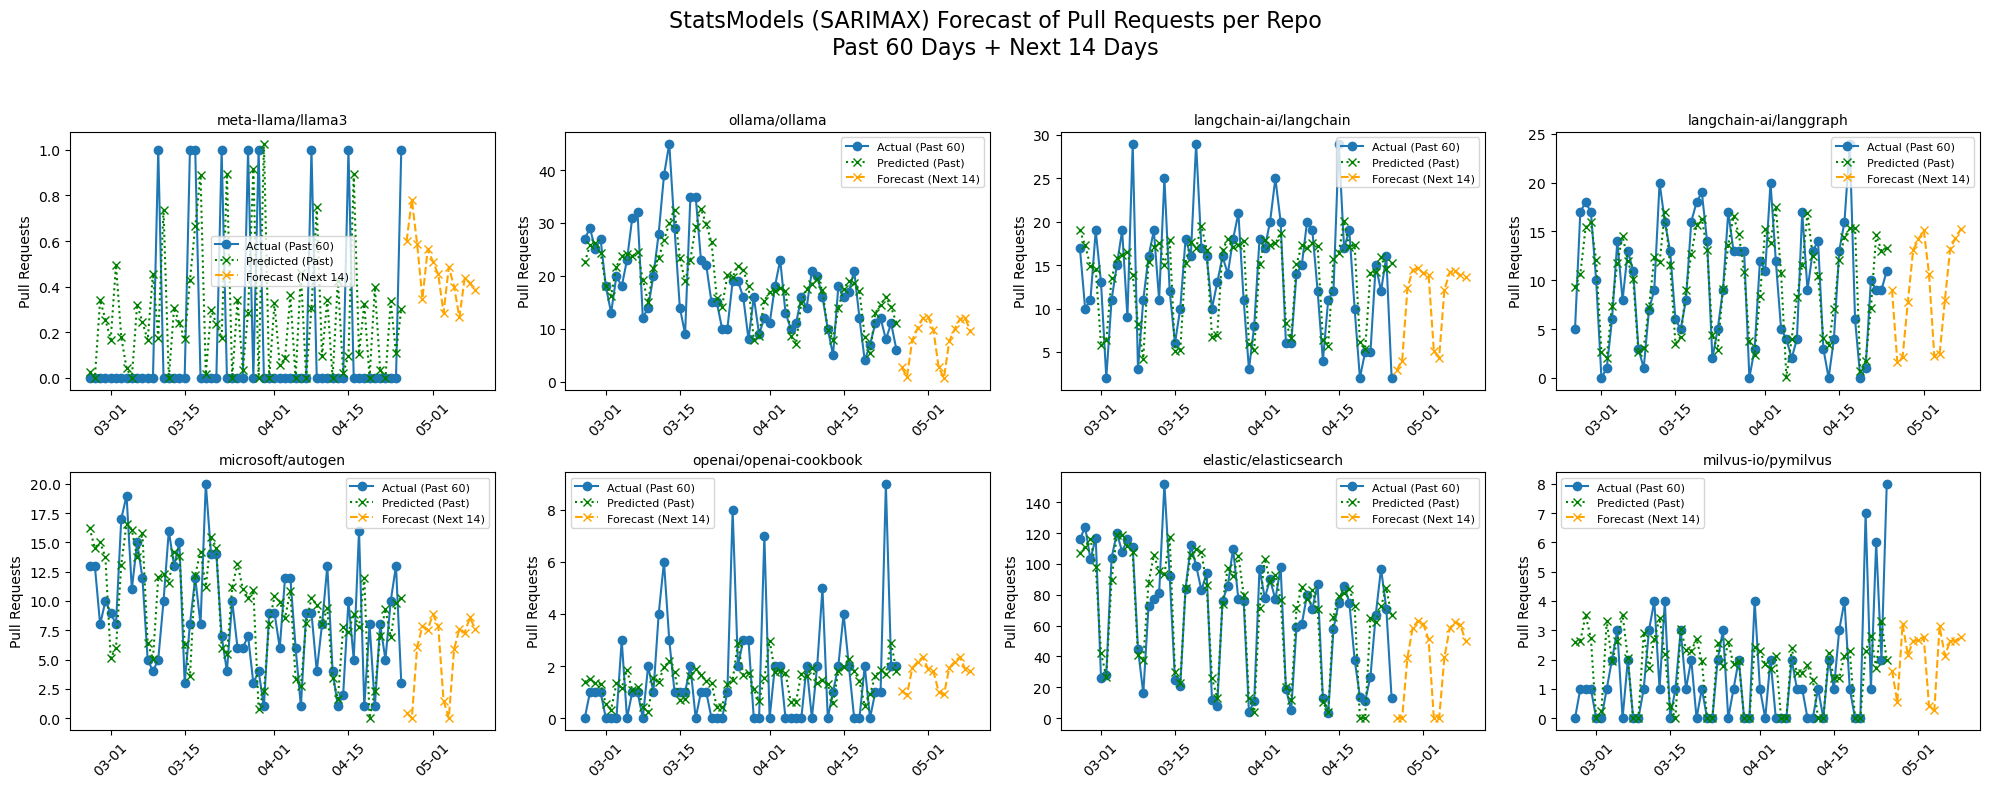

In [ ]:
#Add your code for requirement 10.6 in this cell

df = df_2_years.copy()
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

if "pull_request" not in df.columns:
    df["is_pr"] = False
else:
    df["is_pr"] = df["pull_request"].notna()

df_pr = df[df["is_pr"]]
repo_names = df_pr["repo"].unique()

past_days = 60
forecast_days = 14

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_pr[df_pr["repo"] == repo]

    if repo_df.shape[0] < 30:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # daily PRs
    daily_prs = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_prs = daily_prs.reindex(
        pd.date_range(start=daily_prs.index.min(), end=daily_prs.index.max()),
        fill_value=0
    )
    daily_prs.index.name = "ds"

    if len(daily_prs) < past_days + forecast_days + 7:
        ax.text(0.5, 0.5, "Too short", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    try:
        model = SARIMAX(
            daily_prs,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha='center', va='center', fontsize=12)
        ax.axis("off")
        continue

    # predict past 60 days for evaluation
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(daily_prs) - (past_days + forecast_days), len(daily_prs) - forecast_days):
        try:
            temp_model = SARIMAX(daily_prs[:i + forecast_days],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 0, 1, 7),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            temp_res = temp_model.filter(results.params)
            pred = temp_res.forecast(steps=1)[0]
            compare_preds.append(max(0, pred))
            compare_actuals.append(daily_prs[i + forecast_days])
            compare_dates.append(daily_prs.index[i + forecast_days])
        except:
            continue

    # next 14 days
    forecast = results.forecast(steps=forecast_days)
    forecast_dates = [daily_prs.index[-1] + timedelta(days=i + 1) for i in range(forecast_days)]
    future_preds = pd.Series(data=forecast.clip(lower=0).values, index=forecast_dates)

    actual_plot = daily_prs[-past_days:]
    predicted_plot = pd.Series(compare_preds, index=compare_dates)

    # plot
    ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Pull Requests")
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX pull requests forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 60)", marker='o')
    single_ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    single_ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 14)", linestyle='--', marker='x', color='orange')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Pull Requests")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/pull_requests_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels (SARIMAX) Forecast of Pull Requests per Repo\nPast 60 Days + Next 14 Days", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/pull_requests_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-7). Plot the commits forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved ollama_ollama
Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved langchain-ai_langgraph


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved microsoft_autogen
Saved openai_openai-cookbook


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved elastic_elasticsearch


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


Saved milvus-io_pymilvus


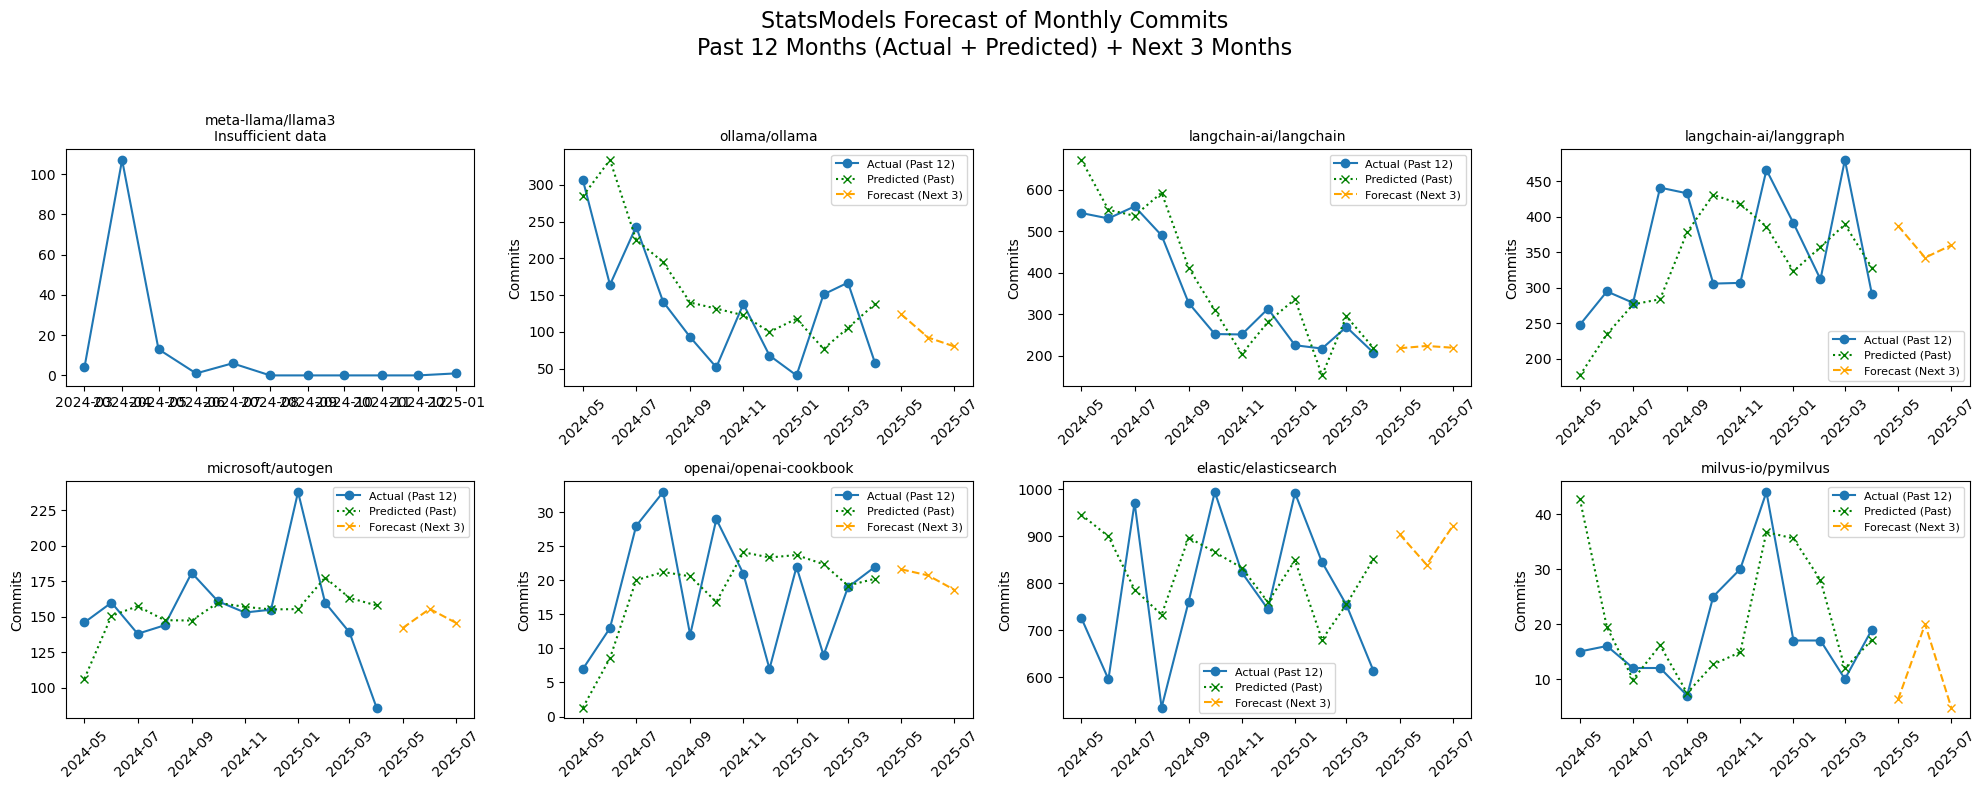

In [ ]:
#Add your code for requirement 10.7 in this cell

df_commits_data["date"] = pd.to_datetime(df_commits_data["date"])
repo_names = df_commits_data["repo"].unique()

eval_months = 12
forecast_months = 3

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_commits_data[df_commits_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    monthly_commits = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_commits.index = monthly_commits.index.to_timestamp()

    if monthly_commits.empty:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly_commits.index.min(), monthly_commits.index.max(), freq="MS")
    monthly_commits = monthly_commits.reindex(full_index, fill_value=0)

    if len(monthly_commits) < eval_months + forecast_months + 3:
        ax.plot(monthly_commits.index, monthly_commits.values, label="Actual", marker='o')
        ax.set_title(f"{repo}\nInsufficient data", fontsize=10)
        ax.axis("on")
        continue

    try:
        model = SARIMAX(
            monthly_commits,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # predict past 12 months (evaluation)
    compare_preds, compare_actuals, compare_dates = [], [], []
    for i in range(len(monthly_commits) - (eval_months + forecast_months), len(monthly_commits) - forecast_months):
        try:
            temp_model = SARIMAX(monthly_commits[:i + forecast_months],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 0, 1, 12),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            temp_res = temp_model.filter(results.params)
            pred = temp_res.forecast(steps=1)[0]
            compare_preds.append(max(0, pred))
            compare_actuals.append(monthly_commits[i + forecast_months])
            compare_dates.append(monthly_commits.index[i + forecast_months])
        except:
            continue

    # next 3 months
    forecast = results.forecast(steps=forecast_months)
    forecast_index = pd.date_range(monthly_commits.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq="MS")
    future_preds = pd.Series(data=forecast.clip(lower=0).values, index=forecast_index)

    # past 12 months
    actual_plot = monthly_commits[-eval_months:]
    predicted_plot = pd.Series(compare_preds, index=compare_dates)

    # plot
    ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 12)", marker='o')
    ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.set_ylabel("Commits")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX monthly commits forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 12)", marker='o')
    single_ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    single_ax.plot(future_preds.index, future_preds.values, label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Commits")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/monthly_commits_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels Forecast of Monthly Commits\nPast 12 Months (Actual + Predicted) + Next 3 Months", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/monthly_commits_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-8). Plot the branches forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved meta-llama_llama3
Saved ollama_ollama
Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved langchain-ai_langgraph
Saved microsoft_autogen
Saved openai_openai-cookbook


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved elastic_elasticsearch
Saved milvus-io_pymilvus


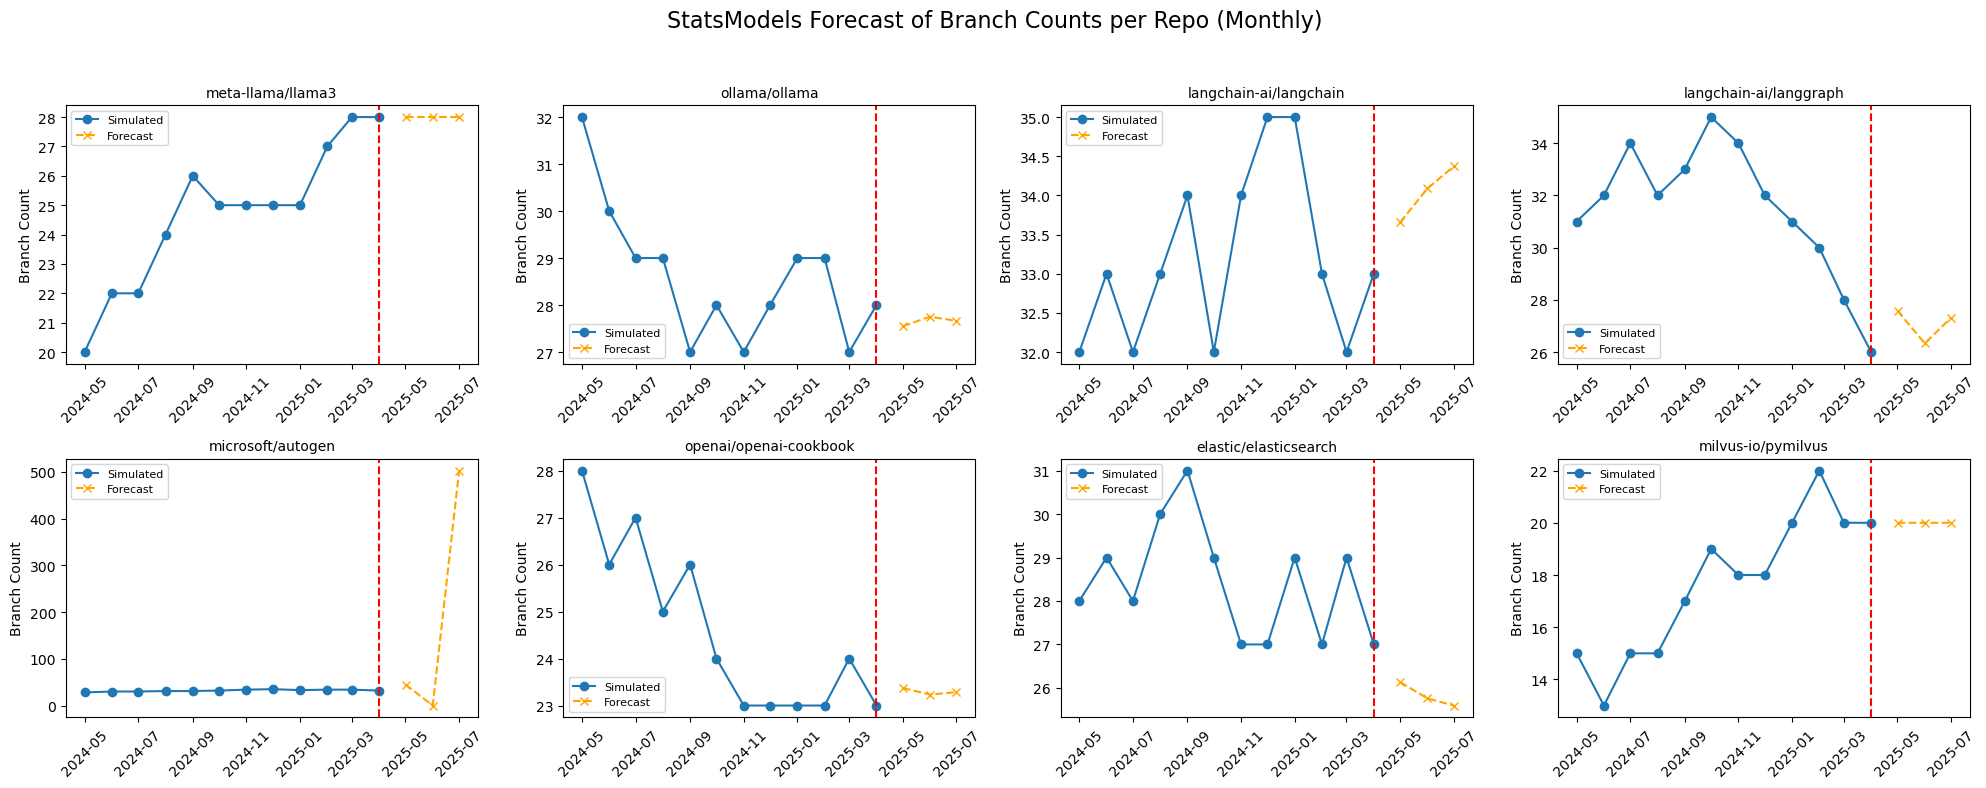

In [ ]:
#Add your code for requirement 10.8 in this cell

repos = df_branches_data["repo"].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

forecast_months = 3

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_branches_data[df_branches_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate historical monthly data
    latest = row["branch_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-2, 3, size=12).cumsum(), 0, None)

    # DataFrame
    start_date = pd.date_range(end=pd.Timestamp.today(), periods=12, freq="MS")[0]
    dates = pd.date_range(start=start_date, periods=12, freq="MS")
    ts = pd.Series(simulated_series, index=dates)

    # SARIMAX model
    try:
        model = SARIMAX(ts,
                        order=(1, 1, 1),
                        seasonal_order=(1, 0, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # next 3 months
    future_dates = pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq="MS")
    forecast = results.forecast(steps=forecast_months)
    forecast = forecast.clip(lower=0)

    # combine
    all_values = np.concatenate([ts.values, forecast.values])
    all_dates = ts.index.append(future_dates)

    # plot
    ax.plot(ts.index, ts.values, label="Simulated", marker='o')
    ax.plot(future_dates, forecast.values, label="Forecast", linestyle="--", marker='x', color='orange')
    ax.axvline(x=ts.index[-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Branch Count")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX monthly branches forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(ts.index, ts.values, label="Simulated", marker='o')
    single_ax.plot(future_dates, forecast.values, label="Forecast", linestyle="--", marker='x', color='orange')
    single_ax.axvline(x=ts.index[-1], color='red', linestyle='--')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Branch Count")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/monthly_branches_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/monthly_branches_forecast.png")
plt.show()

<div class="alert alert-block alert-danger">   
    
#### REQ10-9). Plot the contributors forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved meta-llama_llama3
Saved ollama_ollama


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved langchain-ai_langchain
Saved langchain-ai_langgraph
Saved microsoft_autogen


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved openai_openai-cookbook
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


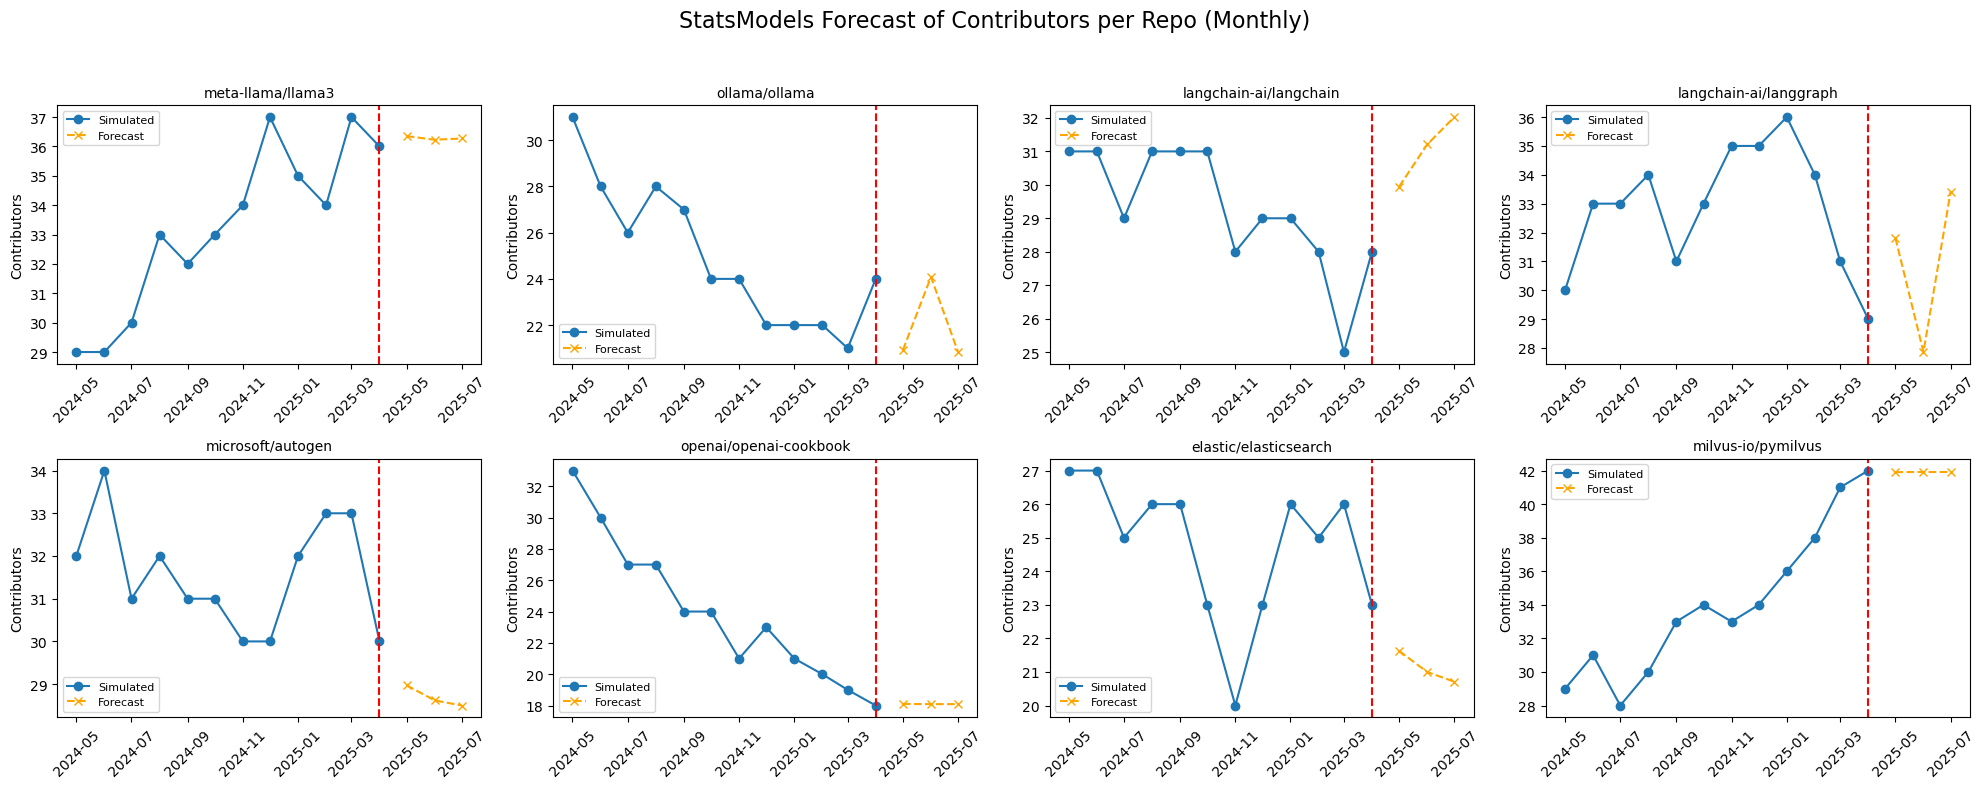

In [ ]:
#Add your code for requirement 10.9 in this cell

repos = df_contributors_data["repo"].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

forecast_months = 3

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_contributors_data[df_contributors_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate historical monthly data
    latest = row["contributor_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-3, 4, size=12).cumsum(), 0, None)

    start_date = pd.date_range(end=pd.Timestamp.today(), periods=12, freq="MS")[0]
    dates = pd.date_range(start=start_date, periods=12, freq="MS")
    ts = pd.Series(simulated_series, index=dates)

    # SARIMAX model
    try:
        model = SARIMAX(ts,
                        order=(1, 1, 1),
                        seasonal_order=(1, 0, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model Error", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # next 3 months
    future_dates = pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq="MS")
    forecast = results.forecast(steps=forecast_months)
    forecast = forecast.clip(lower=0)

    # combine
    all_values = np.concatenate([ts.values, forecast.values])
    all_dates = ts.index.append(future_dates)

    # plot
    ax.plot(ts.index, ts.values, label="Simulated", marker="o")
    ax.plot(future_dates, forecast.values, label="Forecast", linestyle="--", marker="x", color='orange')
    ax.axvline(x=ts.index[-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Contributors")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX monthly contributors forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(ts.index, ts.values, label="Simulated", marker='o')
    single_ax.plot(future_dates, forecast.values, label="Forecast", linestyle="--", marker='x', color='orange')
    single_ax.axvline(x=ts.index[-1], color='red', linestyle='--')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Contributors")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/monthly_contributors_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels Forecast of Contributors per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/monthly_contributors_forecast.png")
plt.show()


<div class="alert alert-block alert-danger">   
    
#### REQ10-10). Plot the releases forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved ollama_ollama
Saved langchain-ai_langchain


/Users/lohi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Saved microsoft_autogen
Saved elastic_elasticsearch
Saved milvus-io_pymilvus


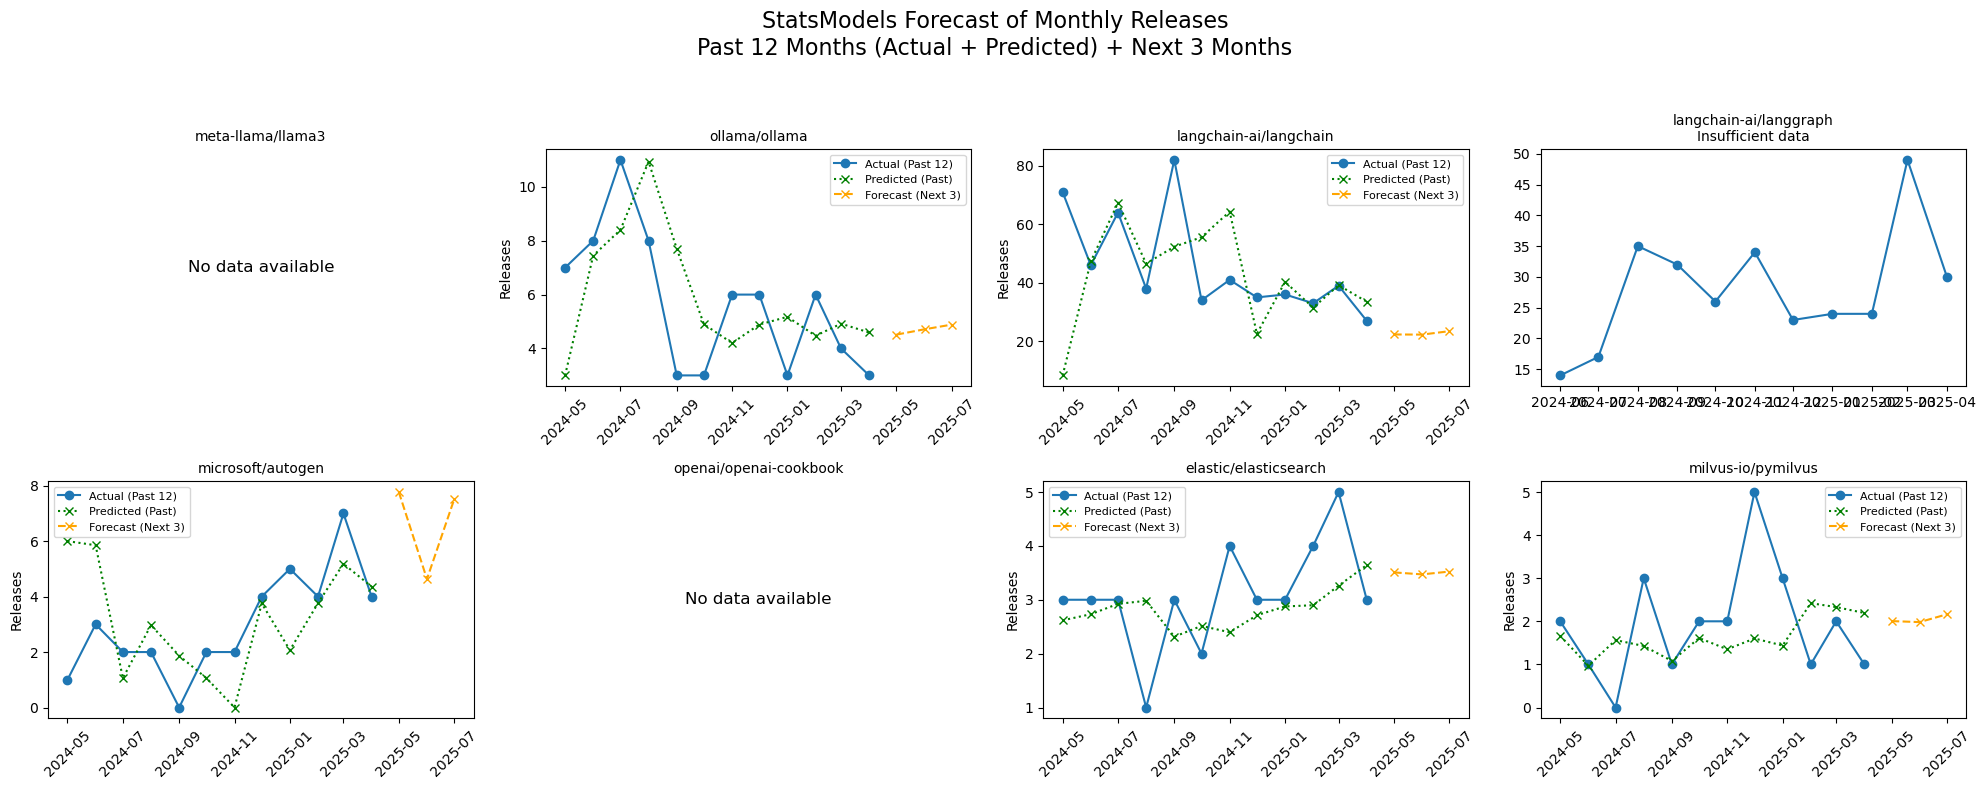

In [ ]:
#Add your code for requirement 10.10 in this cell

df_releases_data["date"] = pd.to_datetime(df_releases_data["date"])

eval_months = 12
forecast_months = 3

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_releases_data[df_releases_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No data available", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # group by month
    monthly_releases = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_releases.index = monthly_releases.index.to_timestamp()

    if monthly_releases.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly_releases.index.min(), monthly_releases.index.max(), freq="MS")
    monthly_releases = monthly_releases.reindex(full_index, fill_value=0)

    if len(monthly_releases) < eval_months + forecast_months:
        ax.plot(monthly_releases.index, monthly_releases.values, label="Actual", marker='o')
        ax.set_title(f"{repo}\nInsufficient data", fontsize=10)
        ax.axis("on")
        continue

    # build SARIMAX model
    try:
        model = SARIMAX(monthly_releases, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), 
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
    except:
        ax.text(0.5, 0.5, "Model error", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # forecast
    future_dates = pd.date_range(monthly_releases.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq="MS")
    forecast = results.forecast(steps=forecast_months)
    forecast = forecast.clip(lower=0)

    # past actual & predicted range
    past_start = monthly_releases.index[-eval_months]
    actual_plot = monthly_releases[monthly_releases.index >= past_start]
    predicted_plot = results.get_prediction(start=past_start).predicted_mean.clip(lower=0)

    # plot
    ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 12)", marker='o')
    ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    ax.plot(future_dates, forecast.values, label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')

    ax.set_title(f"{repo}", fontsize=10)
    ax.set_ylabel("Releases")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)
    
    # save each repo SARIMAX monthly releases forecast plot
    single_fig, single_ax = plt.subplots(figsize=(10, 5))

    single_ax.plot(actual_plot.index, actual_plot.values, label="Actual (Past 12)", marker='o')
    single_ax.plot(predicted_plot.index, predicted_plot.values, label="Predicted (Past)", linestyle=':', marker='x', color='green')
    single_ax.plot(future_dates, forecast.values, label="Forecast (Next 3)", linestyle='--', marker='x', color='orange')
    single_ax.set_title(f"{repo}", fontsize=12)
    single_ax.set_ylabel("Releases")
    single_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    single_ax.tick_params(axis='x', rotation=45)
    single_ax.legend(fontsize=8)

    plt.tight_layout()
    safe_repo = re.sub(r'[^\w\-_.]', '_', repo)
    plt.savefig(f"../Forecasting/StatsModel/monthly_releases_forecast_{safe_repo}.png")
    logger.info(f"Saved {safe_repo}")
    plt.close(single_fig)

fig.suptitle("StatsModels Forecast of Monthly Releases\nPast 12 Months (Actual + Predicted) + Next 3 Months", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/StatsModel/monthly_releases_forecast.png")
plt.show()